In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import time
import seaborn as sns
import pandas as pd
from playsound import playsound

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
import xgboost
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KernelDensity 
from sklearn.model_selection import GridSearchCV

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.stats import multivariate_normal

# Let's load the data

In [4]:
def read_data(i_ini, nobs):
    print('Reading data from ' + str( (i_ini - 1_000_000) / nobs) + ' ...')
    data = []
    with open('../data/Higgs/HIGGS.csv', 'r') as source:
        reader = csv.reader(source, quoting=csv.QUOTE_NONNUMERIC)

        for i, line in enumerate(reader):
            if (i > i_ini) & (i < i_ini + nobs): 
                data.append(line)
    return np.asarray(data)

In [5]:
check_data_jet1 = np.loadtxt('../data/Higgs/jet1.dat')
check_data_jet2 = np.loadtxt('../data/Higgs/jet2.dat')
check_data_jet3 = np.loadtxt('../data/Higgs/jet3.dat')
check_data_jet4 = np.loadtxt('../data/Higgs/jet4.dat')
check_data_MET = np.loadtxt('../data/Higgs/MET.dat')
check_data_lepton = np.loadtxt('../data/Higgs/lepton.dat')

data from: https://github.com/uci-igb/higgs-susy

In [6]:
nobs  = 1_000_000 # Total number of observations
nobs_test = 100_000 # Total number of test observations

data = []
test_data = []
with open('../data/Higgs/HIGGS.csv', 'r') as source:
    reader = csv.reader(source, quoting=csv.QUOTE_NONNUMERIC)

    for i, line in enumerate(reader):
        data.append(line)
        if i == nobs: break
    for i, line in enumerate(reader):
        #print(i)
        test_data.append(line)
        if i == nobs_test: break
data = np.asarray(data)
test_data = np.asarray(test_data)

In [7]:
nobs  = 1_000_000 # Total number of observations

data = []
source = open('../data/Higgs/HIGGS.csv', 'r')
reader = csv.reader(source, quoting=csv.QUOTE_NONNUMERIC)

for i, line in enumerate(reader):
    data.append(line)
    if i == nobs: break
data = np.asarray(data)

In [8]:
features_names = ['lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi',
                  'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag',
                  'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag',
                  'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag',
                  'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag',
                  'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']

In [9]:
data.shape

(1000001, 29)

In [10]:
print('Fraction of signal events', np.sum(data[:,0]) / len(data[:,0]))

Fraction of signal events 0.5296724703275296


In [11]:
print('phi min jet 1 = ', np.min(data[:,8], axis = 0))
print('phi min jet 2 = ', np.min(data[:,12], axis = 0))
print('phi min jet 3 = ', np.min(data[:,16], axis = 0))
print('phi min jet 4 = ', np.min(data[:,20], axis = 0))

phi min jet 1 =  -1.7412374019622803
phi min jet 2 =  -1.742371678352356
phi min jet 3 =  -1.7420687675476074
phi min jet 4 =  -1.7426908016204834


In [12]:
print('phi max jet 1 = ', np.max(data[:,8], axis = 0))
print('phi max jet 2 = ', np.max(data[:,12], axis = 0))
print('phi max jet 3 = ', np.max(data[:,16], axis = 0))
print('phi max jet 4 = ', np.max(data[:,20], axis = 0))

phi max jet 1 =  1.741453766822815
phi max jet 2 =  1.7431747913360596
phi max jet 3 =  1.7428839206695557
phi max jet 4 =  1.7433723211288452


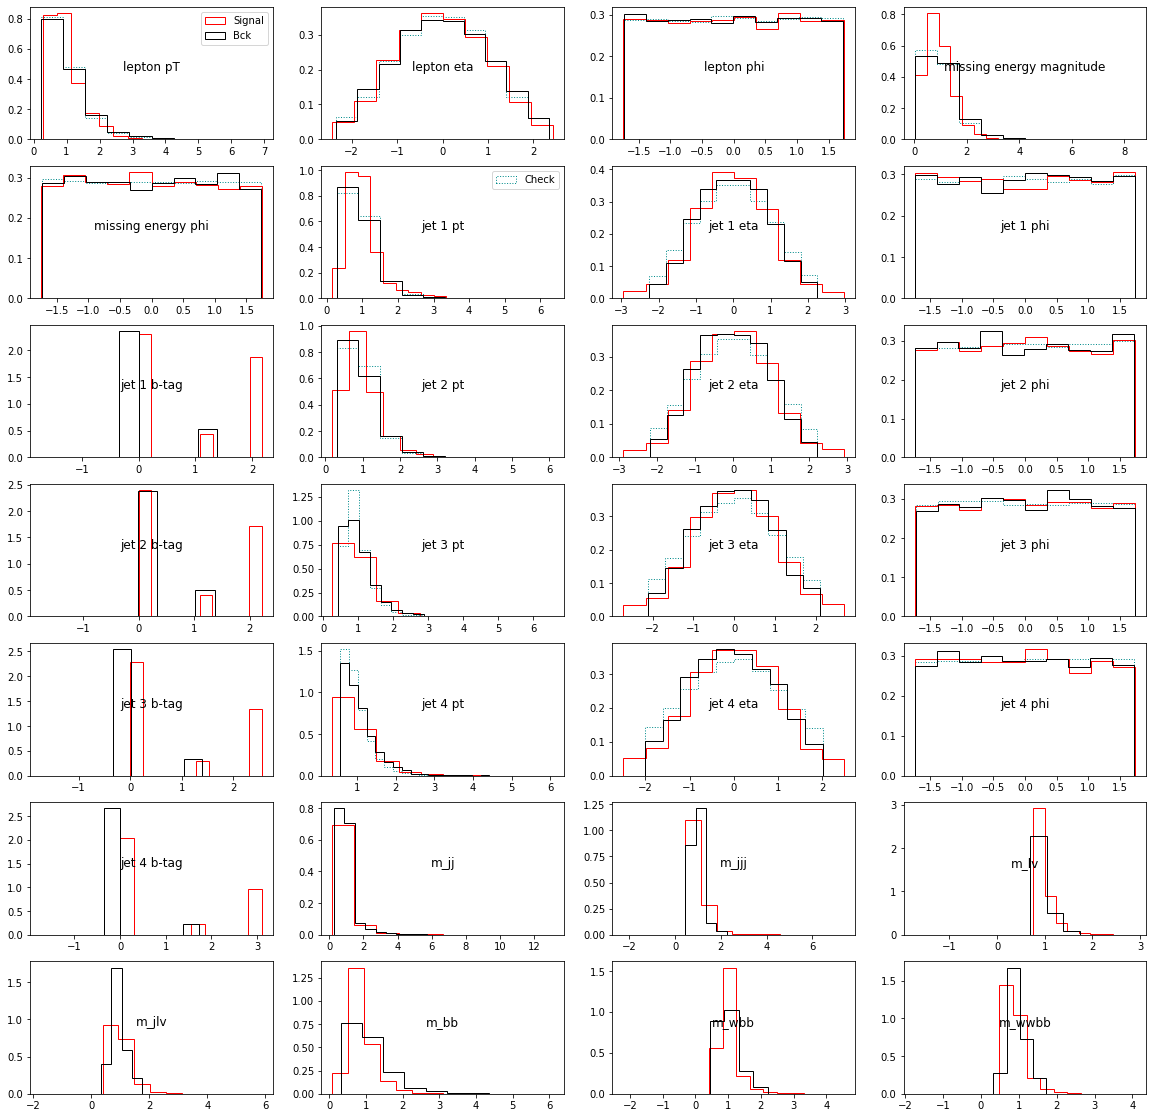

In [13]:
# Some exploratory plots
npoints = 10000

signal_ind = np.where(data[:npoints,0] == 1)[0]
bck_ind    = np.where(data[:npoints,0] == 0)[0]

ncol = 4
nrow = 7

bines = []
fig, ax = plt.subplots(nrow, ncol, figsize = (20, 20))


_, bins, _ = ax[0,0].hist(check_data_lepton[:,0]/np.mean(check_data_lepton[:,0]), color = 'darkcyan', linestyle = ':', density = True, histtype = 'step')
bines.append(bins)
_, bins, _ = ax[0,1].hist((check_data_lepton[:,1] - np.mean(check_data_lepton[:,1])) / np.std(check_data_lepton[:,1]), color = 'darkcyan', linestyle = ':', density = True, histtype = 'step')
bines.append(bins)
_, bins, _ = ax[0,2].hist((check_data_lepton[:,2] - np.mean(check_data_lepton[:,2])) / np.std(check_data_lepton[:,2]), color = 'darkcyan', linestyle = ':', density = True, histtype = 'step')
bines.append(bins)

_, bins, _ = ax[0,3].hist(check_data_MET[:,0]/np.mean(check_data_MET[:,0]), color = 'darkcyan', linestyle = ':', density = True, histtype = 'step')
bines.append(bins)
_, bins, _ = ax[1,0].hist((check_data_MET[:,2] - np.mean(check_data_MET[:,2])) / np.std(check_data_MET[:,2]), color = 'darkcyan', linestyle = ':', density = True, histtype = 'step')
bines.append(bins)

_, bins, _ = ax[1,1].hist(check_data_jet1[:,0]/np.mean(check_data_jet1[:,0]), color = 'darkcyan', linestyle = ':', density = True, histtype = 'step', label = 'Check')
bines.append(bins)
ax[1,1].legend()
_, bins, _ = ax[1,2].hist((check_data_jet1[:,1] - np.mean(check_data_jet1[:,1])) / np.std(check_data_jet1[:,1]), color = 'darkcyan', linestyle = ':', density = True, histtype = 'step')
bines.append(bins)
_, bins, _ = ax[1,3].hist((check_data_jet1[:,2] - np.mean(check_data_jet1[:,2])) / np.std(check_data_jet1[:,2]), color = 'darkcyan', linestyle = ':', density = True, histtype = 'step')
bines.append(bins)

bines.append(bins) # añado otro bin fantasma para que no se desfase.... Seria el bin del jet b-tag

_, bins, _ = ax[2,1].hist(check_data_jet2[:,0]/np.mean(check_data_jet2[:,0]), color = 'darkcyan', linestyle = ':', density = True, histtype = 'step')
bines.append(bins)
_, bins, _ = ax[2,2].hist((check_data_jet2[:,1] - np.mean(check_data_jet2[:,1])) / np.std(check_data_jet2[:,1]), color = 'darkcyan', linestyle = ':', density = True, histtype = 'step')
bines.append(bins)
_, bins, _ = ax[2,3].hist((check_data_jet2[:,2] - np.mean(check_data_jet2[:,2])) / np.std(check_data_jet2[:,2]), color = 'darkcyan', linestyle = ':', density = True, histtype = 'step')
bines.append(bins)

bines.append(bins) # añado otro bin fantasma para que no se desfase.... Seria el bin del jet b-tag

_, bins, _ = ax[3,1].hist(check_data_jet3[:,0]/np.mean(check_data_jet3[:,0]), color = 'darkcyan', linestyle = ':', density = True, histtype = 'step', bins = 20)
bines.append(bins)
_, bins, _ = ax[3,2].hist((check_data_jet3[:,1] - np.mean(check_data_jet3[:,1])) / np.std(check_data_jet3[:,1]), color = 'darkcyan', linestyle = ':', density = True, histtype = 'step')
bines.append(bins)
_, bins, _ = ax[3,3].hist((check_data_jet3[:,2] - np.mean(check_data_jet3[:,2])) / np.std(check_data_jet3[:,2]), color = 'darkcyan', linestyle = ':', density = True, histtype = 'step')
bines.append(bins)

bines.append(bins) # añado otro bin fantasma para que no se desfase.... Seria el bin del jet b-tag

_, bins, _ = ax[4,1].hist(check_data_jet4[:,0]/np.mean(check_data_jet4[:,0]), color = 'darkcyan', linestyle = ':', density = True, histtype = 'step', bins = 20)
bines.append(bins)
_, bins, _ = ax[4,2].hist((check_data_jet4[:,1] - np.mean(check_data_jet4[:,1])) / np.std(check_data_jet4[:,1]), color = 'darkcyan', linestyle = ':', density = True, histtype = 'step')
bines.append(bins)
_, bins, _ = ax[4,3].hist((check_data_jet4[:,2] - np.mean(check_data_jet4[:,2])) / np.std(check_data_jet4[:,2]), color = 'darkcyan', linestyle = ':', density = True, histtype = 'step')
bines.append(bins)

for i in range(nrow):
    for j in range(ncol):
        nfeat = i * ncol + j + 1
        
        if i==0 & j==0:
            ax[i,j].hist(data[signal_ind, nfeat], color = 'red',density = True,  histtype = 'step', label = 'Signal')
            ax[i,j].hist(data[bck_ind, nfeat], color = 'black',density = True,  histtype = 'step', label = 'Bck', bins = bines[i * ncol + j])
        else:
            ax[i,j].hist(data[signal_ind, nfeat], color = 'red',density = True,  histtype = 'step')
            _, bins, _ = ax[i,j].hist(data[bck_ind, nfeat], color = 'black',density = True,  histtype = 'step', bins = bines[i * ncol + j])
            bines.append(bins)
        ax[i,j].set_title(features_names[nfeat-1], y=1.0, pad=-64)
ax[0,0].legend()
#plt.savefig('../graph/S_B_hists.pdf')

# Let's train using all the low-level variables
converging after ~2500 iterations with a val loss of ~0.60211

In [13]:
# Let's create the training, testing and validation sets

ntrain = int(70 * nobs / 100)
nval   = int(20 * nobs / 100)
ntest  = int(10 * nobs / 100)
print('We will use ', str(ntrain), ' observations for training...')
print('We will use ', str(nval), ' observations for validation...')
print('We will use ', str(ntest), ' observations for testing...')

print('We will use ', features_names[1:-7], ' for training')

trainset = data[:ntrain, :-7]
valset   = data[ntrain:(ntrain + nval), :-7]
testset  = data[(ntrain + nval):, :-7]

We will use  700000  observations for training...
We will use  200000  observations for validation...
We will use  100000  observations for testing...
We will use  ['lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag']  for training


## 1ML

In [14]:
#######################
# CLASSIFIER: XGBoost #
#######################

# CLASSIFIER
classifier_ll = XGBClassifier(
    n_estimators          = 3500,
    learning_rate         = 0.1,
    reg_lambda            = 0.0,
    reg_alpha             = 0.0,
    gamma                 = 0.0,
    objective             = 'binary:logistic',
    eval_metric           = 'logloss',
    early_stopping_rounds = 50,
    max_depth             = 5)

# FIT
classifier_ll.fit(trainset[:,1:], trainset[:,0], 
               eval_set              = [(trainset[:,1:], trainset[:,0]), (valset[:,1:], valset[:,0])],
               verbose               = False)

# PREDICTIONS
y_pred_ll = classifier_ll.predict_proba(testset[:,1:]).T[1]


# ROC
fpr_gauss_xg_ll, tpr_gauss_xg_ll, _ = roc_curve(testset[:,0], y_pred_ll)
roc_auc_xg_ll = auc(fpr_gauss_xg_ll, tpr_gauss_xg_ll)

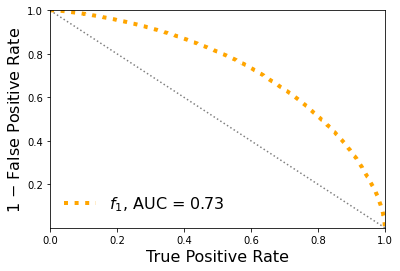

In [15]:
# PLOT THE ROC WITH AUC
plt.plot(tpr_gauss_xg_ll, 1 - fpr_gauss_xg_ll, label = "$f_{1}$, AUC = %0.2f" % roc_auc_xg_ll, color = "orange", ls = ":", lw = 4)
plt.plot([1,0], [0,1], ls = ":", color = "grey")
plt.xlabel("True Positive Rate", fontsize = 16)
plt.ylabel("1 $-$ False Positive Rate", fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.])
plt.legend(frameon=False, fontsize=16)

### Let's estimate the significance

Classification score:


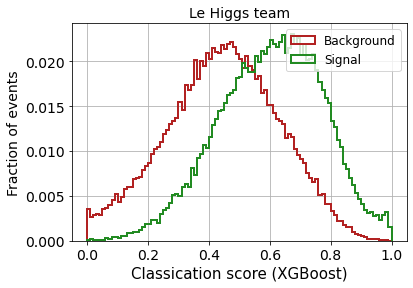

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  4.252502999193705

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  4.408174299108153

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  4.415524676663472

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  4.428866624418218

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf  1178.84295395  1168.98460769  1136.80376098
  1030.30008086   671.10279583  -273.97667761 -1830.56528363]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.059027261020128646, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf  1485.5929637
  1482.7266387   1476.23379769  1463.57967426  1429.88691965
  1303.71226404   869.70739529  -183.09506281 -1799.80296739]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


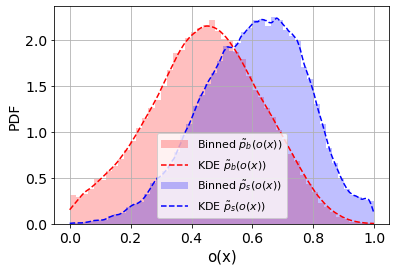

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  2000

 If  2060  =  374    then the proposed range has to be extended
n_ensembles (actual):  1668

 This may take long... 



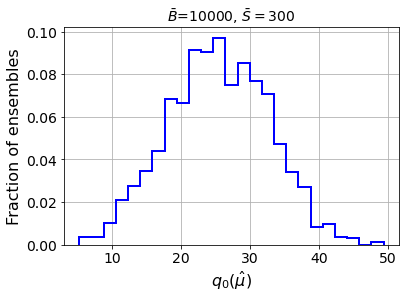

muhat mean:  0.02053357314148681
median q_muhat_KDE:  25.365171695948106
Z_KDE:  5.036384784341652
Z_KDE mu=0:  5.036384784341652

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  4.252502999193705
Z_XG 25 bins:  4.408174299108153
Z_XG 50 bins:  4.415524676663472
Z_XG 100 bins:  4.428866624418218

 ----------------------------------------- 

muhat mean:  0.02053357314148681
median q_muhat_KDE:  25.365171695948106
Z_KDE:  5.036384784341652
Z_KDE mu=0:  5.036384784341652


In [16]:
##############
# PARAMETERS #
##############

# requested number of ensembles
n_ensembles = 2000

# number of expected background events per ensemble
B_expected = 10000

# S_expected:
S_expected = 300

# SOME USEFUL DERIVATED PARAMETERS (maybe not used?):

# ratio S_expected/B_expected (signal ratio)
SB_ratio = 0.1

# S/\sqrt{B}
SsqrtB = S_expected / (B_expected)**0.5

store_Z_bins_XG_10bins_ll = []
store_Z_bins_XG_25bins_ll = []
store_Z_bins_XG_50bins_ll = []
store_Z_bins_XG_100bins_ll = []

store_muhat_mean_MLL_KDE_ll = []
store_Z_MLL_KDE_ll = []
store_Z_MLL_KDE_mu0 = []

# CHECKEAR QUE TENGAS #

X_gauss_train = trainset[:,1:]
Y_gauss_train = trainset[:,0]

X_gauss_val = valset[:,1:]
Y_gauss_val = valset[:,0]

X_gauss_test = testset[:,1:]
Y_gauss_test = testset[:,0]

y_pred_xg = y_pred_ll

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('Le Higgs team', fontsize=14)
plt.show()

##################################################
# CLASSIFIER OUTPUT BINNED POISON LOG-LIKELIHOOD #
##################################################

# 10 BINS

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)

# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig  = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(10), range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0
hist_back[np.where(hist_back == 0)[0]] = hist_back[np.argsort(hist_back)[1]]

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(10), range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_10bins = np.sqrt( 2* np.sum( (back_prom * np.log(back_prom / (sig_prom+back_prom))) + sig_prom ) )

store_Z_bins_XG_10bins_ll.append(Z_bins_XG_10bins)

print('Z_XG 10 bins: ', Z_bins_XG_10bins)
print('\n ----------------------------------------- \n')

##############################

# 25 BINS

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)


# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(25), range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
hist_back_noceros = []
for i in range(len(hist_back)):
    if hist_back[i]!=0:
        hist_back_noceros.append(hist_back[i])

min_back = min(hist_back_noceros)

# replace the zeros
for i in range(len(hist_back)):
    if hist_back[i]==0:
        hist_back[i] = min_back

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(25), range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_25bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_25bins_ll.append(Z_bins_XG_25bins)

print('Z_XG 25 bins: ', Z_bins_XG_25bins)
print('\n ----------------------------------------- \n')

#############################

# 50 BINS

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)


# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(50), range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
hist_back_noceros = []
for i in range(len(hist_back)):
    if hist_back[i]!=0:
        hist_back_noceros.append(hist_back[i])

min_back = min(hist_back_noceros)

# replace the zeros
for i in range(len(hist_back)):
    if hist_back[i]==0:
        hist_back[i] = min_back

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(50), range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_50bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_50bins_ll.append(Z_bins_XG_50bins)

print('Z_XG 50 bins: ', Z_bins_XG_50bins)
print('\n ----------------------------------------- \n')

##############################

# 100 BINS

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)


# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(100), range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
hist_back_noceros = []
for i in range(len(hist_back)):
    if hist_back[i]!=0:
        hist_back_noceros.append(hist_back[i])

min_back = min(hist_back_noceros)

# replace the zeros
for i in range(len(hist_back)):
    if hist_back[i]==0:
        hist_back[i] = min_back

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(100), range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_100bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_100bins_ll.append(Z_bins_XG_100bins)

print('Z_XG 100 bins: ', Z_bins_XG_100bins)
print('\n ----------------------------------------- \n')

#########
#  KDE  #
#########  

print(' MLL + KDE ')

# FIND THE BANDWIDTH

bandwidth = np.logspace(-4.0, 0.05, 20)

kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_SM[:20000]])
print('Background: ', grid.best_estimator_)

SM_bandwidth = grid.best_estimator_.bandwidth

kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_NP[:20000]])
print('Signal: ', grid.best_estimator_)

NP_bandwidth = grid.best_estimator_.bandwidth

# with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
# notice: epanechnikov kernel
kde_bkg = KernelDensity(kernel='epanechnikov', bandwidth=SM_bandwidth).fit(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ])
kde_sig = KernelDensity(kernel='epanechnikov', bandwidth=NP_bandwidth).fit(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ])

# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)

# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP

# plot to check the estimation

plt.figure()

plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
#plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{dim}$', fontsize=14)
#plt.savefig('images/' + 'Ndimgaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()

#############
# MLL + KDE #
#############
    
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

print('Evaluating the full test dataset with KDE (may take long...)')

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP

print('done')

indices = [i for i in range(len(KDE_NP_pred_SM))]

print('\n')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)

# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected

# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]

# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break

for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))

# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######

print('\n This may take long... \n')

# NOW LETS APPLY THE METHOD

muhat_selected_KDE_list = []
q_muhat_KDE = []
q_muhat_KDE_mu0 = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # KDE
        ran_ind = np.random.choice(indices, list_B_per_ensembles[bb])

        KDE_SM_pred_SM_shuf = []
        KDE_NP_pred_SM_shuf = []

        for i in ran_ind:
            KDE_SM_pred_SM_shuf.append(KDE_SM_pred_SM[i])
            KDE_NP_pred_SM_shuf.append(KDE_NP_pred_SM[i])

        KDE_SM_pred_SM_shuf  = np.array(KDE_SM_pred_SM_shuf)
        KDE_NP_pred_SM_shuf  = np.array(KDE_NP_pred_SM_shuf)

        # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

        # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )

        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
            
        sum_muhat_zero = sum ( [(x*1.) / ( (x * 0. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        # grid, mu_hat is around 1
        muhat_test = np.arange(0., 1., 0.05).tolist()

        muhat_selected_KDE = 0.0

        if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_KDE = muhat_test[vv]
                    break

        elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_KDE = muhat_test[vv]
                    break

        muhat_selected_KDE_list.append(muhat_selected_KDE)

        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
        # EXCLUSION:
        q_muhat_KDE.append( 2 * ( ( (1.-muhat_selected_KDE) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (muhat_selected_KDE*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
        q_muhat_KDE_mu0.append( 2 * ( ( (1.-0.) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (0.*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

# Histogram of q_muhats

weights = np.ones_like(q_muhat_KDE)/float(len(q_muhat_KDE))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_KDE, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

# Finally calculate muhat_mean and Z_gaussian

# Remove nan if any
q_muhat_KDE_mu0 = [x for x in q_muhat_KDE_mu0 if x == x]

q_muhat_KDE_median_mu0 = np.median(q_muhat_KDE_mu0)

Z_KDE_mu0 = abs(q_muhat_KDE_median_mu0)**0.5
store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

# Finally calculate muhat_mean and Z_gaussian
muhat_mean_MLL_KDE = np.mean(muhat_selected_KDE_list)
store_muhat_mean_MLL_KDE_ll.append(muhat_mean_MLL_KDE)

# Remove nan if any
q_muhat_KDE = [x for x in q_muhat_KDE if x == x]

q_muhat_KDE_median = np.median(q_muhat_KDE)

Z_KDE_ll = abs(q_muhat_KDE_median)**0.5
store_Z_MLL_KDE_ll.append(Z_KDE_ll)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('median q_muhat_KDE: ', q_muhat_KDE_median)
print('Z_KDE: ', Z_KDE_ll)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n -------------------------------- \n')

print('RESULTS FOR:')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)
print('\n ----------------------------------------- \n')

print('Z_XG 10 bins: ', Z_bins_XG_10bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)
print('\n ----------------------------------------- \n')

print('muhat mean: ', muhat_mean_MLL_KDE)
print('median q_muhat_KDE: ', q_muhat_KDE_median)
print('Z_KDE: ', Z_KDE_ll)
print('Z_KDE mu=0: ', Z_KDE_mu0)

## 10ML

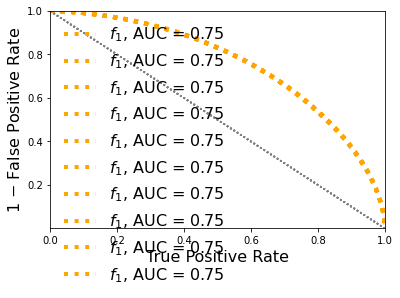

In [33]:
#######################
# CLASSIFIER: XGBoost #
#######################

# CLASSIFIER
classifier_ll = XGBClassifier(
    n_estimators          = 3500,
    learning_rate         = 0.1,
    reg_lambda            = 0.0,
    reg_alpha             = 0.0,
    gamma                 = 0.0,
    objective             = 'binary:logistic',
    eval_metric           = 'logloss',
    early_stopping_rounds = 50,
    max_depth             = 5)

# FIT
classifier_ll.fit(trainset[:70000,1:], trainset[:70000,0], 
               eval_set              = [(trainset[:70000,1:], trainset[:70000,0]), (valset[:,1:], valset[:,0])],
               verbose               = False)

# PREDICTIONS
y_pred_ll_aux0 = classifier_ll.predict_proba(testset[:,1:]).T[1]
y_pred_ll_aux = np.reshape(y_pred_ll_aux0, (1, len(y_pred_ll_aux0)))

# ROC
fpr_gauss_xg_ll, tpr_gauss_xg_ll, _ = roc_curve(testset[:,0], y_pred_ll_aux0)
roc_auc_xg_ll = auc(fpr_gauss_xg_ll, tpr_gauss_xg_ll)


# PLOT THE ROC WITH AUC
plt.plot(tpr_gauss_xg_ll, 1 - fpr_gauss_xg_ll, label = "$f_{1}$, AUC = %0.2f" % roc_auc_xg_ll, color = "orange", ls = ":", lw = 4)
plt.plot([1,0], [0,1], ls = ":", color = "grey")
plt.xlabel("True Positive Rate", fontsize = 16)
plt.ylabel("1 $-$ False Positive Rate", fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.])
plt.legend(frameon=False, fontsize=16)

for i in range(1, 10):
    # CLASSIFIER
    classifier_ll = XGBClassifier(
        n_estimators          = 3500,
        learning_rate         = 0.1,
        reg_lambda            = 0.0,
        reg_alpha             = 0.0,
        gamma                 = 0.0,
        objective             = 'binary:logistic',
        eval_metric           = 'logloss',
        early_stopping_rounds = 50,
        max_depth             = 5)

    # FIT
    classifier_ll.fit(trainset[(70000 * i): (70000 * (i + 1)),1:], trainset[(70000 * i): (70000 * (i + 1)),0], 
                   eval_set              = [(trainset[(70000 * i): (70000 * (i + 1)),1:], trainset[(70000 * i): (70000 * (i + 1)),0]), (valset[:,1:], valset[:,0])],
                   verbose               = False)

    # PREDICTIONS
    y_pred_ll_aux_it0 = classifier_ll.predict_proba(testset[:,1:]).T[1]
    y_pred_ll_aux_it = np.reshape(y_pred_ll_aux_it0, (1, len(y_pred_ll_aux_it0)))
    y_pred_ll_aux = np.concatenate((y_pred_ll_aux, y_pred_ll_aux_it))

    # ROC
    fpr_gauss_xg_ll, tpr_gauss_xg_ll, _ = roc_curve(testset[:,0], y_pred_ll_aux_it0)
    roc_auc_xg_ll = auc(fpr_gauss_xg_ll, tpr_gauss_xg_ll)
    
    # PLOT THE ROC WITH AUC
    plt.plot(tpr_gauss_xg_ll, 1 - fpr_gauss_xg_ll, label = "$f_{1}$, AUC = %0.2f" % roc_auc_xg_ll, color = "orange", ls = ":", lw = 4)
    plt.plot([1,0], [0,1], ls = ":", color = "grey")
    plt.xlabel("True Positive Rate", fontsize = 16)
    plt.ylabel("1 $-$ False Positive Rate", fontsize=16)
    plt.legend()    
    plt.xlim([0,1])
    plt.ylim([0,1]) 
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.])
    plt.legend(frameon=False, fontsize=16)
    
y_pred_ll_10 = np.mean(y_pred_ll_aux, axis = 0)

### Let's estimate the significance

Classification score:


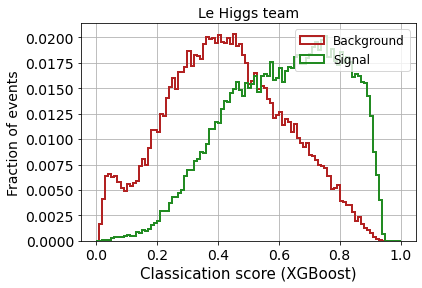

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  4.7616467328942775

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  4.87179250187229

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  4.88791529053975

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  4.910888772745721

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  4.252856802439291

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  4.4965645907376395

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf   994.66003044  1010.14076743
  1019.70927355  1024.6753265   1025.74359634  1023.80925521
  1018.51444645  1005.39252981   977.87554184   930.91312128
   822.20359285   496.27608856  -359.21267334 -1859.19911784]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf  1362.47092793  1365.57051762  1365.61939406
  1361.0783387   1343.80329662  1301.64349953  1214.62227781
  1024.51012542   611.10650645  -295.76338024 -1837.70454608]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


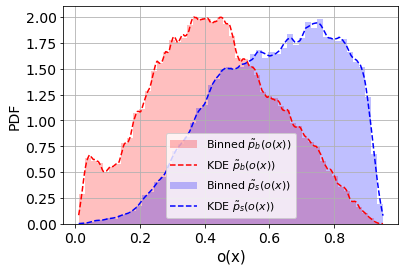

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  2000

 If  2060  =  374    then the proposed range has to be extended
n_ensembles (actual):  1668

 This may take long... 



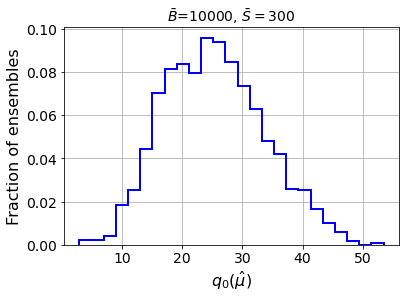

muhat mean:  0.06921462829736211
median q_muhat_KDE:  25.026955660515682
Z_KDE:  5.002694839835394
Z_KDE mu=0:  5.002694839835394

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  4.7616467328942775
Z_XG 25 bins:  4.87179250187229
Z_XG 50 bins:  4.88791529053975
Z_XG 100 bins:  4.910888772745721

 ----------------------------------------- 

muhat mean:  0.06921462829736211
median q_muhat_KDE:  25.026955660515682
Z_KDE:  5.002694839835394
Z_KDE mu=0:  5.002694839835394


In [38]:
##############
# PARAMETERS #
##############

# requested number of ensembles
n_ensembles = 2000

# number of expected background events per ensemble
B_expected = 10000

# S_expected:
S_expected = 300

# SOME USEFUL DERIVATED PARAMETERS (maybe not used?):

# ratio S_expected/B_expected (signal ratio)
SB_ratio = 0.1

# S/\sqrt{B}
SsqrtB = S_expected / (B_expected)**0.5

store_Z_bins_XG_10bins_10ML_ll = []
store_Z_bins_XG_25bins_10ML_ll = []
store_Z_bins_XG_50bins_10ML_ll = []
store_Z_bins_XG_100bins_10ML_ll = []

store_Z_bins_XG_10bins_NL_ll = []
store_Z_bins_XG_25bins_NL_ll = []
store_Z_bins_XG_50bins_NL_ll = []
store_Z_bins_XG_100bins_NL_ll = []

store_muhat_mean_MLL_KDE_ll = []
store_Z_MLL_KDE_ll = []
store_Z_MLL_KDE_mu0 = []

# CHECKEAR QUE TENGAS #

X_gauss_train = trainset[:,1:]
Y_gauss_train = trainset[:,0]

X_gauss_val = valset[:,1:]
Y_gauss_val = valset[:,0]

X_gauss_test = testset[:,1:]
Y_gauss_test = testset[:,0]

y_pred_xg = y_pred_ll_10

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('Le Higgs team', fontsize=14)
plt.show()

##################################################
# CLASSIFIER OUTPUT BINNED POISON LOG-LIKELIHOOD #
##################################################

# 10 BINS

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)

# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig  = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(10), range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0
hist_back[np.where(hist_back == 0)[0]] = hist_back[np.argsort(hist_back)[1]]

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(10), range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_10bins_10ML = np.sqrt( 2* np.sum( (back_prom * np.log(back_prom / (sig_prom+back_prom))) + sig_prom ) )

store_Z_bins_XG_10bins_10ML_ll.append(Z_bins_XG_10bins_10ML)

print('Z_XG 10 bins: ', Z_bins_XG_10bins_10ML)
print('\n ----------------------------------------- \n')

##############################

# 25 BINS

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)


# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(25), range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
hist_back_noceros = []
for i in range(len(hist_back)):
    if hist_back[i]!=0:
        hist_back_noceros.append(hist_back[i])

min_back = min(hist_back_noceros)

# replace the zeros
for i in range(len(hist_back)):
    if hist_back[i]==0:
        hist_back[i] = min_back

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(25), range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_25bins_10ML = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_25bins_10ML_ll.append(Z_bins_XG_25bins_10ML)

print('Z_XG 25 bins: ', Z_bins_XG_25bins_10ML)
print('\n ----------------------------------------- \n')

#############################

# 50 BINS

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)


# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(50), range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
hist_back_noceros = []
for i in range(len(hist_back)):
    if hist_back[i]!=0:
        hist_back_noceros.append(hist_back[i])

min_back = min(hist_back_noceros)

# replace the zeros
for i in range(len(hist_back)):
    if hist_back[i]==0:
        hist_back[i] = min_back

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(50), range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_50bins_10ML = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_50bins_10ML_ll.append(Z_bins_XG_50bins_10ML)

print('Z_XG 50 bins: ', Z_bins_XG_50bins_10ML)
print('\n ----------------------------------------- \n')

##############################

# 100 BINS

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)


# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(100), range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
hist_back_noceros = []
for i in range(len(hist_back)):
    if hist_back[i]!=0:
        hist_back_noceros.append(hist_back[i])

min_back = min(hist_back_noceros)

# replace the zeros
for i in range(len(hist_back)):
    if hist_back[i]==0:
        hist_back[i] = min_back

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(100), range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_100bins_10ML = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_100bins_10ML_ll.append(Z_bins_XG_100bins_10ML)

print('Z_XG 100 bins: ', Z_bins_XG_100bins_10ML)
print('\n ----------------------------------------- \n')


# 10 BINS (NL)

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)

# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig  = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:
bin_edges_same = pd.qcut(pd.DataFrame(pred_XG_SM)[0], q = 10, precision=0, retbins = True)[1]

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=[bin_edges_same], range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0
hist_back[np.where(hist_back == 0)[0]] = hist_back[np.argsort(hist_back)[1]]

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=[bin_edges_same], range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_10bins_NL = np.sqrt( 2* np.sum( (back_prom * np.log(back_prom / (sig_prom+back_prom))) + sig_prom ) )

store_Z_bins_XG_10bins_NL_ll.append(Z_bins_XG_10bins_NL)

print('Z_XG 10 bins: ', Z_bins_XG_10bins_NL)
print('\n ----------------------------------------- \n')

##############################

# 25 BINS (NL)

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)


# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:
bin_edges_same = pd.qcut(pd.DataFrame(pred_XG_SM)[0], q = 25, precision=0, retbins = True)[1]

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=[bin_edges_same], range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
hist_back_noceros = []
for i in range(len(hist_back)):
    if hist_back[i]!=0:
        hist_back_noceros.append(hist_back[i])

min_back = min(hist_back_noceros)

# replace the zeros
for i in range(len(hist_back)):
    if hist_back[i]==0:
        hist_back[i] = min_back

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=[bin_edges_same], range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_25bins_NL = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_25bins_NL_ll.append(Z_bins_XG_25bins_NL)

print('Z_XG 25 bins: ', Z_bins_XG_25bins_NL)
print('\n ----------------------------------------- \n')

#############################

# 50 BINS (NL)

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)


# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:
bin_edges_same = pd.qcut(pd.DataFrame(pred_XG_SM)[0], q = 50, precision=0, retbins = True)[1]

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=[bin_edges_same], range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
hist_back_noceros = []
for i in range(len(hist_back)):
    if hist_back[i]!=0:
        hist_back_noceros.append(hist_back[i])

min_back = min(hist_back_noceros)

# replace the zeros
for i in range(len(hist_back)):
    if hist_back[i]==0:
        hist_back[i] = min_back

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=[bin_edges_same], range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_50bins_NL = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_50bins_NL_ll.append(Z_bins_XG_50bins_NL)

print('Z_XG 50 bins: ', Z_bins_XG_50bins_NL)
print('\n ----------------------------------------- \n')

##############################

# 100 BINS (NL)

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)


# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:
bin_edges_same = pd.qcut(pd.DataFrame(pred_XG_SM)[0], q = 100, precision=0, retbins = True)[1]

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=[bin_edges_same], range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
hist_back_noceros = []
for i in range(len(hist_back)):
    if hist_back[i]!=0:
        hist_back_noceros.append(hist_back[i])

min_back = min(hist_back_noceros)

# replace the zeros
for i in range(len(hist_back)):
    if hist_back[i]==0:
        hist_back[i] = min_back

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=[bin_edges_same], range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_100bins_NL = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_100bins_NL_ll.append(Z_bins_XG_100bins_NL)

print('Z_XG 100 bins: ', Z_bins_XG_100bins_NL)
print('\n ----------------------------------------- \n')


#########
#  KDE  #
#########  

print(' MLL + KDE ')

# FIND THE BANDWIDTH

bandwidth = np.logspace(-4.0, 0.05, 20)

kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_SM[:20000]])
print('Background: ', grid.best_estimator_)

SM_bandwidth = grid.best_estimator_.bandwidth

kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_NP[:20000]])
print('Signal: ', grid.best_estimator_)

NP_bandwidth = grid.best_estimator_.bandwidth

# with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
# notice: epanechnikov kernel
kde_bkg = KernelDensity(kernel='epanechnikov', bandwidth=SM_bandwidth).fit(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ])
kde_sig = KernelDensity(kernel='epanechnikov', bandwidth=NP_bandwidth).fit(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ])

# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)

# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP

# plot to check the estimation

plt.figure()

plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
#plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{dim}$', fontsize=14)
#plt.savefig('images/' + 'Ndimgaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()

#############
# MLL + KDE #
#############
    
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

print('Evaluating the full test dataset with KDE (may take long...)')

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP

print('done')

indices = [i for i in range(len(KDE_NP_pred_SM))]

print('\n')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)

# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected

# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]

# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break

for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))

# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######

print('\n This may take long... \n')

# NOW LETS APPLY THE METHOD

muhat_selected_KDE_list = []
q_muhat_KDE = []
q_muhat_KDE_mu0 = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # KDE
        ran_ind = np.random.choice(indices, list_B_per_ensembles[bb])

        KDE_SM_pred_SM_shuf = []
        KDE_NP_pred_SM_shuf = []

        for i in ran_ind:
            KDE_SM_pred_SM_shuf.append(KDE_SM_pred_SM[i])
            KDE_NP_pred_SM_shuf.append(KDE_NP_pred_SM[i])

        KDE_SM_pred_SM_shuf  = np.array(KDE_SM_pred_SM_shuf)
        KDE_NP_pred_SM_shuf  = np.array(KDE_NP_pred_SM_shuf)

        # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

        # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )

        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
            
        sum_muhat_zero = sum ( [(x*1.) / ( (x * 0. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        # grid, mu_hat is around 1
        muhat_test = np.arange(0., 1., 0.05).tolist()

        muhat_selected_KDE = 0.0

        if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_KDE = muhat_test[vv]
                    break

        elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_KDE = muhat_test[vv]
                    break

        muhat_selected_KDE_list.append(muhat_selected_KDE)

        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
        # EXCLUSION:
        q_muhat_KDE.append( 2 * ( ( (1.-muhat_selected_KDE) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (muhat_selected_KDE*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
        q_muhat_KDE_mu0.append( 2 * ( ( (1.-0.) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (0.*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

# Histogram of q_muhats

weights = np.ones_like(q_muhat_KDE)/float(len(q_muhat_KDE))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_KDE, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

# Finally calculate muhat_mean and Z_gaussian

# Remove nan if any
q_muhat_KDE_mu0 = [x for x in q_muhat_KDE_mu0 if x == x]

q_muhat_KDE_median_mu0 = np.median(q_muhat_KDE_mu0)

Z_KDE_mu0 = abs(q_muhat_KDE_median_mu0)**0.5
store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

# Finally calculate muhat_mean and Z_gaussian
muhat_mean_MLL_KDE = np.mean(muhat_selected_KDE_list)
store_muhat_mean_MLL_KDE_ll.append(muhat_mean_MLL_KDE)

# Remove nan if any
q_muhat_KDE = [x for x in q_muhat_KDE if x == x]

q_muhat_KDE_median = np.median(q_muhat_KDE)

Z_KDE_ll = abs(q_muhat_KDE_median)**0.5
store_Z_MLL_KDE_ll.append(Z_KDE_ll)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('median q_muhat_KDE: ', q_muhat_KDE_median)
print('Z_KDE: ', Z_KDE_ll)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n -------------------------------- \n')

print('RESULTS FOR:')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)
print('\n ----------------------------------------- \n')

print('Z_XG 10 bins: ', Z_bins_XG_10bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)
print('\n ----------------------------------------- \n')

print('muhat mean: ', muhat_mean_MLL_KDE)
print('median q_muhat_KDE: ', q_muhat_KDE_median)
print('Z_KDE: ', Z_KDE_ll)
print('Z_KDE mu=0: ', Z_KDE_mu0)

# Let's train using all the high-level variables
Converging after ~850 iterations

In [17]:
# Let's create the training, testing and validation sets

ntrain = int(70 * nobs / 100)
nval   = int(20 * nobs / 100)
ntest  = int(10 * nobs / 100)
print('We will use ', str(ntrain), ' observations for training...')
print('We will use ', str(nval), ' observations for validation...')
print('We will use ', str(ntest), ' observations for testing...')

print('We will use ', features_names[-7:], ' for training')

trainset = data[:ntrain, [0,21,22,23,24,25,26,27]]
valset   = data[ntrain:(ntrain + nval), [0,21,22,23,24,25,26,27]]
testset  = data[(ntrain + nval):, [0,21,22,23,24,25,26,27]]

We will use  700000  observations for training...
We will use  200000  observations for validation...
We will use  100000  observations for testing...
We will use  ['m_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']  for training


## 1ML

In [18]:
#######################
# CLASSIFIER: XGBoost #
#######################

# CLASSIFIER
classifier_hl = XGBClassifier(
    n_estimators          = 1500,
    learning_rate         = 0.1,
    reg_lambda            = 0.0,
    reg_alpha             = 0.0,
    gamma                 = 0.0,
    objective             = 'binary:logistic',
    eval_metric           = 'logloss',
    early_stopping_rounds = 50,
    max_depth             = 5)

# FIT
classifier_hl.fit(trainset[:,1:], trainset[:,0], 
               eval_set              = [(trainset[:,1:], trainset[:,0]), (valset[:,1:], valset[:,0])],
               verbose               = False)

# PREDICTIONS
y_pred_hl = classifier_hl.predict_proba(testset[:,1:]).T[1]


# ROC
fpr_gauss_xg_hl, tpr_gauss_xg_hl, _ = roc_curve(testset[:,0], y_pred_hl)
roc_auc_xg_hl = auc(fpr_gauss_xg_hl, tpr_gauss_xg_hl)

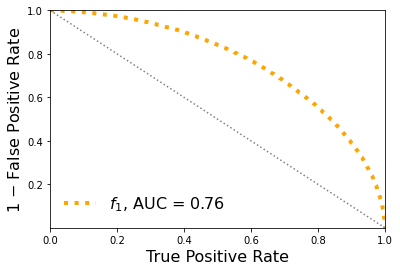

In [19]:
# PLOT THE ROC WITH AUC
plt.plot(tpr_gauss_xg_hl, 1 - fpr_gauss_xg_hl, label = "$f_{1}$, AUC = %0.2f" % roc_auc_xg_hl, color = "orange", ls = ":", lw = 4)
plt.plot([1,0], [0,1], ls = ":", color = "grey")
plt.xlabel("True Positive Rate", fontsize = 16)
plt.ylabel("1 $-$ False Positive Rate", fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.])
plt.legend(frameon=False, fontsize=16)

### Let's estimate the significance

Classification score:


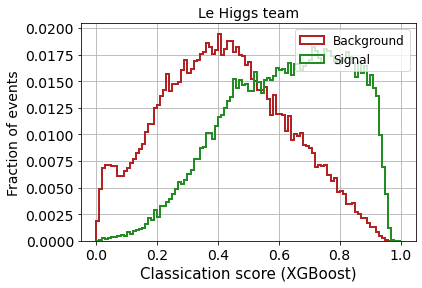

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  4.825308974325107

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  4.885765035957089

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  4.9312307141506375

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  4.957001492807316

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   816.77561079   818.15863081   818.53563808
   813.63180197   799.0389972    771.02849835   723.36740201
   620.05706308   325.941546    -451.59544017 -1890.45288204]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf  1144.39685495  1143.99254606
  1139.29149345  1121.07159962  1077.8219033    991.56908253
   815.35445634   440.49134634  -387.10589826 -1868.07333565]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


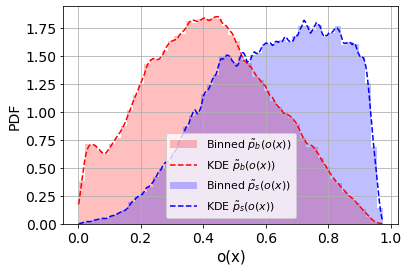

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  2000

 If  2060  =  374    then the proposed range has to be extended
n_ensembles (actual):  1668

 This may take long... 



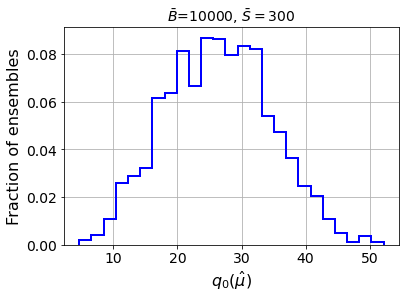

NameError: name 'store_Z_MLL_KDE' is not defined

In [22]:
##############
# PARAMETERS #
##############

# requested number of ensembles
n_ensembles = 2000

# number of expected background events per ensemble
B_expected = 10000

# S_expected:
S_expected = 300

# SOME USEFUL DERIVATED PARAMETERS (maybe not used?):

# ratio S_expected/B_expected (signal ratio)
SB_ratio = 0.1

# S/\sqrt{B}
SsqrtB = S_expected / (B_expected)**0.5

store_Z_bins_XG_10bins_hl = []
store_Z_bins_XG_25bins_hl = []
store_Z_bins_XG_50bins_hl = []
store_Z_bins_XG_100bins_hl = []

store_muhat_mean_MLL_KDE_hl = []
store_Z_MLL_KDE_hl = []
store_Z_MLL_KDE_mu0 = []

# CHECKEAR QUE TENGAS #

X_gauss_train = trainset[:,1:]
Y_gauss_train = trainset[:,0]

X_gauss_val = valset[:,1:]
Y_gauss_val = valset[:,0]

X_gauss_test = testset[:,1:]
Y_gauss_test = testset[:,0]

y_pred_xg = y_pred_hl

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('Le Higgs team', fontsize=14)
plt.show()

##################################################
# CLASSIFIER OUTPUT BINNED POISON LOG-LIKELIHOOD #
##################################################

# 10 BINS

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)

# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig  = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(10), range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0
hist_back[np.where(hist_back == 0)[0]] = hist_back[np.argsort(hist_back)[1]]

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(10), range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_10bins = np.sqrt( 2* np.sum( (back_prom * np.log(back_prom / (sig_prom+back_prom))) + sig_prom ) )

store_Z_bins_XG_10bins_hl.append(Z_bins_XG_10bins)

print('Z_XG 10 bins: ', Z_bins_XG_10bins)
print('\n ----------------------------------------- \n')

##############################

# 25 BINS

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)


# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(25), range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
hist_back_noceros = []
for i in range(len(hist_back)):
    if hist_back[i]!=0:
        hist_back_noceros.append(hist_back[i])

min_back = min(hist_back_noceros)

# replace the zeros
for i in range(len(hist_back)):
    if hist_back[i]==0:
        hist_back[i] = min_back

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(25), range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_25bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_25bins_hl.append(Z_bins_XG_25bins)

print('Z_XG 25 bins: ', Z_bins_XG_25bins)
print('\n ----------------------------------------- \n')

#############################

# 50 BINS

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)


# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(50), range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
hist_back_noceros = []
for i in range(len(hist_back)):
    if hist_back[i]!=0:
        hist_back_noceros.append(hist_back[i])

min_back = min(hist_back_noceros)

# replace the zeros
for i in range(len(hist_back)):
    if hist_back[i]==0:
        hist_back[i] = min_back

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(50), range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_50bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_50bins_hl.append(Z_bins_XG_50bins)

print('Z_XG 50 bins: ', Z_bins_XG_50bins)
print('\n ----------------------------------------- \n')

##############################

# 100 BINS

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)


# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(100), range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
hist_back_noceros = []
for i in range(len(hist_back)):
    if hist_back[i]!=0:
        hist_back_noceros.append(hist_back[i])

min_back = min(hist_back_noceros)

# replace the zeros
for i in range(len(hist_back)):
    if hist_back[i]==0:
        hist_back[i] = min_back

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(100), range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_100bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_100bins_hl.append(Z_bins_XG_100bins)

print('Z_XG 100 bins: ', Z_bins_XG_100bins)
print('\n ----------------------------------------- \n')

#########
#  KDE  #
#########  

print(' MLL + KDE ')

# FIND THE BANDWIDTH

bandwidth = np.logspace(-4.0, 0.05, 20)

kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_SM[:20000]])
print('Background: ', grid.best_estimator_)

SM_bandwidth = grid.best_estimator_.bandwidth

kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_NP[:20000]])
print('Signal: ', grid.best_estimator_)

NP_bandwidth = grid.best_estimator_.bandwidth

# with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
# notice: epanechnikov kernel
kde_bkg = KernelDensity(kernel='epanechnikov', bandwidth=SM_bandwidth).fit(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ])
kde_sig = KernelDensity(kernel='epanechnikov', bandwidth=NP_bandwidth).fit(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ])

# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)

# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP

# plot to check the estimation

plt.figure()

plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
#plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{dim}$', fontsize=14)
#plt.savefig('images/' + 'Ndimgaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()

#############
# MLL + KDE #
#############
    
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

print('Evaluating the full test dataset with KDE (may take long...)')

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP

print('done')

indices = [i for i in range(len(KDE_NP_pred_SM))]

print('\n')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)

# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected

# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]

# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break

for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))

# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######

print('\n This may take long... \n')

# NOW LETS APPLY THE METHOD

muhat_selected_KDE_list = []
q_muhat_KDE = []
q_muhat_KDE_mu0 = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # KDE
        ran_ind = np.random.choice(indices, list_B_per_ensembles[bb])

        KDE_SM_pred_SM_shuf = []
        KDE_NP_pred_SM_shuf = []

        for i in ran_ind:
            KDE_SM_pred_SM_shuf.append(KDE_SM_pred_SM[i])
            KDE_NP_pred_SM_shuf.append(KDE_NP_pred_SM[i])

        KDE_SM_pred_SM_shuf  = np.array(KDE_SM_pred_SM_shuf)
        KDE_NP_pred_SM_shuf  = np.array(KDE_NP_pred_SM_shuf)

        # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

        # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )

        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
            
        sum_muhat_zero = sum ( [(x*1.) / ( (x * 0. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        # grid, mu_hat is around 1
        muhat_test = np.arange(0., 1., 0.05).tolist()

        muhat_selected_KDE = 0.0

        if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_KDE = muhat_test[vv]
                    break

        elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_KDE = muhat_test[vv]
                    break

        muhat_selected_KDE_list.append(muhat_selected_KDE)

        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
        # EXCLUSION:
        q_muhat_KDE.append( 2 * ( ( (1.-muhat_selected_KDE) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (muhat_selected_KDE*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
        q_muhat_KDE_mu0.append( 2 * ( ( (1.-0.) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (0.*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

# Histogram of q_muhats

weights = np.ones_like(q_muhat_KDE)/float(len(q_muhat_KDE))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_KDE, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

# Finally calculate muhat_mean and Z_gaussian

# Remove nan if any
q_muhat_KDE_mu0 = [x for x in q_muhat_KDE_mu0 if x == x]

q_muhat_KDE_median_mu0 = np.median(q_muhat_KDE_mu0)

Z_KDE_mu0 = abs(q_muhat_KDE_median_mu0)**0.5
store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

# Finally calculate muhat_mean and Z_gaussian
muhat_mean_MLL_KDE = np.mean(muhat_selected_KDE_list)
store_muhat_mean_MLL_KDE_hl.append(muhat_mean_MLL_KDE)

# Remove nan if any
q_muhat_KDE = [x for x in q_muhat_KDE if x == x]

q_muhat_KDE_median = np.median(q_muhat_KDE)

Z_KDE_hl = abs(q_muhat_KDE_median)**0.5
store_Z_MLL_KDE.append(Z_KDE_hl)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('median q_muhat_KDE: ', q_muhat_KDE_median)
print('Z_KDE: ', Z_KDE_hl)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n -------------------------------- \n')

print('RESULTS FOR:')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)
print('\n ----------------------------------------- \n')

print('Z_XG 10 bins: ', Z_bins_XG_10bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)
print('\n ----------------------------------------- \n')

print('muhat mean: ', muhat_mean_MLL_KDE)
print('median q_muhat_KDE: ', q_muhat_KDE_median)
print('Z_KDE: ', Z_KDE_hl)
print('Z_KDE mu=0: ', Z_KDE_mu0)

## 10 ML

In [18]:
#######################
# CLASSIFIER: XGBoost #
#######################

# CLASSIFIER
classifier_hl = XGBClassifier(
    n_estimators          = 1500,
    learning_rate         = 0.1,
    reg_lambda            = 0.0,
    reg_alpha             = 0.0,
    gamma                 = 0.0,
    objective             = 'binary:logistic',
    eval_metric           = 'logloss',
    early_stopping_rounds = 50,
    max_depth             = 5)

# FIT
classifier_hl.fit(trainset[:,1:], trainset[:,0], 
               eval_set              = [(trainset[:,1:], trainset[:,0]), (valset[:,1:], valset[:,0])],
               verbose               = False)

# PREDICTIONS
y_pred_hl = classifier_hl.predict_proba(testset[:,1:]).T[1]


# ROC
fpr_gauss_xg_hl, tpr_gauss_xg_hl, _ = roc_curve(testset[:,0], y_pred_hl)
roc_auc_xg_hl = auc(fpr_gauss_xg_hl, tpr_gauss_xg_hl)

### Let's estimate the significance

Classification score:


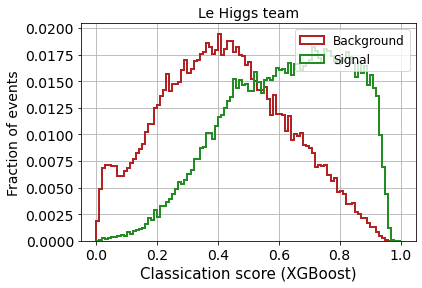

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  4.825308974325107

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  4.885765035957089

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  4.9312307141506375

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  4.957001492807316

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   816.77561079   818.15863081   818.53563808
   813.63180197   799.0389972    771.02849835   723.36740201
   620.05706308   325.941546    -451.59544017 -1890.45288204]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf  1144.39685495  1143.99254606
  1139.29149345  1121.07159962  1077.8219033    991.56908253
   815.35445634   440.49134634  -387.10589826 -1868.07333565]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


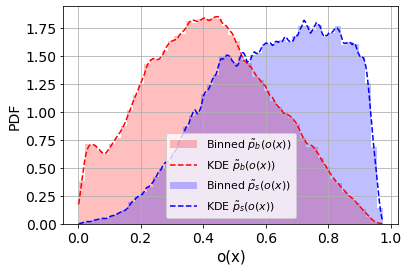

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  2000

 If  2060  =  374    then the proposed range has to be extended
n_ensembles (actual):  1668

 This may take long... 



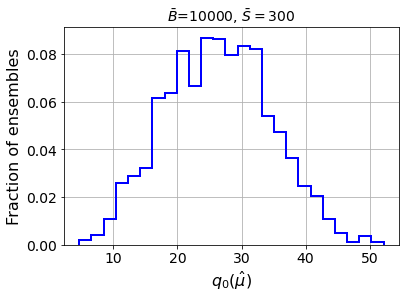

NameError: name 'store_Z_MLL_KDE' is not defined

In [22]:
##############
# PARAMETERS #
##############

# requested number of ensembles
n_ensembles = 2000

# number of expected background events per ensemble
B_expected = 10000

# S_expected:
S_expected = 300

# SOME USEFUL DERIVATED PARAMETERS (maybe not used?):

# ratio S_expected/B_expected (signal ratio)
SB_ratio = 0.1

# S/\sqrt{B}
SsqrtB = S_expected / (B_expected)**0.5

store_Z_bins_XG_10bins_hl = []
store_Z_bins_XG_25bins_hl = []
store_Z_bins_XG_50bins_hl = []
store_Z_bins_XG_100bins_hl = []

store_muhat_mean_MLL_KDE_hl = []
store_Z_MLL_KDE_hl = []
store_Z_MLL_KDE_mu0 = []

# CHECKEAR QUE TENGAS #

X_gauss_train = trainset[:,1:]
Y_gauss_train = trainset[:,0]

X_gauss_val = valset[:,1:]
Y_gauss_val = valset[:,0]

X_gauss_test = testset[:,1:]
Y_gauss_test = testset[:,0]

y_pred_xg = y_pred_hl

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('Le Higgs team', fontsize=14)
plt.show()

##################################################
# CLASSIFIER OUTPUT BINNED POISON LOG-LIKELIHOOD #
##################################################

# 10 BINS

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)

# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig  = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(10), range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0
hist_back[np.where(hist_back == 0)[0]] = hist_back[np.argsort(hist_back)[1]]

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(10), range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_10bins = np.sqrt( 2* np.sum( (back_prom * np.log(back_prom / (sig_prom+back_prom))) + sig_prom ) )

store_Z_bins_XG_10bins_hl.append(Z_bins_XG_10bins)

print('Z_XG 10 bins: ', Z_bins_XG_10bins)
print('\n ----------------------------------------- \n')

##############################

# 25 BINS

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)


# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(25), range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
hist_back_noceros = []
for i in range(len(hist_back)):
    if hist_back[i]!=0:
        hist_back_noceros.append(hist_back[i])

min_back = min(hist_back_noceros)

# replace the zeros
for i in range(len(hist_back)):
    if hist_back[i]==0:
        hist_back[i] = min_back

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(25), range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_25bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_25bins_hl.append(Z_bins_XG_25bins)

print('Z_XG 25 bins: ', Z_bins_XG_25bins)
print('\n ----------------------------------------- \n')

#############################

# 50 BINS

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)


# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(50), range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
hist_back_noceros = []
for i in range(len(hist_back)):
    if hist_back[i]!=0:
        hist_back_noceros.append(hist_back[i])

min_back = min(hist_back_noceros)

# replace the zeros
for i in range(len(hist_back)):
    if hist_back[i]==0:
        hist_back[i] = min_back

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(50), range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_50bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_50bins_hl.append(Z_bins_XG_50bins)

print('Z_XG 50 bins: ', Z_bins_XG_50bins)
print('\n ----------------------------------------- \n')

##############################

# 100 BINS

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)


# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(100), range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
hist_back_noceros = []
for i in range(len(hist_back)):
    if hist_back[i]!=0:
        hist_back_noceros.append(hist_back[i])

min_back = min(hist_back_noceros)

# replace the zeros
for i in range(len(hist_back)):
    if hist_back[i]==0:
        hist_back[i] = min_back

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(100), range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_100bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_100bins_hl.append(Z_bins_XG_100bins)

print('Z_XG 100 bins: ', Z_bins_XG_100bins)
print('\n ----------------------------------------- \n')

#########
#  KDE  #
#########  

print(' MLL + KDE ')

# FIND THE BANDWIDTH

bandwidth = np.logspace(-4.0, 0.05, 20)

kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_SM[:20000]])
print('Background: ', grid.best_estimator_)

SM_bandwidth = grid.best_estimator_.bandwidth

kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_NP[:20000]])
print('Signal: ', grid.best_estimator_)

NP_bandwidth = grid.best_estimator_.bandwidth

# with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
# notice: epanechnikov kernel
kde_bkg = KernelDensity(kernel='epanechnikov', bandwidth=SM_bandwidth).fit(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ])
kde_sig = KernelDensity(kernel='epanechnikov', bandwidth=NP_bandwidth).fit(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ])

# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)

# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP

# plot to check the estimation

plt.figure()

plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
#plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{dim}$', fontsize=14)
#plt.savefig('images/' + 'Ndimgaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()

#############
# MLL + KDE #
#############
    
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

print('Evaluating the full test dataset with KDE (may take long...)')

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP

print('done')

indices = [i for i in range(len(KDE_NP_pred_SM))]

print('\n')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)

# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected

# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]

# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break

for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))

# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######

print('\n This may take long... \n')

# NOW LETS APPLY THE METHOD

muhat_selected_KDE_list = []
q_muhat_KDE = []
q_muhat_KDE_mu0 = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # KDE
        ran_ind = np.random.choice(indices, list_B_per_ensembles[bb])

        KDE_SM_pred_SM_shuf = []
        KDE_NP_pred_SM_shuf = []

        for i in ran_ind:
            KDE_SM_pred_SM_shuf.append(KDE_SM_pred_SM[i])
            KDE_NP_pred_SM_shuf.append(KDE_NP_pred_SM[i])

        KDE_SM_pred_SM_shuf  = np.array(KDE_SM_pred_SM_shuf)
        KDE_NP_pred_SM_shuf  = np.array(KDE_NP_pred_SM_shuf)

        # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

        # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )

        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
            
        sum_muhat_zero = sum ( [(x*1.) / ( (x * 0. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        # grid, mu_hat is around 1
        muhat_test = np.arange(0., 1., 0.05).tolist()

        muhat_selected_KDE = 0.0

        if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_KDE = muhat_test[vv]
                    break

        elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_KDE = muhat_test[vv]
                    break

        muhat_selected_KDE_list.append(muhat_selected_KDE)

        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
        # EXCLUSION:
        q_muhat_KDE.append( 2 * ( ( (1.-muhat_selected_KDE) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (muhat_selected_KDE*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
        q_muhat_KDE_mu0.append( 2 * ( ( (1.-0.) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (0.*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

# Histogram of q_muhats

weights = np.ones_like(q_muhat_KDE)/float(len(q_muhat_KDE))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_KDE, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

# Finally calculate muhat_mean and Z_gaussian

# Remove nan if any
q_muhat_KDE_mu0 = [x for x in q_muhat_KDE_mu0 if x == x]

q_muhat_KDE_median_mu0 = np.median(q_muhat_KDE_mu0)

Z_KDE_mu0 = abs(q_muhat_KDE_median_mu0)**0.5
store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

# Finally calculate muhat_mean and Z_gaussian
muhat_mean_MLL_KDE = np.mean(muhat_selected_KDE_list)
store_muhat_mean_MLL_KDE_hl.append(muhat_mean_MLL_KDE)

# Remove nan if any
q_muhat_KDE = [x for x in q_muhat_KDE if x == x]

q_muhat_KDE_median = np.median(q_muhat_KDE)

Z_KDE_hl = abs(q_muhat_KDE_median)**0.5
store_Z_MLL_KDE.append(Z_KDE_hl)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('median q_muhat_KDE: ', q_muhat_KDE_median)
print('Z_KDE: ', Z_KDE_hl)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n -------------------------------- \n')

print('RESULTS FOR:')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)
print('\n ----------------------------------------- \n')

print('Z_XG 10 bins: ', Z_bins_XG_10bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)
print('\n ----------------------------------------- \n')

print('muhat mean: ', muhat_mean_MLL_KDE)
print('median q_muhat_KDE: ', q_muhat_KDE_median)
print('Z_KDE: ', Z_KDE_hl)
print('Z_KDE mu=0: ', Z_KDE_mu0)

# Let's train using all the variables
Converging after ~1500 iterations with a val loss of ~0.50994

In [9]:
# Let's create the training, testing and validation sets

ntrain = int(70 * nobs / 100)
nval   = int(20 * nobs / 100)
ntest  = int(10 * nobs / 100)
print('We will use ', str(ntrain), ' observations for training...')
print('We will use ', str(nval), ' observations for validation...')
print('We will use ', str(ntest), ' observations for testing...')

print('We will use ', features_names[1:], ' for training')

trainset = data[:ntrain, :]
valset   = data[ntrain:(ntrain + nval), :]
testset  = data[(ntrain + nval):, :]

We will use  700000  observations for training...
We will use  200000  observations for validation...
We will use  100000  observations for testing...
We will use  ['lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']  for training


In [10]:
#######################
# CLASSIFIER: XGBoost #
#######################

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators          = 2500,
    learning_rate         = 0.1,
    reg_lambda            = 0.0,
    reg_alpha             = 0.0,
    gamma                 = 0.0,
    objective             = 'binary:logistic',
    eval_metric           = 'logloss',
    early_stopping_rounds = 50,
    max_depth             = 5)

# FIT
classifier.fit(trainset[:,1:], trainset[:,0], 
               eval_set              = [(trainset[:,1:], trainset[:,0]), (valset[:,1:], valset[:,0])],
               verbose               = False)

# PREDICTIONS
y_pred = classifier.predict_proba(testset[:,1:]).T[1]


# ROC
fpr_gauss_xg, tpr_gauss_xg, _ = roc_curve(testset[:,0], y_pred)
roc_auc_xg = auc(fpr_gauss_xg, tpr_gauss_xg)
print(roc_auc_xg)

0.8259154885267312


0.8259154885267312
0.821215386936984
0.820024580391683
0.8209381753713942
0.8189505428469533
0.8210734478023429
0.8212226762036348
0.8208310106240808
0.8186837692992026
0.8200770055731788


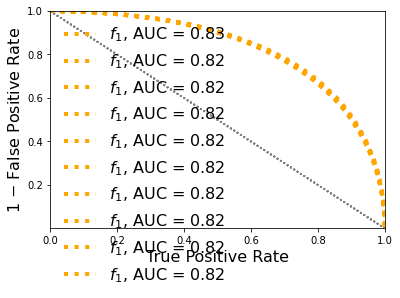

In [11]:
#######################
# CLASSIFIER: XGBoost #
#######################
classifiers = []
# CLASSIFIER
classifier = XGBClassifier(
    n_estimators          = 3500,
    learning_rate         = 0.1,
    reg_lambda            = 0.0,
    reg_alpha             = 0.0,
    gamma                 = 0.0,
    objective             = 'binary:logistic',
    eval_metric           = 'logloss',
    early_stopping_rounds = 50,
    max_depth             = 5)

# FIT

classifier.fit(trainset[:,1:], trainset[:,0], 
               eval_set              = [(trainset[:,1:], trainset[:,0]), (valset[:,1:], valset[:,0])],
               verbose               = False)

classifiers.append(classifier)
# PREDICTIONS
y_pred_aux0 = classifier.predict_proba(testset[:,1:]).T[1]
y_pred_aux = np.reshape(y_pred_aux0, (1, len(y_pred_aux0)))

# ROC
fpr_gauss_xg_10, tpr_gauss_xg_10, _ = roc_curve(testset[:,0], y_pred_aux0)
roc_auc_xg_10 = auc(fpr_gauss_xg_10, tpr_gauss_xg_10)

print(roc_auc_xg_10)

# PLOT THE ROC WITH AUC
plt.plot(tpr_gauss_xg_10, 1 - fpr_gauss_xg_10, label = "$f_{1}$, AUC = %0.2f" % roc_auc_xg, color = "orange", ls = ":", lw = 4)
plt.plot([1,0], [0,1], ls = ":", color = "grey")
plt.xlabel("True Positive Rate", fontsize = 16)
plt.ylabel("1 $-$ False Positive Rate", fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.])
plt.legend(frameon=False, fontsize=16)

for i in range(1, 10):
    # CLASSIFIER
    classifier = XGBClassifier(
        n_estimators          = 3500,
        learning_rate         = 0.1,
        reg_lambda            = 0.0,
        reg_alpha             = 0.0,
        gamma                 = 0.0,
        objective             = 'binary:logistic',
        eval_metric           = 'logloss',
        early_stopping_rounds = 50,
        max_depth             = 5)

    ran_ind = np.random.choice(np.arange(len(trainset)), size = len(trainset), replace = True)

    classifier.fit(trainset[ran_ind,1:], trainset[ran_ind,0], 
                   eval_set              = [(trainset[ran_ind,1:], trainset[ran_ind,0]), (valset[:,1:], valset[:,0])],
                   verbose               = False)
    
    classifiers.append(classifier)

    # PREDICTIONS
    y_pred_aux_it0 = classifier.predict_proba(testset[:,1:]).T[1]
    y_pred_aux_it = np.reshape(y_pred_aux_it0, (1, len(y_pred_aux_it0)))
    y_pred_aux = np.concatenate((y_pred_aux, y_pred_aux_it))

    # ROC
    fpr_gauss_xg_10, tpr_gauss_xg_10, _ = roc_curve(testset[:,0], y_pred_aux_it0)
    roc_auc_xg_10 = auc(fpr_gauss_xg_10, tpr_gauss_xg_10)
    
    print(roc_auc_xg_10)
    # PLOT THE ROC WITH AUC
    plt.plot(tpr_gauss_xg_10, 1 - fpr_gauss_xg_10, label = "$f_{1}$, AUC = %0.2f" % roc_auc_xg_10, color = "orange", ls = ":", lw = 4)
    plt.plot([1,0], [0,1], ls = ":", color = "grey")
    plt.xlabel("True Positive Rate", fontsize = 16)
    plt.ylabel("1 $-$ False Positive Rate", fontsize=16)
    plt.legend()    
    plt.xlim([0,1])
    plt.ylim([0,1]) 
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.])
    plt.legend(frameon=False, fontsize=16)
    
y_pred_10 = np.mean(y_pred_aux, axis = 0)
fpr_gauss_xg_10, tpr_gauss_xg_10, _ = roc_curve(testset[:,0], y_pred_10)
roc_auc_xg_10 = auc(fpr_gauss_xg_10, tpr_gauss_xg_10)

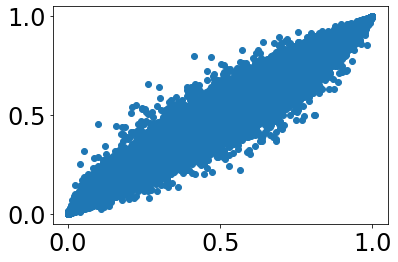

In [84]:
plt.plot(y_pred, y_pred_10, 'o', rasterized = True)

In [79]:
SMALL_SIZE  = 14
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size        = SMALL_SIZE)     # controls default text sizes
plt.rc('axes', titlesize   = BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize   = 28)             # fontsize of the x and y labels
plt.rc('xtick', labelsize  = BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize  = BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize  = MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize = BIGGER_SIZE)

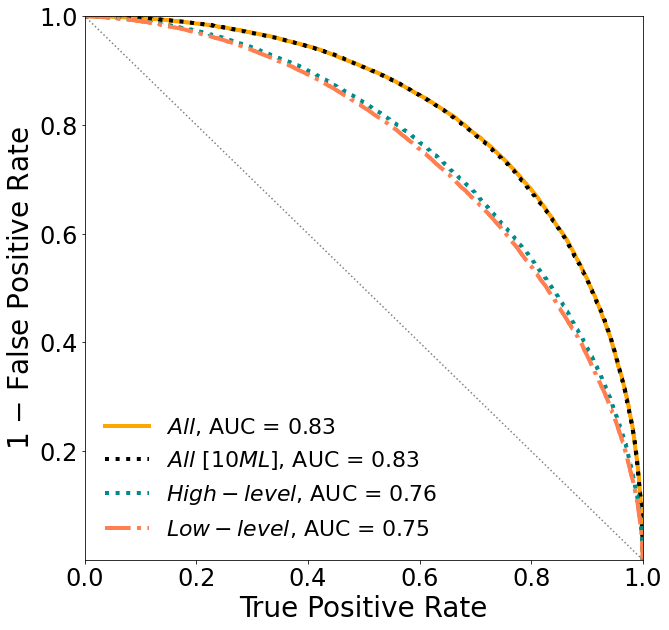

In [86]:
# PLOT THE ROC WITH AUC
plt.figure(figsize=(10,10))
plt.plot(tpr_gauss_xg, 1 - fpr_gauss_xg, label = "$All$, AUC = %0.2f" % roc_auc_xg, color = "orange", ls = "solid", lw = 4)
plt.plot(tpr_gauss_xg_10, 1 - fpr_gauss_xg_10, label = "$All\ [10ML]$, AUC = %0.2f" % roc_auc_xg_10, color = "black", ls = ":", lw = 4)
plt.plot(tpr_gauss_xg_hl, 1 - fpr_gauss_xg_hl, label = "$High-level$, AUC = %0.2f" % roc_auc_xg_hl, color = "darkcyan", ls = ":", lw = 4)
plt.plot(tpr_gauss_xg_ll, 1 - fpr_gauss_xg_ll, label = "$Low-level$, AUC = %0.2f" % roc_auc_xg_ll, color = "coral", ls = "-.", lw = 4)
plt.plot([1,0], [0,1], ls = ":", color = "grey")
plt.xlabel("True Positive Rate")
plt.ylabel("1 $-$ False Positive Rate")
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.])
plt.legend(frameon=False)
#plt.savefig('../graph/ROC_higgs_1M_10.pdf')

## Let's estimate the exclusion significance

Classification score:


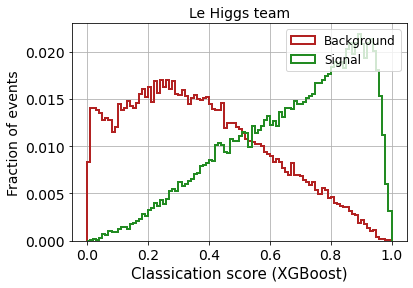

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.042547819800469

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.42952614831634

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.455401275156541

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.532448511188474

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   635.78714706   640.60706211   639.34873519   632.38751317
   618.29614214   590.79649655   544.2644849    466.9608724
   323.48577829    16.98455076  -654.19243916 -1959.17842556]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf   974.88663192
   965.89223186   941.18552703   883.92368261   770.29889522
   553.80492221   162.41327043  -569.60781297 -1928.39643306]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


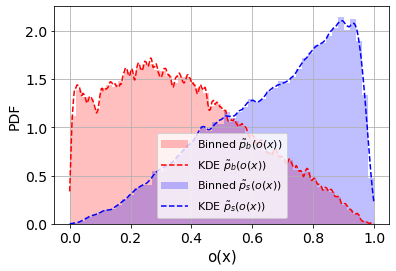

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  2000

 If  2060  =  374    then the proposed range has to be extended
n_ensembles (actual):  1668

 This may take long... 



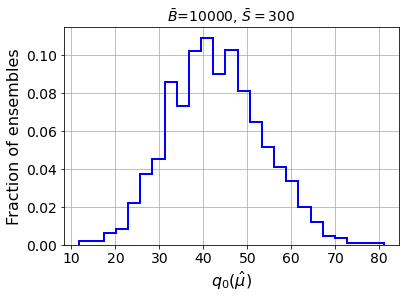

muhat mean:  0.04895083932853717
median q_muhat_KDE:  42.47388825597079
Z_KDE:  6.517199418152769
Z_KDE mu=0:  6.519163730229444

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.042547819800469
Z_XG 25 bins:  6.42952614831634
Z_XG 50 bins:  6.455401275156541
Z_XG 100 bins:  6.532448511188474

 ----------------------------------------- 

muhat mean:  0.04895083932853717
median q_muhat_KDE:  42.47388825597079
Z_KDE:  6.517199418152769
Z_KDE mu=0:  6.519163730229444


In [19]:
##############
# PARAMETERS #
##############

# requested number of ensembles
n_ensembles = 2000

# number of expected background events per ensemble
B_expected = 10000

# S_expected:
S_expected = 300

# SOME USEFUL DERIVATED PARAMETERS (maybe not used?):

# ratio S_expected/B_expected (signal ratio)
SB_ratio = 0.1

# S/\sqrt{B}
SsqrtB = S_expected / (B_expected)**0.5

store_Z_bins_XG_10bins = []
store_Z_bins_XG_25bins = []
store_Z_bins_XG_50bins = []
store_Z_bins_XG_100bins = []

store_muhat_mean_MLL_KDE = []
store_Z_MLL_KDE = []
store_Z_MLL_KDE_mu0 = []

# CHECKEAR QUE TENGAS #

X_gauss_train = trainset[:,1:]
Y_gauss_train = trainset[:,0]

X_gauss_val = valset[:,1:]
Y_gauss_val = valset[:,0]

X_gauss_test = testset[:,1:]
Y_gauss_test = testset[:,0]

#y_pred_xg = y_pred
y_pred_xg = y_pred_10 # For smooth

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('Le Higgs team', fontsize=14)
plt.show()

##################################################
# CLASSIFIER OUTPUT BINNED POISON LOG-LIKELIHOOD #
##################################################

# 10 BINS

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)

# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig  = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(10), range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0
hist_back[np.where(hist_back == 0)[0]] = hist_back[np.argsort(hist_back)[1]]

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(10), range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_10bins = np.sqrt( 2* np.sum( (back_prom * np.log(back_prom / (sig_prom+back_prom))) + sig_prom ) )

store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)

print('Z_XG 10 bins: ', Z_bins_XG_10bins)
print('\n ----------------------------------------- \n')

##############################

# 25 BINS

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)


# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(25), range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
hist_back_noceros = []
for i in range(len(hist_back)):
    if hist_back[i]!=0:
        hist_back_noceros.append(hist_back[i])

min_back = min(hist_back_noceros)

# replace the zeros
for i in range(len(hist_back)):
    if hist_back[i]==0:
        hist_back[i] = min_back

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(25), range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_25bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)

print('Z_XG 25 bins: ', Z_bins_XG_25bins)
print('\n ----------------------------------------- \n')

#############################

# 50 BINS

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)


# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(50), range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
hist_back_noceros = []
for i in range(len(hist_back)):
    if hist_back[i]!=0:
        hist_back_noceros.append(hist_back[i])

min_back = min(hist_back_noceros)

# replace the zeros
for i in range(len(hist_back)):
    if hist_back[i]==0:
        hist_back[i] = min_back

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(50), range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_50bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)

print('Z_XG 50 bins: ', Z_bins_XG_50bins)
print('\n ----------------------------------------- \n')

##############################

# 100 BINS

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)


# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(100), range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
hist_back_noceros = []
for i in range(len(hist_back)):
    if hist_back[i]!=0:
        hist_back_noceros.append(hist_back[i])

min_back = min(hist_back_noceros)

# replace the zeros
for i in range(len(hist_back)):
    if hist_back[i]==0:
        hist_back[i] = min_back

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(100), range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_100bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)

print('Z_XG 100 bins: ', Z_bins_XG_100bins)
print('\n ----------------------------------------- \n')

#########
#  KDE  #
#########  

print(' MLL + KDE ')

# FIND THE BANDWIDTH

bandwidth = np.logspace(-4.0, 0.05, 20)

kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_SM[:20000]])
print('Background: ', grid.best_estimator_)

SM_bandwidth = grid.best_estimator_.bandwidth

kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_NP[:20000]])
print('Signal: ', grid.best_estimator_)

NP_bandwidth = grid.best_estimator_.bandwidth

# with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
# notice: epanechnikov kernel
kde_bkg = KernelDensity(kernel='epanechnikov', bandwidth=SM_bandwidth).fit(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ])
kde_sig = KernelDensity(kernel='epanechnikov', bandwidth=NP_bandwidth).fit(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ])

# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)

# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP

# plot to check the estimation

plt.figure()

plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
#plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{dim}$', fontsize=14)
#plt.savefig('images/' + 'Ndimgaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()

#############
# MLL + KDE #
#############
    
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

print('Evaluating the full test dataset with KDE (may take long...)')

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP

print('done')

indices = [i for i in range(len(KDE_NP_pred_SM))]

print('\n')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)
print('n_ensembles (initial): ', n_ensembles)

# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected

# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]

# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break

for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))

# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######

print('\n This may take long... \n')

# NOW LETS APPLY THE METHOD

muhat_selected_KDE_list = []
q_muhat_KDE = []
q_muhat_KDE_mu0 = []

for bb in range(len(list_nums_ensembles)):

    for kk in range(list_nums_ensembles[bb]):

        # KDE
        ran_ind = np.random.choice(indices, list_B_per_ensembles[bb])

        KDE_SM_pred_SM_shuf = []
        KDE_NP_pred_SM_shuf = []

        for i in ran_ind:
            KDE_SM_pred_SM_shuf.append(KDE_SM_pred_SM[i])
            KDE_NP_pred_SM_shuf.append(KDE_NP_pred_SM[i])

        KDE_SM_pred_SM_shuf  = np.array(KDE_SM_pred_SM_shuf)
        KDE_NP_pred_SM_shuf  = np.array(KDE_NP_pred_SM_shuf)

        # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

        # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )

        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
            
        sum_muhat_zero = sum ( [(x*1.) / ( (x * 0. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        # grid, mu_hat is around 1
        muhat_test = np.arange(0., 1., 0.05).tolist()

        muhat_selected_KDE = 0.0

        if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_KDE = muhat_test[vv]
                    break

        elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_KDE = muhat_test[vv]
                    break

        muhat_selected_KDE_list.append(muhat_selected_KDE)

        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
        # EXCLUSION:
        q_muhat_KDE.append( 2 * ( ( (1.-muhat_selected_KDE) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (muhat_selected_KDE*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
        q_muhat_KDE_mu0.append( 2 * ( ( (1.-0.) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (0.*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

# Histogram of q_muhats

weights = np.ones_like(q_muhat_KDE)/float(len(q_muhat_KDE))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_KDE, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

# Finally calculate muhat_mean and Z_gaussian

# Remove nan if any
q_muhat_KDE_mu0 = [x for x in q_muhat_KDE_mu0 if x == x]

q_muhat_KDE_median_mu0 = np.median(q_muhat_KDE_mu0)

Z_KDE_mu0 = abs(q_muhat_KDE_median_mu0)**0.5
store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

# Finally calculate muhat_mean and Z_gaussian
muhat_mean_MLL_KDE = np.mean(muhat_selected_KDE_list)
store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)

# Remove nan if any
q_muhat_KDE = [x for x in q_muhat_KDE if x == x]

q_muhat_KDE_median = np.median(q_muhat_KDE)

Z_KDE = abs(q_muhat_KDE_median)**0.5
store_Z_MLL_KDE.append(Z_KDE)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('median q_muhat_KDE: ', q_muhat_KDE_median)
print('Z_KDE: ', Z_KDE)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n -------------------------------- \n')

print('RESULTS FOR:')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)
print('\n ----------------------------------------- \n')

print('Z_XG 10 bins: ', Z_bins_XG_10bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)
print('\n ----------------------------------------- \n')

print('muhat mean: ', muhat_mean_MLL_KDE)
print('median q_muhat_KDE: ', q_muhat_KDE_median)
print('Z_KDE: ', Z_KDE)
print('Z_KDE mu=0: ', Z_KDE_mu0)

### Let's see what happens when varying B

In [ ]:
##############
# PARAMETERS #
##############

# requested number of ensembles
n_ensembles = 2000

# number of expected background events per ensemble
#B_expected = 1000

for B_expected in [100, 1000, 10000, 50000]:
    # S_expected:
    S_expected = 100

    # SOME USEFUL DERIVATED PARAMETERS (maybe not used?):

    # ratio S_expected/B_expected (signal ratio)
    SB_ratio = 0.1

    # S/\sqrt{B}
    SsqrtB = S_expected / (B_expected)**0.5

    store_Z_bins_XG_10bins = []
    store_Z_bins_XG_25bins = []
    store_Z_bins_XG_50bins = []
    store_Z_bins_XG_100bins = []

    store_muhat_mean_MLL_KDE = []
    store_Z_MLL_KDE = []
    store_Z_MLL_KDE_mu0 = []

    # CHECKEAR QUE TENGAS #

    X_gauss_train = trainset[:,1:]
    Y_gauss_train = trainset[:,0]

    X_gauss_val = valset[:,1:]
    Y_gauss_val = valset[:,0]

    X_gauss_test = testset[:,1:]
    Y_gauss_test = testset[:,0]

    y_pred_xg = y_pred

    ########################
    # CLASSIFICATION SCORE #
    ########################

    # Outputs for validation data set

    pred_XG_SM = []
    pred_XG_NP = []

    for i in range(len(Y_gauss_test)):
        if Y_gauss_test[i] == 0:
            pred_XG_SM.append(y_pred_xg[i])
        else:
            pred_XG_NP.append(y_pred_xg[i])


    print('Classification score:')

    weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
    nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

    weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
    nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Classication score (XGBoost)",fontsize=15)
    plt.ylabel("Fraction of events",fontsize=14)
    plt.grid()
    plt.legend(fontsize=12)
    plt.title('Le Higgs team', fontsize=14)
    plt.show()

    ##################################################
    # CLASSIFIER OUTPUT BINNED POISON LOG-LIKELIHOOD #
    ##################################################

    # 10 BINS

    print('BINNED CLASSIFIER OUTPUT')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)

    # Les't find the number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_ensembles_sig  = len(pred_XG_NP) / S_expected

    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(10), range = [[0,1]])

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0
    hist_back[np.where(hist_back == 0)[0]] = hist_back[np.argsort(hist_back)[1]]

    # now divide by the number of possible ensembles
    back_prom = hist_back/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(10), range = [[0,1]])
    sig_prom = hist_sig/N_ensembles_sig

    # then the signif Z^binned-Asimov:
    Z_bins_XG_10bins = np.sqrt( 2* np.sum( (back_prom * np.log(back_prom / (sig_prom+back_prom))) + sig_prom ) )

    store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)

    print('Z_XG 10 bins: ', Z_bins_XG_10bins)
    print('\n ----------------------------------------- \n')

    ##############################

    # 25 BINS

    print('BINNED CLASSIFIER OUTPUT')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)


    # Les't find the number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_ensembles_sig = len(pred_XG_NP) / S_expected

    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(25), range = [[0,1]])

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    hist_back_noceros = []
    for i in range(len(hist_back)):
        if hist_back[i]!=0:
            hist_back_noceros.append(hist_back[i])

    min_back = min(hist_back_noceros)

    # replace the zeros
    for i in range(len(hist_back)):
        if hist_back[i]==0:
            hist_back[i] = min_back

    # now divide by the number of possible ensembles
    back_prom = hist_back/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(25), range = [[0,1]])
    sig_prom = hist_sig/N_ensembles_sig

    # then the signif Z^binned-Asimov:
    Z_bins_XG_25bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)

    print('Z_XG 25 bins: ', Z_bins_XG_25bins)
    print('\n ----------------------------------------- \n')

    #############################

    # 50 BINS

    print('BINNED CLASSIFIER OUTPUT')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)


    # Les't find the number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_ensembles_sig = len(pred_XG_NP) / S_expected

    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(50), range = [[0,1]])

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    hist_back_noceros = []
    for i in range(len(hist_back)):
        if hist_back[i]!=0:
            hist_back_noceros.append(hist_back[i])

    min_back = min(hist_back_noceros)

    # replace the zeros
    for i in range(len(hist_back)):
        if hist_back[i]==0:
            hist_back[i] = min_back

    # now divide by the number of possible ensembles
    back_prom = hist_back/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(50), range = [[0,1]])
    sig_prom = hist_sig/N_ensembles_sig

    # then the signif Z^binned-Asimov:
    Z_bins_XG_50bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)

    print('Z_XG 50 bins: ', Z_bins_XG_50bins)
    print('\n ----------------------------------------- \n')

    ##############################

    # 100 BINS

    print('BINNED CLASSIFIER OUTPUT')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)


    # Les't find the number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_ensembles_sig = len(pred_XG_NP) / S_expected

    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(100), range = [[0,1]])

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    hist_back_noceros = []
    for i in range(len(hist_back)):
        if hist_back[i]!=0:
            hist_back_noceros.append(hist_back[i])

    min_back = min(hist_back_noceros)

    # replace the zeros
    for i in range(len(hist_back)):
        if hist_back[i]==0:
            hist_back[i] = min_back

    # now divide by the number of possible ensembles
    back_prom = hist_back/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(100), range = [[0,1]])
    sig_prom = hist_sig/N_ensembles_sig

    # then the signif Z^binned-Asimov:
    Z_bins_XG_100bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)

    print('Z_XG 100 bins: ', Z_bins_XG_100bins)
    print('\n ----------------------------------------- \n')

    #########
    #  KDE  #
    #########  

    print(' MLL + KDE ')

    # FIND THE BANDWIDTH

    bandwidth = np.logspace(-4.0, 0.05, 20)

    kde = KernelDensity(kernel='epanechnikov')
    grid = GridSearchCV(kde, {'bandwidth': bandwidth})
    grid.fit(np.c_[pred_XG_SM[:20000]])
    print('Background: ', grid.best_estimator_)

    SM_bandwidth = grid.best_estimator_.bandwidth

    kde = KernelDensity(kernel='epanechnikov')
    grid = GridSearchCV(kde, {'bandwidth': bandwidth})
    grid.fit(np.c_[pred_XG_NP[:20000]])
    print('Signal: ', grid.best_estimator_)

    NP_bandwidth = grid.best_estimator_.bandwidth

    # with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
    # notice: epanechnikov kernel
    kde_bkg = KernelDensity(kernel='epanechnikov', bandwidth=SM_bandwidth).fit(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ])
    kde_sig = KernelDensity(kernel='epanechnikov', bandwidth=NP_bandwidth).fit(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ])

    # range (~between 0 and 1)
    min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
    max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

    s_vals = np.linspace(min_val,max_val,1000)

    # evaluate the densities for each value of s (~bins)
    dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
    dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

    # Normalize to 1
    # Area
    factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
    factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

    # normalize
    dens_bkg = dens_bkg / factor_aux_SM
    dens_sig = dens_sig / factor_aux_NP

    # plot to check the estimation

    plt.figure()

    plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
    plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

    plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
    plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("o(x)",fontsize=15)
    plt.ylabel("PDF",fontsize=14)
    plt.grid()
    plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
    #plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{dim}$', fontsize=14)
    #plt.savefig('images/' + 'Ndimgaussian-output.pdf', format="pdf", bbox_inches="tight")
    plt.show()

    #############
    # MLL + KDE #
    #############

    # FOR EXCLUSION:
    # we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

    # FOR DISCOVERY:
    # we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

    print('Evaluating the full test dataset with KDE (may take long...)')

    KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

    # Normalize

    KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
    KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP

    print('done')

    indices = [i for i in range(len(KDE_NP_pred_SM))]

    print('\n')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)
    print('n_ensembles (initial): ', n_ensembles)

    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected + B_expected

    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]

    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break

    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))

    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected/(S_expected+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######

    print('\n This may take long... \n')

    # NOW LETS APPLY THE METHOD

    muhat_selected_KDE_list = []
    q_muhat_KDE = []
    q_muhat_KDE_mu0 = []

    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):

            # KDE
            ran_ind = np.random.choice(indices, list_B_per_ensembles[bb])

            KDE_SM_pred_SM_shuf = []
            KDE_NP_pred_SM_shuf = []

            for i in ran_ind:
                KDE_SM_pred_SM_shuf.append(KDE_SM_pred_SM[i])
                KDE_NP_pred_SM_shuf.append(KDE_NP_pred_SM[i])

            KDE_SM_pred_SM_shuf  = np.array(KDE_SM_pred_SM_shuf)
            KDE_NP_pred_SM_shuf  = np.array(KDE_NP_pred_SM_shuf)

            # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

            # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )

            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
            # WE NEED TO ESTIMATE mu_hat for this particular ensemble
            # we are going to obtain a mu_hat with a grid of values for this particular ensemble

            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

            sum_muhat_zero = sum ( [(x*1.) / ( (x * 0. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
            sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            # grid, mu_hat is around 1
            muhat_test = np.arange(0., 1., 0.05).tolist()

            muhat_selected_KDE = 0.0

            if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 > 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break

            elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 < 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break

            muhat_selected_KDE_list.append(muhat_selected_KDE)

            # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
            # and append it (we need the median over lots of ensembles)
            #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            # EXCLUSION:
            q_muhat_KDE.append( 2 * ( ( (1.-muhat_selected_KDE) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (muhat_selected_KDE*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            q_muhat_KDE_mu0.append( 2 * ( ( (1.-0.) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (0.*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

    # Histogram of q_muhats

    weights = np.ones_like(q_muhat_KDE)/float(len(q_muhat_KDE))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_KDE, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()

    # Finally calculate muhat_mean and Z_gaussian

    # Remove nan if any
    q_muhat_KDE_mu0 = [x for x in q_muhat_KDE_mu0 if x == x]

    q_muhat_KDE_median_mu0 = np.median(q_muhat_KDE_mu0)

    Z_KDE_mu0 = abs(q_muhat_KDE_median_mu0)**0.5
    store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean_MLL_KDE = np.mean(muhat_selected_KDE_list)
    store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)

    # Remove nan if any
    q_muhat_KDE = [x for x in q_muhat_KDE if x == x]

    q_muhat_KDE_median = np.median(q_muhat_KDE)

    Z_KDE = abs(q_muhat_KDE_median)**0.5
    store_Z_MLL_KDE.append(Z_KDE)

    print('muhat mean: ', muhat_mean_MLL_KDE)
    print('median q_muhat_KDE: ', q_muhat_KDE_median)
    print('Z_KDE: ', Z_KDE)
    print('Z_KDE mu=0: ', Z_KDE_mu0)

    print('\n -------------------------------- \n')

    print('RESULTS FOR:')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)
    print('\n ----------------------------------------- \n')

    print('Z_XG 10 bins: ', Z_bins_XG_10bins)
    print('Z_XG 25 bins: ', Z_bins_XG_25bins)
    print('Z_XG 50 bins: ', Z_bins_XG_50bins)
    print('Z_XG 100 bins: ', Z_bins_XG_100bins)
    print('\n ----------------------------------------- \n')

    print('muhat mean: ', muhat_mean_MLL_KDE)
    print('median q_muhat_KDE: ', q_muhat_KDE_median)
    print('Z_KDE: ', Z_KDE)
    print('Z_KDE mu=0: ', Z_KDE_mu0)

### Let's see what happens when varying S

Classification score:
BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.532448511188474

 ----------------------------------------- 



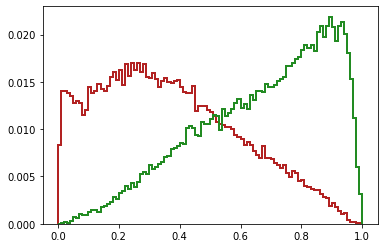

In [20]:
# ratio S_expected/B_expected (signal ratio)
SB_ratio = 0.1

# S/\sqrt{B}
SsqrtB = S_expected / (B_expected)**0.5


    # CHECKEAR QUE TENGAS #
X_gauss_train = trainset[:,1:]
Y_gauss_train = trainset[:,0]

X_gauss_val = valset[:,1:]
Y_gauss_val = valset[:,0]

X_gauss_test = testset[:,1:]
Y_gauss_test = testset[:,0]

y_pred_xg = y_pred_10

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])


print('Classification score:')

weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

print('BINNED CLASSIFIER OUTPUT')
print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)


# Les't find the number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_ensembles_sig = len(pred_XG_NP) / S_expected

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(100), range = [[0,1]])

# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
hist_back_noceros = []
for i in range(len(hist_back)):
    if hist_back[i]!=0:
        hist_back_noceros.append(hist_back[i])

min_back = min(hist_back_noceros)

# replace the zeros
for i in range(len(hist_back)):
    if hist_back[i]==0:
        hist_back[i] = min_back

# now divide by the number of possible ensembles
back_prom = hist_back/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(100), range = [[0,1]])
sig_prom = hist_sig/N_ensembles_sig

# then the signif Z^binned-Asimov:
Z_bins_XG_100bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5
store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)

print('Z_XG 100 bins: ', Z_bins_XG_100bins)
print('\n ----------------------------------------- \n')


Classification score:


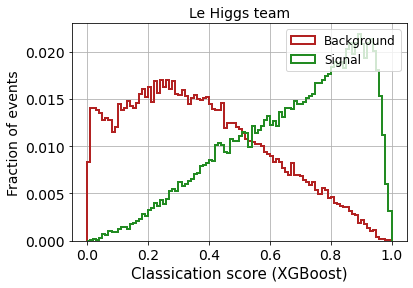

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  10
S/$\sqrt{B}$:  0.1
Z_XG 10 bins:  0.22216429409417826

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  10
S/$\sqrt{B}$:  0.1
Z_XG 25 bins:  0.2558110208363505

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  10
S/$\sqrt{B}$:  0.1
Z_XG 50 bins:  0.2592395470911172

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  10
S/$\sqrt{B}$:  0.1
Z_XG 100 bins:  0.26738351060629634

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   635.78714706   640.60706211   639.34873519   632.38751317
   618.29614214   590.79649655   544.2644849    466.9608724
   323.48577829    16.98455076  -654.19243916 -1959.17842556]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf   974.88663192
   965.89223186   941.18552703   883.92368261   770.29889522
   553.80492221   162.41327043  -569.60781297 -1928.39643306]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


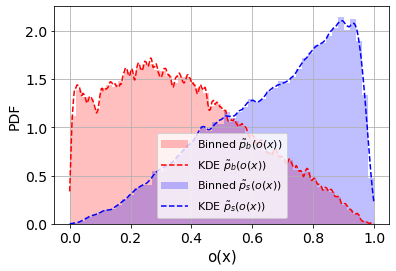

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  10
S/$\sqrt{B}$:  0.1
n_ensembles (initial):  2000

 If  2002  =  371    then the proposed range has to be extended
n_ensembles (actual):  1666

 This may take long... 



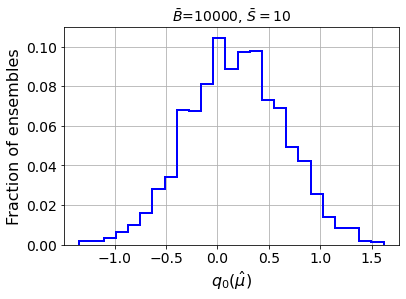

muhat mean:  0.04507803121248499
median q_muhat_KDE:  0.18096342231745943
Z_KDE:  0.4253979575849647
Z_KDE mu=0:  0.4253979575849647

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  10
S/$\sqrt{B}$:  0.1

 ----------------------------------------- 

Z_XG 10 bins:  0.22216429409417826
Z_XG 25 bins:  0.2558110208363505
Z_XG 50 bins:  0.2592395470911172
Z_XG 100 bins:  0.26738351060629634

 ----------------------------------------- 

muhat mean:  0.04507803121248499
median q_muhat_KDE:  0.18096342231745943
Z_KDE:  0.4253979575849647
Z_KDE mu=0:  0.4253979575849647
Classification score:


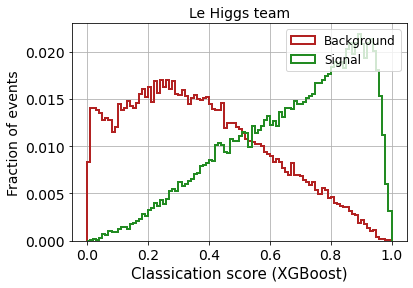

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  50
S/$\sqrt{B}$:  0.5
Z_XG 10 bins:  1.093220367165835

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  50
S/$\sqrt{B}$:  0.5
Z_XG 25 bins:  1.2325944323041897

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  50
S/$\sqrt{B}$:  0.5
Z_XG 50 bins:  1.2446322556315255

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  50
S/$\sqrt{B}$:  0.5
Z_XG 100 bins:  1.2759383301216631

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   635.78714706   640.60706211   639.34873519   632.38751317
   618.29614214   590.79649655   544.2644849    466.9608724
   323.48577829    16.98455076  -654.19243916 -1959.17842556]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf   974.88663192
   965.89223186   941.18552703   883.92368261   770.29889522
   553.80492221   162.41327043  -569.60781297 -1928.39643306]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


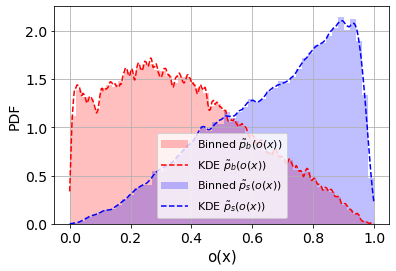

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  50
S/$\sqrt{B}$:  0.5
n_ensembles (initial):  2000

 If  2010  =  371    then the proposed range has to be extended
n_ensembles (actual):  1665

 This may take long... 



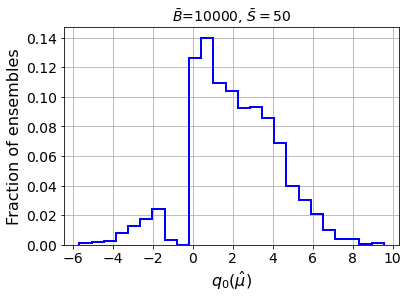

muhat mean:  0.1433633633633634
median q_muhat_KDE:  1.944122470396323
Z_KDE:  1.394317922999028
Z_KDE mu=0:  1.394317922999028

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  50
S/$\sqrt{B}$:  0.5

 ----------------------------------------- 

Z_XG 10 bins:  1.093220367165835
Z_XG 25 bins:  1.2325944323041897
Z_XG 50 bins:  1.2446322556315255
Z_XG 100 bins:  1.2759383301216631

 ----------------------------------------- 

muhat mean:  0.1433633633633634
median q_muhat_KDE:  1.944122470396323
Z_KDE:  1.394317922999028
Z_KDE mu=0:  1.394317922999028
Classification score:


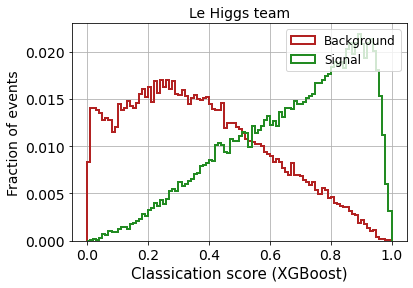

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  100
S/$\sqrt{B}$:  1.0
Z_XG 10 bins:  2.1460615222953257

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  100
S/$\sqrt{B}$:  1.0
Z_XG 25 bins:  2.374612866170723

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  100
S/$\sqrt{B}$:  1.0
Z_XG 50 bins:  2.3921690951607855

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  100
S/$\sqrt{B}$:  1.0
Z_XG 100 bins:  2.44109549850471

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   635.78714706   640.60706211   639.34873519   632.38751317
   618.29614214   590.79649655   544.2644849    466.9608724
   323.48577829    16.98455076  -654.19243916 -1959.17842556]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf   974.88663192
   965.89223186   941.18552703   883.92368261   770.29889522
   553.80492221   162.41327043  -569.60781297 -1928.39643306]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


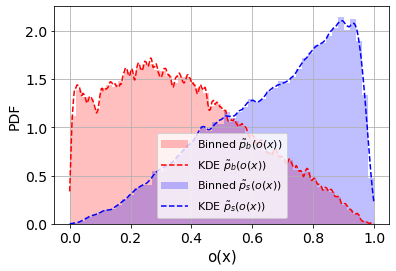

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  100
S/$\sqrt{B}$:  1.0
n_ensembles (initial):  2000

 If  2020  =  371    then the proposed range has to be extended
n_ensembles (actual):  1663

 This may take long... 



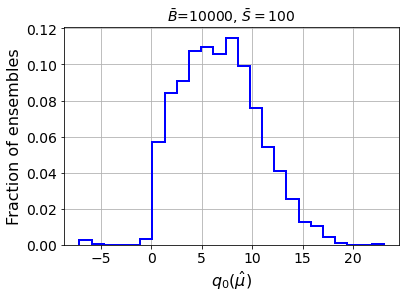

muhat mean:  0.11611545399879737
median q_muhat_KDE:  6.6222125152414435
Z_KDE:  2.5733659893690684
Z_KDE mu=0:  2.5733659893690684

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  100
S/$\sqrt{B}$:  1.0

 ----------------------------------------- 

Z_XG 10 bins:  2.1460615222953257
Z_XG 25 bins:  2.374612866170723
Z_XG 50 bins:  2.3921690951607855
Z_XG 100 bins:  2.44109549850471

 ----------------------------------------- 

muhat mean:  0.11611545399879737
median q_muhat_KDE:  6.6222125152414435
Z_KDE:  2.5733659893690684
Z_KDE mu=0:  2.5733659893690684
Classification score:


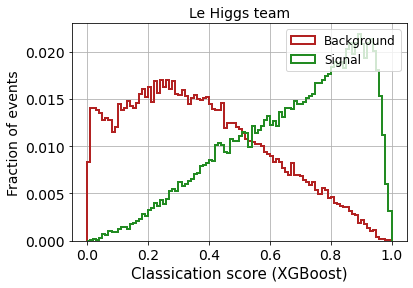

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  200
S/$\sqrt{B}$:  2.0
Z_XG 10 bins:  4.150134822510439

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  200
S/$\sqrt{B}$:  2.0
Z_XG 25 bins:  4.482408274068865

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  200
S/$\sqrt{B}$:  2.0
Z_XG 50 bins:  4.505400743847565

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  200
S/$\sqrt{B}$:  2.0
Z_XG 100 bins:  4.57324538944447

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   635.78714706   640.60706211   639.34873519   632.38751317
   618.29614214   590.79649655   544.2644849    466.9608724
   323.48577829    16.98455076  -654.19243916 -1959.17842556]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf   974.88663192
   965.89223186   941.18552703   883.92368261   770.29889522
   553.80492221   162.41327043  -569.60781297 -1928.39643306]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


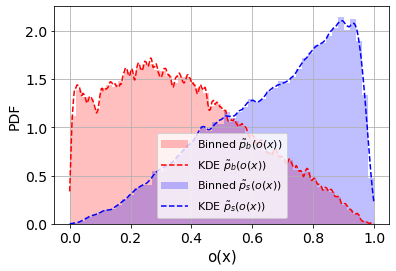

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  200
S/$\sqrt{B}$:  2.0
n_ensembles (initial):  2000

 If  2040  =  373    then the proposed range has to be extended
n_ensembles (actual):  1668

 This may take long... 



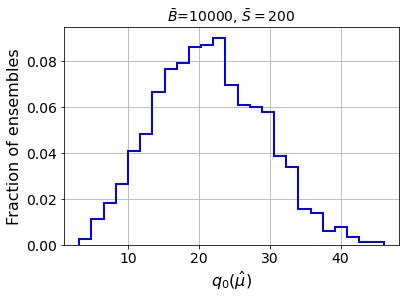

muhat mean:  0.07131294964028778
median q_muhat_KDE:  21.272702629042612
Z_KDE:  4.61223401715943
Z_KDE mu=0:  4.612275831727965

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  200
S/$\sqrt{B}$:  2.0

 ----------------------------------------- 

Z_XG 10 bins:  4.150134822510439
Z_XG 25 bins:  4.482408274068865
Z_XG 50 bins:  4.505400743847565
Z_XG 100 bins:  4.57324538944447

 ----------------------------------------- 

muhat mean:  0.07131294964028778
median q_muhat_KDE:  21.272702629042612
Z_KDE:  4.61223401715943
Z_KDE mu=0:  4.612275831727965
Classification score:


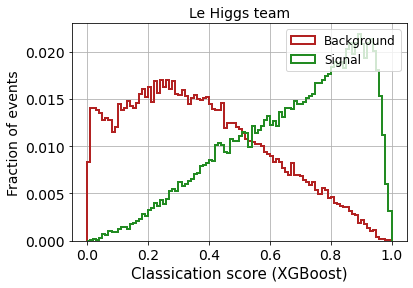

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.042547819800469

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.42952614831634

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.455401275156541

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.532448511188474

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   635.78714706   640.60706211   639.34873519   632.38751317
   618.29614214   590.79649655   544.2644849    466.9608724
   323.48577829    16.98455076  -654.19243916 -1959.17842556]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf   974.88663192
   965.89223186   941.18552703   883.92368261   770.29889522
   553.80492221   162.41327043  -569.60781297 -1928.39643306]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


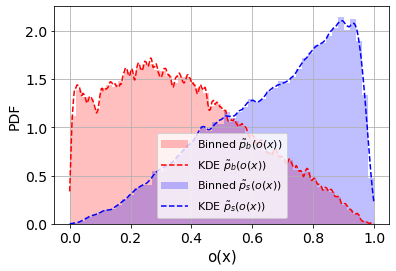

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  2000

 If  2060  =  374    then the proposed range has to be extended
n_ensembles (actual):  1668

 This may take long... 



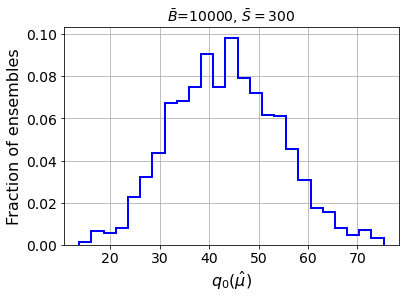

muhat mean:  0.0491906474820144
median q_muhat_KDE:  43.39939938989295
Z_KDE:  6.587822052081624
Z_KDE mu=0:  6.589771849941668

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.042547819800469
Z_XG 25 bins:  6.42952614831634
Z_XG 50 bins:  6.455401275156541
Z_XG 100 bins:  6.532448511188474

 ----------------------------------------- 

muhat mean:  0.0491906474820144
median q_muhat_KDE:  43.39939938989295
Z_KDE:  6.587822052081624
Z_KDE mu=0:  6.589771849941668
Classification score:


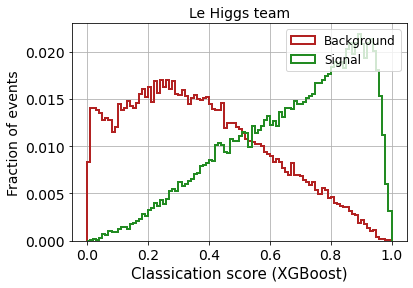

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  400
S/$\sqrt{B}$:  4.0
Z_XG 10 bins:  7.843940898471818

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  400
S/$\sqrt{B}$:  4.0
Z_XG 25 bins:  8.261947308092306

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  400
S/$\sqrt{B}$:  4.0
Z_XG 50 bins:  8.289699105819397

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  400
S/$\sqrt{B}$:  4.0
Z_XG 100 bins:  8.37153584352816

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   635.78714706   640.60706211   639.34873519   632.38751317
   618.29614214   590.79649655   544.2644849    466.9608724
   323.48577829    16.98455076  -654.19243916 -1959.17842556]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf   974.88663192
   965.89223186   941.18552703   883.92368261   770.29889522
   553.80492221   162.41327043  -569.60781297 -1928.39643306]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


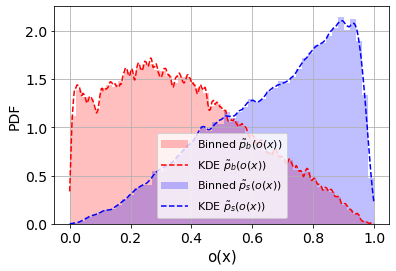

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  400
S/$\sqrt{B}$:  4.0
n_ensembles (initial):  2000

 If  2080  =  376    then the proposed range has to be extended
n_ensembles (actual):  1669

 This may take long... 



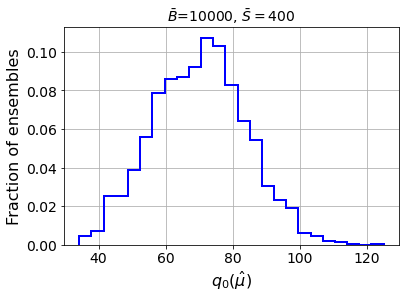

muhat mean:  0.04167165967645297
median q_muhat_KDE:  70.54920870217052
Z_KDE:  8.399357636282106
Z_KDE mu=0:  8.400313580716025

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  400
S/$\sqrt{B}$:  4.0

 ----------------------------------------- 

Z_XG 10 bins:  7.843940898471818
Z_XG 25 bins:  8.261947308092306
Z_XG 50 bins:  8.289699105819397
Z_XG 100 bins:  8.37153584352816

 ----------------------------------------- 

muhat mean:  0.04167165967645297
median q_muhat_KDE:  70.54920870217052
Z_KDE:  8.399357636282106
Z_KDE mu=0:  8.400313580716025
Classification score:


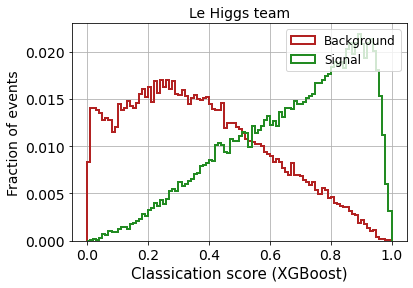

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  500
S/$\sqrt{B}$:  5.0
Z_XG 10 bins:  9.569096865002649

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  500
S/$\sqrt{B}$:  5.0
Z_XG 25 bins:  10.005281172885223

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  500
S/$\sqrt{B}$:  5.0
Z_XG 50 bins:  10.03438436829667

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  500
S/$\sqrt{B}$:  5.0
Z_XG 100 bins:  10.118715381934216

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   635.78714706   640.60706211   639.34873519   632.38751317
   618.29614214   590.79649655   544.2644849    466.9608724
   323.48577829    16.98455076  -654.19243916 -1959.17842556]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf   974.88663192
   965.89223186   941.18552703   883.92368261   770.29889522
   553.80492221   162.41327043  -569.60781297 -1928.39643306]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


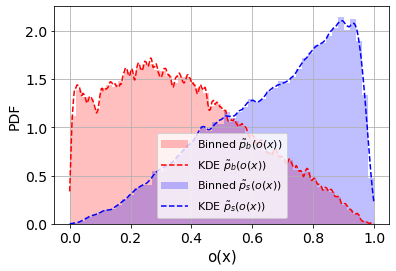

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  500
S/$\sqrt{B}$:  5.0
n_ensembles (initial):  2000

 If  2100  =  376    then the proposed range has to be extended
n_ensembles (actual):  1667

 This may take long... 



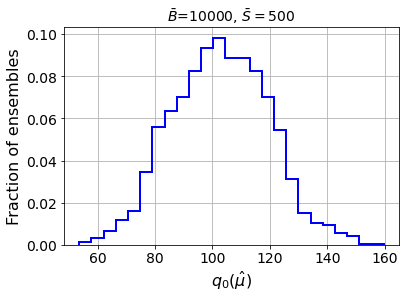

muhat mean:  0.03419316136772646
median q_muhat_KDE:  102.93961860116337
Z_KDE:  10.145916350983946
Z_KDE mu=0:  10.150000963980453

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  500
S/$\sqrt{B}$:  5.0

 ----------------------------------------- 

Z_XG 10 bins:  9.569096865002649
Z_XG 25 bins:  10.005281172885223
Z_XG 50 bins:  10.03438436829667
Z_XG 100 bins:  10.118715381934216

 ----------------------------------------- 

muhat mean:  0.03419316136772646
median q_muhat_KDE:  102.93961860116337
Z_KDE:  10.145916350983946
Z_KDE mu=0:  10.150000963980453
Classification score:


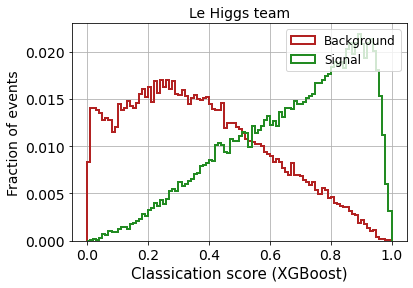

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  700
S/$\sqrt{B}$:  7.0
Z_XG 10 bins:  12.832222070315657

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  700
S/$\sqrt{B}$:  7.0
Z_XG 25 bins:  13.285076140454713

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  700
S/$\sqrt{B}$:  7.0
Z_XG 50 bins:  13.316034027912306

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  700
S/$\sqrt{B}$:  7.0
Z_XG 100 bins:  13.40201144793327

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   635.78714706   640.60706211   639.34873519   632.38751317
   618.29614214   590.79649655   544.2644849    466.9608724
   323.48577829    16.98455076  -654.19243916 -1959.17842556]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf   974.88663192
   965.89223186   941.18552703   883.92368261   770.29889522
   553.80492221   162.41327043  -569.60781297 -1928.39643306]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


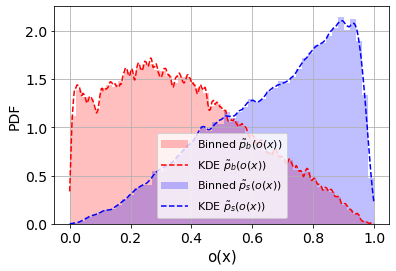

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  700
S/$\sqrt{B}$:  7.0
n_ensembles (initial):  2000

 If  2140  =  380    then the proposed range has to be extended
n_ensembles (actual):  1671

 This may take long... 



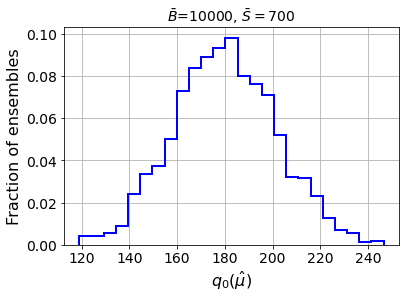

muhat mean:  0.0265409934171155
median q_muhat_KDE:  179.91065687199307
Z_KDE:  13.4130778299387
Z_KDE mu=0:  13.415459567938237

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  700
S/$\sqrt{B}$:  7.0

 ----------------------------------------- 

Z_XG 10 bins:  12.832222070315657
Z_XG 25 bins:  13.285076140454713
Z_XG 50 bins:  13.316034027912306
Z_XG 100 bins:  13.40201144793327

 ----------------------------------------- 

muhat mean:  0.0265409934171155
median q_muhat_KDE:  179.91065687199307
Z_KDE:  13.4130778299387
Z_KDE mu=0:  13.415459567938237


In [21]:
##############
# PARAMETERS #
##############

# requested number of ensembles
n_ensembles = 2000

# number of expected background events per ensemble
B_expected = 10000
#S_expected = 100

Z_MLL = []
Z_10  = []
Z_25  = []
Z_50  = []
Z_100 = []
mu_hat_dist = []
q_mu_hat_dist = []


store_Z_bins_XG_10bins = []
store_Z_bins_XG_25bins = []
store_Z_bins_XG_50bins = []
store_Z_bins_XG_100bins = []

store_muhat_mean_MLL_KDE = []
store_Z_MLL_KDE = []
store_Z_MLL_KDE_mu0 = []
for S_expected in [10, 50, 100, 200, 300, 400, 500, 700]:
    # SOME USEFUL DERIVATED PARAMETERS (maybe not used?):

    # ratio S_expected/B_expected (signal ratio)
    SB_ratio = 0.1

    # S/\sqrt{B}
    SsqrtB = S_expected / (B_expected)**0.5


    # CHECKEAR QUE TENGAS #

    X_gauss_train = trainset[:,1:]
    Y_gauss_train = trainset[:,0]

    X_gauss_val = valset[:,1:]
    Y_gauss_val = valset[:,0]

    X_gauss_test = testset[:,1:]
    Y_gauss_test = testset[:,0]

    y_pred_xg = y_pred_10

    ########################
    # CLASSIFICATION SCORE #
    ########################

    # Outputs for validation data set

    pred_XG_SM = []
    pred_XG_NP = []

    for i in range(len(Y_gauss_test)):
        if Y_gauss_test[i] == 0:
            pred_XG_SM.append(y_pred_xg[i])
        else:
            pred_XG_NP.append(y_pred_xg[i])


    print('Classification score:')

    weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
    nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

    weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
    nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Classication score (XGBoost)",fontsize=15)
    plt.ylabel("Fraction of events",fontsize=14)
    plt.grid()
    plt.legend(fontsize=12)
    plt.title('Le Higgs team', fontsize=14)
    plt.show()

    ##################################################
    # CLASSIFIER OUTPUT BINNED POISON LOG-LIKELIHOOD #
    ##################################################

    # 10 BINS

    print('BINNED CLASSIFIER OUTPUT')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)

    # Les't find the number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_ensembles_sig  = len(pred_XG_NP) / S_expected

    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(10), range = [[0,1]])

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0
    hist_back[np.where(hist_back == 0)[0]] = hist_back[np.argsort(hist_back)[1]]

    # now divide by the number of possible ensembles
    back_prom = hist_back/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(10), range = [[0,1]])
    sig_prom = hist_sig/N_ensembles_sig

    # then the signif Z^binned-Asimov:
    Z_bins_XG_10bins = np.sqrt( 2* np.sum( (back_prom * np.log(back_prom / (sig_prom+back_prom))) + sig_prom ) )

    store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)

    print('Z_XG 10 bins: ', Z_bins_XG_10bins)
    print('\n ----------------------------------------- \n')

    ##############################

    # 25 BINS

    print('BINNED CLASSIFIER OUTPUT')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)


    # Les't find the number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_ensembles_sig = len(pred_XG_NP) / S_expected

    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(25), range = [[0,1]])

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    hist_back_noceros = []
    for i in range(len(hist_back)):
        if hist_back[i]!=0:
            hist_back_noceros.append(hist_back[i])

    min_back = min(hist_back_noceros)

    # replace the zeros
    for i in range(len(hist_back)):
        if hist_back[i]==0:
            hist_back[i] = min_back

    # now divide by the number of possible ensembles
    back_prom = hist_back/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(25), range = [[0,1]])
    sig_prom = hist_sig/N_ensembles_sig

    # then the signif Z^binned-Asimov:
    Z_bins_XG_25bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)

    print('Z_XG 25 bins: ', Z_bins_XG_25bins)
    print('\n ----------------------------------------- \n')

    #############################

    # 50 BINS

    print('BINNED CLASSIFIER OUTPUT')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)


    # Les't find the number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_ensembles_sig = len(pred_XG_NP) / S_expected

    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(50), range = [[0,1]])

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    hist_back_noceros = []
    for i in range(len(hist_back)):
        if hist_back[i]!=0:
            hist_back_noceros.append(hist_back[i])

    min_back = min(hist_back_noceros)

    # replace the zeros
    for i in range(len(hist_back)):
        if hist_back[i]==0:
            hist_back[i] = min_back

    # now divide by the number of possible ensembles
    back_prom = hist_back/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(50), range = [[0,1]])
    sig_prom = hist_sig/N_ensembles_sig

    # then the signif Z^binned-Asimov:
    Z_bins_XG_50bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)

    print('Z_XG 50 bins: ', Z_bins_XG_50bins)
    print('\n ----------------------------------------- \n')

    ##############################

    # 100 BINS

    print('BINNED CLASSIFIER OUTPUT')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)


    # Les't find the number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_ensembles_sig = len(pred_XG_NP) / S_expected

    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(100), range = [[0,1]])

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    hist_back_noceros = []
    for i in range(len(hist_back)):
        if hist_back[i]!=0:
            hist_back_noceros.append(hist_back[i])

    min_back = min(hist_back_noceros)

    # replace the zeros
    for i in range(len(hist_back)):
        if hist_back[i]==0:
            hist_back[i] = min_back

    # now divide by the number of possible ensembles
    back_prom = hist_back/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(100), range = [[0,1]])
    sig_prom = hist_sig/N_ensembles_sig

    # then the signif Z^binned-Asimov:
    Z_bins_XG_100bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)

    print('Z_XG 100 bins: ', Z_bins_XG_100bins)
    print('\n ----------------------------------------- \n')

    #########
    #  KDE  #
    #########  

    print(' MLL + KDE ')

    # FIND THE BANDWIDTH

    bandwidth = np.logspace(-4.0, 0.05, 20)

    kde = KernelDensity(kernel='epanechnikov')
    grid = GridSearchCV(kde, {'bandwidth': bandwidth})
    grid.fit(np.c_[pred_XG_SM[:20000]])
    print('Background: ', grid.best_estimator_)

    SM_bandwidth = grid.best_estimator_.bandwidth

    kde = KernelDensity(kernel='epanechnikov')
    grid = GridSearchCV(kde, {'bandwidth': bandwidth})
    grid.fit(np.c_[pred_XG_NP[:20000]])
    print('Signal: ', grid.best_estimator_)

    NP_bandwidth = grid.best_estimator_.bandwidth

    # with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
    # notice: epanechnikov kernel
    kde_bkg = KernelDensity(kernel='epanechnikov', bandwidth=SM_bandwidth).fit(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ])
    kde_sig = KernelDensity(kernel='epanechnikov', bandwidth=NP_bandwidth).fit(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ])

    # range (~between 0 and 1)
    min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
    max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

    s_vals = np.linspace(min_val,max_val,1000)

    # evaluate the densities for each value of s (~bins)
    dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
    dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

    # Normalize to 1
    # Area
    factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
    factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

    # normalize
    dens_bkg = dens_bkg / factor_aux_SM
    dens_sig = dens_sig / factor_aux_NP

    # plot to check the estimation

    plt.figure()

    plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
    plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

    plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
    plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("o(x)",fontsize=15)
    plt.ylabel("PDF",fontsize=14)
    plt.grid()
    plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
    #plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{dim}$', fontsize=14)
    #plt.savefig('images/' + 'Ndimgaussian-output.pdf', format="pdf", bbox_inches="tight")
    plt.show()

    #############
    # MLL + KDE #
    #############

    # FOR EXCLUSION:
    # we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

    # FOR DISCOVERY:
    # we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

    print('Evaluating the full test dataset with KDE (may take long...)')

    KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

    # Normalize

    KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
    KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP

    print('done')

    indices = [i for i in range(len(KDE_NP_pred_SM))]

    print('\n')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)
    print('n_ensembles (initial): ', n_ensembles)

    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected + B_expected

    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]

    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break

    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))

    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected/(S_expected+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######

    print('\n This may take long... \n')

    # NOW LETS APPLY THE METHOD

    muhat_selected_KDE_list = []
    q_muhat_KDE = []
    q_muhat_KDE_mu0 = []

    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):

            # KDE
            ran_ind = np.random.choice(indices, list_B_per_ensembles[bb])

            KDE_SM_pred_SM_shuf = []
            KDE_NP_pred_SM_shuf = []

            for i in ran_ind:
                KDE_SM_pred_SM_shuf.append(KDE_SM_pred_SM[i])
                KDE_NP_pred_SM_shuf.append(KDE_NP_pred_SM[i])

            KDE_SM_pred_SM_shuf  = np.array(KDE_SM_pred_SM_shuf)
            KDE_NP_pred_SM_shuf  = np.array(KDE_NP_pred_SM_shuf)

            # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

            # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )

            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
            # WE NEED TO ESTIMATE mu_hat for this particular ensemble
            # we are going to obtain a mu_hat with a grid of values for this particular ensemble

            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

            sum_muhat_zero = sum ( [(x*1.) / ( (x * 0. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
            sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            # grid, mu_hat is around 1
            muhat_test = np.arange(0., 1., 0.05).tolist()

            muhat_selected_KDE = 0.0

            if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 > 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break

            elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 < 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break

            muhat_selected_KDE_list.append(muhat_selected_KDE)

            # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
            # and append it (we need the median over lots of ensembles)
            #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            # EXCLUSION:
            q_muhat_KDE.append( 2 * ( ( (1.-muhat_selected_KDE) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (muhat_selected_KDE*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            q_muhat_KDE_mu0.append( 2 * ( ( (1.-0.) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (0.*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

    # Histogram of q_muhats

    weights = np.ones_like(q_muhat_KDE)/float(len(q_muhat_KDE))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_KDE, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()

    # Finally calculate muhat_mean and Z_gaussian

    # Remove nan if any
    q_muhat_KDE_mu0 = [x for x in q_muhat_KDE_mu0 if x == x]

    q_muhat_KDE_median_mu0 = np.median(q_muhat_KDE_mu0)

    Z_KDE_mu0 = abs(q_muhat_KDE_median_mu0)**0.5
    store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean_MLL_KDE = np.mean(muhat_selected_KDE_list)
    store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)
    mu_hat_dist.append(muhat_selected_KDE_list)

    # Remove nan if any
    q_muhat_KDE = [x for x in q_muhat_KDE if x == x]

    q_muhat_KDE_median = np.median(q_muhat_KDE)
    q_mu_hat_dist.append(q_muhat_KDE)

    Z_KDE = abs(q_muhat_KDE_median)**0.5
    store_Z_MLL_KDE.append(Z_KDE)

    Z_MLL.insert(0,Z_KDE)
    Z_10.insert(0,Z_bins_XG_10bins)
    Z_25.insert(0,Z_bins_XG_25bins)
    Z_50.insert(0,Z_bins_XG_50bins)
    Z_100.insert(0,Z_bins_XG_100bins)
    print('muhat mean: ', muhat_mean_MLL_KDE)
    print('median q_muhat_KDE: ', q_muhat_KDE_median)
    print('Z_KDE: ', Z_KDE)
    print('Z_KDE mu=0: ', Z_KDE_mu0)

    print('\n -------------------------------- \n')

    print('RESULTS FOR:')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)
    print('\n ----------------------------------------- \n')

    print('Z_XG 10 bins: ', Z_bins_XG_10bins)
    print('Z_XG 25 bins: ', Z_bins_XG_25bins)
    print('Z_XG 50 bins: ', Z_bins_XG_50bins)
    print('Z_XG 100 bins: ', Z_bins_XG_100bins)
    print('\n ----------------------------------------- \n')

    print('muhat mean: ', muhat_mean_MLL_KDE)
    print('median q_muhat_KDE: ', q_muhat_KDE_median)
    print('Z_KDE: ', Z_KDE)
    print('Z_KDE mu=0: ', Z_KDE_mu0)

In [25]:
ypoints = [10/np.sqrt(10000), 50/np.sqrt(10000), 100/np.sqrt(10000), 200/np.sqrt(10000), 300/np.sqrt(10000), 400/np.sqrt(10000), 500/np.sqrt(10000), 700/np.sqrt(10000)]

Z_MLL = np.asarray(store_Z_MLL_KDE)
Z_10  = np.asarray(store_Z_bins_XG_10bins)
Z_25  = np.asarray(store_Z_bins_XG_25bins)
Z_50  = np.asarray(store_Z_bins_XG_50bins)
Z_100 = np.asarray(store_Z_bins_XG_100bins)

print(Z_10)
print(Z_25)
print(Z_50)
print(Z_100)
print(Z_MLL)
print(ypoints)

[ 0.22216429  1.09322037  2.14606152  4.15013482  6.04254782  7.8439409
  9.56909687 12.83222207]
[ 0.25581102  1.23259443  2.37461287  4.48240827  6.42952615  8.26194731
 10.00528117 13.28507614]
[ 0.25923955  1.24463226  2.3921691   4.50540074  6.45540128  8.28969911
 10.03438437 13.31603403]
[ 0.26738351  1.27593833  2.4410955   4.57324539  6.53244851  8.37153584
 10.11871538 13.40201145]
[ 0.42539796  1.39431792  2.57336599  4.61223402  6.58782205  8.39935764
 10.14591635 13.41307783]
[0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0]


Classification score:


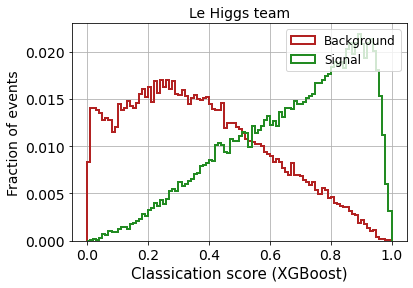

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  10
S/$\sqrt{B}$:  0.1
Z_XG 10 bins:  0.22216429409417826

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  10
S/$\sqrt{B}$:  0.1
Z_XG 25 bins:  0.2558110208363505

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  10
S/$\sqrt{B}$:  0.1
Z_XG 50 bins:  0.2592395470911172

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  10
S/$\sqrt{B}$:  0.1
Z_XG 100 bins:  0.26738351060629634

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  10
S/$\sqrt{B}$:  0.1
Z_XG 10 bins:  0.17578338512772454

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  10
S/$\sqrt{B}$:  0.1
Z_XG 25 bins:  0.19658661720421663

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  100

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   635.78714706   640.60706211   639.34873519   632.38751317
   618.29614214   590.79649655   544.2644849    466.9608724
   323.48577829    16.98455076  -654.19243916 -1959.17842556]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf   974.88663192
   965.89223186   941.18552703   883.92368261   770.29889522
   553.80492221   162.41327043  -569.60781297 -1928.39643306]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


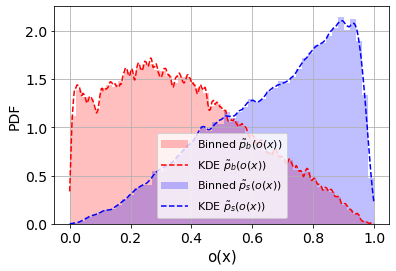

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  10
S/$\sqrt{B}$:  0.1
n_ensembles (initial):  2000

 If  2002  =  371    then the proposed range has to be extended
n_ensembles (actual):  1666

 This may take long... 



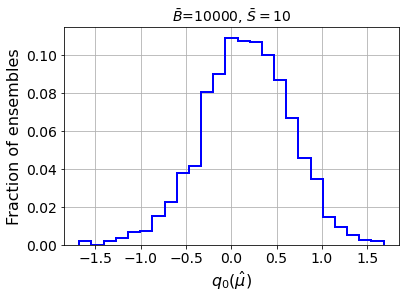

muhat mean:  0.05135054021608644
median q_muhat_KDE:  0.17348669973626052
Z_KDE:  0.41651734626094566
Z_KDE mu=0:  0.41651734626094566

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  10
S/$\sqrt{B}$:  0.1

 ----------------------------------------- 

Z_XG 10 bins:  12.832222070315657
Z_XG 25 bins:  13.285076140454713
Z_XG 50 bins:  13.316034027912306
Z_XG 100 bins:  13.40201144793327

 ----------------------------------------- 

muhat mean:  0.05135054021608644
median q_muhat_KDE:  0.17348669973626052
Z_KDE:  0.41651734626094566
Z_KDE mu=0:  0.41651734626094566
Classification score:


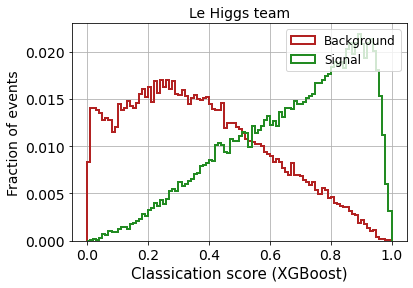

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  50
S/$\sqrt{B}$:  0.5
Z_XG 10 bins:  1.093220367165835

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  50
S/$\sqrt{B}$:  0.5
Z_XG 25 bins:  1.2325944323041897

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  50
S/$\sqrt{B}$:  0.5
Z_XG 50 bins:  1.2446322556315255

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  50
S/$\sqrt{B}$:  0.5
Z_XG 100 bins:  1.2759383301216631

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  50
S/$\sqrt{B}$:  0.5
Z_XG 10 bins:  0.8737062778352311

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  50
S/$\sqrt{B}$:  0.5
Z_XG 25 bins:  0.974133663500978

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_e

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   635.78714706   640.60706211   639.34873519   632.38751317
   618.29614214   590.79649655   544.2644849    466.9608724
   323.48577829    16.98455076  -654.19243916 -1959.17842556]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf   974.88663192
   965.89223186   941.18552703   883.92368261   770.29889522
   553.80492221   162.41327043  -569.60781297 -1928.39643306]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


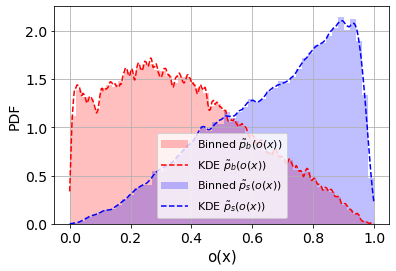

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  50
S/$\sqrt{B}$:  0.5
n_ensembles (initial):  2000

 If  2010  =  371    then the proposed range has to be extended
n_ensembles (actual):  1665

 This may take long... 



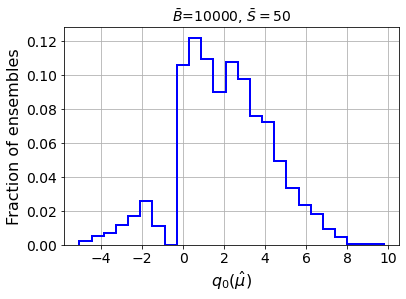

muhat mean:  0.144984984984985
median q_muhat_KDE:  2.013513628961661
Z_KDE:  1.4189833082040328
Z_KDE mu=0:  1.4189833082040328

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  50
S/$\sqrt{B}$:  0.5

 ----------------------------------------- 

Z_XG 10 bins:  12.832222070315657
Z_XG 25 bins:  13.285076140454713
Z_XG 50 bins:  13.316034027912306
Z_XG 100 bins:  13.40201144793327

 ----------------------------------------- 

muhat mean:  0.144984984984985
median q_muhat_KDE:  2.013513628961661
Z_KDE:  1.4189833082040328
Z_KDE mu=0:  1.4189833082040328
Classification score:


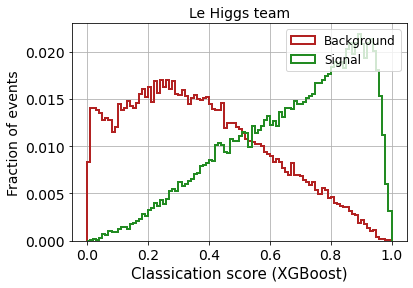

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  100
S/$\sqrt{B}$:  1.0
Z_XG 10 bins:  2.1460615222953257

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  100
S/$\sqrt{B}$:  1.0
Z_XG 25 bins:  2.374612866170723

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  100
S/$\sqrt{B}$:  1.0
Z_XG 50 bins:  2.3921690951607855

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  100
S/$\sqrt{B}$:  1.0
Z_XG 100 bins:  2.44109549850471

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  100
S/$\sqrt{B}$:  1.0
Z_XG 10 bins:  1.7347200780609384

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  100
S/$\sqrt{B}$:  1.0
Z_XG 25 bins:  1.9271755267432893

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   635.78714706   640.60706211   639.34873519   632.38751317
   618.29614214   590.79649655   544.2644849    466.9608724
   323.48577829    16.98455076  -654.19243916 -1959.17842556]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf   974.88663192
   965.89223186   941.18552703   883.92368261   770.29889522
   553.80492221   162.41327043  -569.60781297 -1928.39643306]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


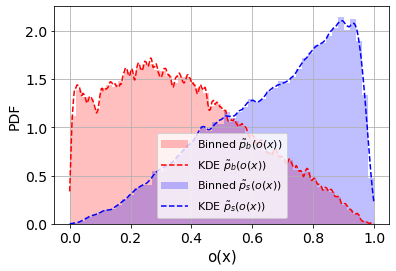

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  100
S/$\sqrt{B}$:  1.0
n_ensembles (initial):  2000

 If  2020  =  371    then the proposed range has to be extended
n_ensembles (actual):  1663

 This may take long... 



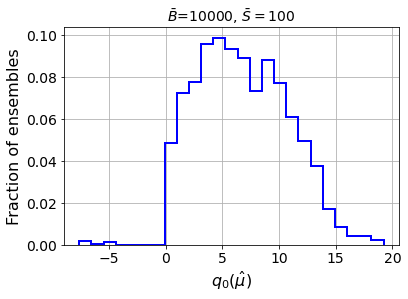

muhat mean:  0.12594708358388454
median q_muhat_KDE:  6.475074862278888
Z_KDE:  2.544616839973926
Z_KDE mu=0:  2.544616839973926

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  100
S/$\sqrt{B}$:  1.0

 ----------------------------------------- 

Z_XG 10 bins:  12.832222070315657
Z_XG 25 bins:  13.285076140454713
Z_XG 50 bins:  13.316034027912306
Z_XG 100 bins:  13.40201144793327

 ----------------------------------------- 

muhat mean:  0.12594708358388454
median q_muhat_KDE:  6.475074862278888
Z_KDE:  2.544616839973926
Z_KDE mu=0:  2.544616839973926
Classification score:


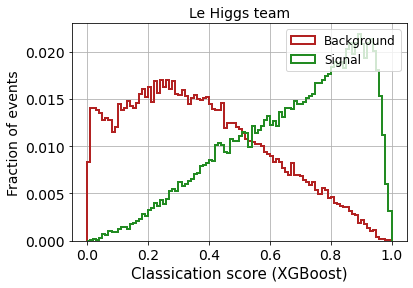

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  200
S/$\sqrt{B}$:  2.0
Z_XG 10 bins:  4.150134822510439

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  200
S/$\sqrt{B}$:  2.0
Z_XG 25 bins:  4.482408274068865

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  200
S/$\sqrt{B}$:  2.0
Z_XG 50 bins:  4.505400743847565

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  200
S/$\sqrt{B}$:  2.0
Z_XG 100 bins:  4.57324538944447

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  200
S/$\sqrt{B}$:  2.0
Z_XG 10 bins:  3.420757948778192

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  200
S/$\sqrt{B}$:  2.0
Z_XG 25 bins:  3.775426558030882

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   635.78714706   640.60706211   639.34873519   632.38751317
   618.29614214   590.79649655   544.2644849    466.9608724
   323.48577829    16.98455076  -654.19243916 -1959.17842556]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf   974.88663192
   965.89223186   941.18552703   883.92368261   770.29889522
   553.80492221   162.41327043  -569.60781297 -1928.39643306]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


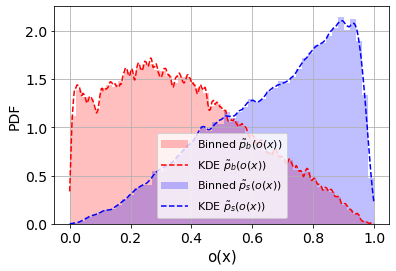

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  200
S/$\sqrt{B}$:  2.0
n_ensembles (initial):  2000

 If  2040  =  373    then the proposed range has to be extended
n_ensembles (actual):  1668

 This may take long... 



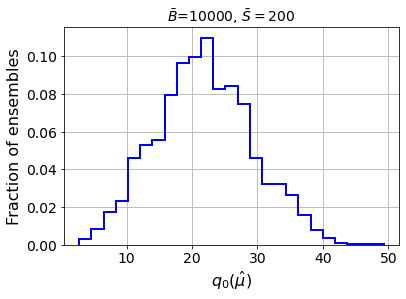

muhat mean:  0.06417865707434053
median q_muhat_KDE:  21.74341422398524
Z_KDE:  4.662983403786169
Z_KDE mu=0:  4.662983403786169

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  200
S/$\sqrt{B}$:  2.0

 ----------------------------------------- 

Z_XG 10 bins:  12.832222070315657
Z_XG 25 bins:  13.285076140454713
Z_XG 50 bins:  13.316034027912306
Z_XG 100 bins:  13.40201144793327

 ----------------------------------------- 

muhat mean:  0.06417865707434053
median q_muhat_KDE:  21.74341422398524
Z_KDE:  4.662983403786169
Z_KDE mu=0:  4.662983403786169
Classification score:


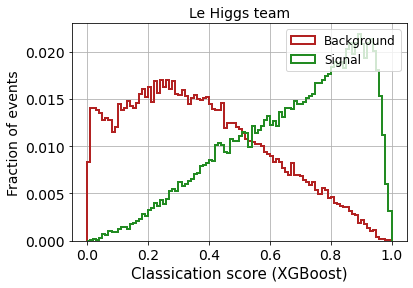

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.042547819800469

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.42952614831634

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.455401275156541

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.532448511188474

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  5.0619577679817125

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  5.554300002429695

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   635.78714706   640.60706211   639.34873519   632.38751317
   618.29614214   590.79649655   544.2644849    466.9608724
   323.48577829    16.98455076  -654.19243916 -1959.17842556]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf   974.88663192
   965.89223186   941.18552703   883.92368261   770.29889522
   553.80492221   162.41327043  -569.60781297 -1928.39643306]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


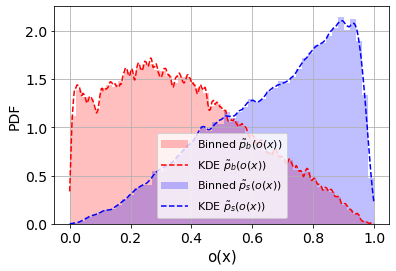

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  2000

 If  2060  =  374    then the proposed range has to be extended
n_ensembles (actual):  1668

 This may take long... 



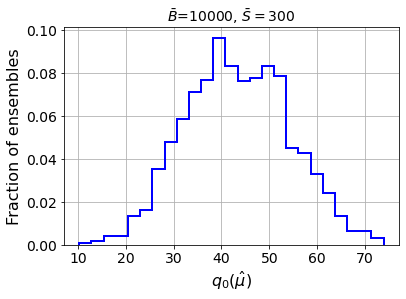

muhat mean:  0.05008992805755396
median q_muhat_KDE:  43.00316406406165
Z_KDE:  6.557679777486977
Z_KDE mu=0:  6.557679777486977

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  12.832222070315657
Z_XG 25 bins:  13.285076140454713
Z_XG 50 bins:  13.316034027912306
Z_XG 100 bins:  13.40201144793327

 ----------------------------------------- 

muhat mean:  0.05008992805755396
median q_muhat_KDE:  43.00316406406165
Z_KDE:  6.557679777486977
Z_KDE mu=0:  6.557679777486977
Classification score:


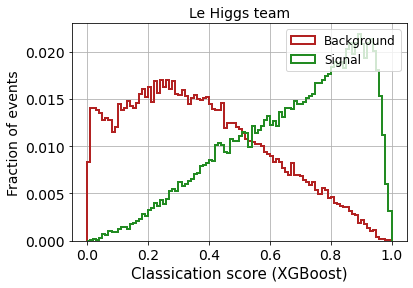

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  400
S/$\sqrt{B}$:  4.0
Z_XG 10 bins:  7.843940898471818

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  400
S/$\sqrt{B}$:  4.0
Z_XG 25 bins:  8.261947308092306

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  400
S/$\sqrt{B}$:  4.0
Z_XG 50 bins:  8.289699105819397

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  400
S/$\sqrt{B}$:  4.0
Z_XG 100 bins:  8.37153584352816

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  400
S/$\sqrt{B}$:  4.0
Z_XG 10 bins:  6.66169529539851

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  400
S/$\sqrt{B}$:  4.0
Z_XG 25 bins:  7.271579009876333

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_e

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   635.78714706   640.60706211   639.34873519   632.38751317
   618.29614214   590.79649655   544.2644849    466.9608724
   323.48577829    16.98455076  -654.19243916 -1959.17842556]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf   974.88663192
   965.89223186   941.18552703   883.92368261   770.29889522
   553.80492221   162.41327043  -569.60781297 -1928.39643306]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


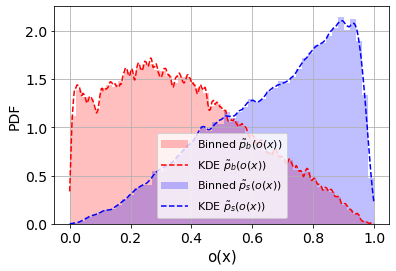

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  400
S/$\sqrt{B}$:  4.0
n_ensembles (initial):  2000

 If  2080  =  376    then the proposed range has to be extended
n_ensembles (actual):  1669

 This may take long... 



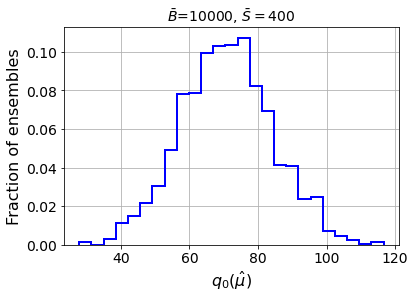

muhat mean:  0.038166566806470945
median q_muhat_KDE:  70.92119263206757
Z_KDE:  8.42147211787034
Z_KDE mu=0:  8.42147211787034

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  400
S/$\sqrt{B}$:  4.0

 ----------------------------------------- 

Z_XG 10 bins:  12.832222070315657
Z_XG 25 bins:  13.285076140454713
Z_XG 50 bins:  13.316034027912306
Z_XG 100 bins:  13.40201144793327

 ----------------------------------------- 

muhat mean:  0.038166566806470945
median q_muhat_KDE:  70.92119263206757
Z_KDE:  8.42147211787034
Z_KDE mu=0:  8.42147211787034
Classification score:


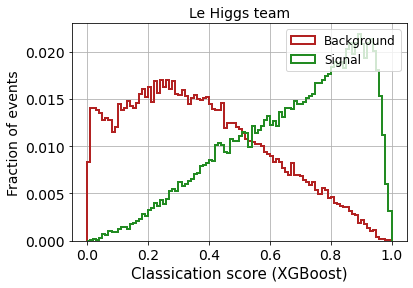

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  500
S/$\sqrt{B}$:  5.0
Z_XG 10 bins:  9.569096865002649

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  500
S/$\sqrt{B}$:  5.0
Z_XG 25 bins:  10.005281172885223

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  500
S/$\sqrt{B}$:  5.0
Z_XG 50 bins:  10.03438436829667

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  500
S/$\sqrt{B}$:  5.0
Z_XG 100 bins:  10.118715381934216

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  500
S/$\sqrt{B}$:  5.0
Z_XG 10 bins:  8.22295261178982

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  500
S/$\sqrt{B}$:  5.0
Z_XG 25 bins:  8.933701584914198

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   635.78714706   640.60706211   639.34873519   632.38751317
   618.29614214   590.79649655   544.2644849    466.9608724
   323.48577829    16.98455076  -654.19243916 -1959.17842556]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf   974.88663192
   965.89223186   941.18552703   883.92368261   770.29889522
   553.80492221   162.41327043  -569.60781297 -1928.39643306]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


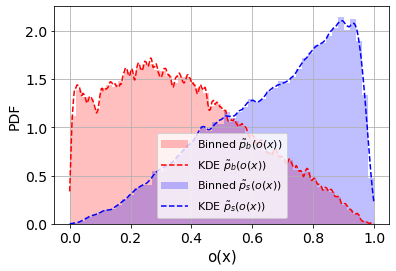

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  500
S/$\sqrt{B}$:  5.0
n_ensembles (initial):  2000

 If  2100  =  376    then the proposed range has to be extended
n_ensembles (actual):  1667

 This may take long... 



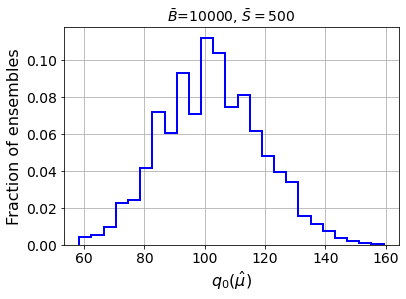

muhat mean:  0.034013197360527894
median q_muhat_KDE:  102.14337702528712
Z_KDE:  10.106600666163036
Z_KDE mu=0:  10.106899669871702

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  500
S/$\sqrt{B}$:  5.0

 ----------------------------------------- 

Z_XG 10 bins:  12.832222070315657
Z_XG 25 bins:  13.285076140454713
Z_XG 50 bins:  13.316034027912306
Z_XG 100 bins:  13.40201144793327

 ----------------------------------------- 

muhat mean:  0.034013197360527894
median q_muhat_KDE:  102.14337702528712
Z_KDE:  10.106600666163036
Z_KDE mu=0:  10.106899669871702
Classification score:


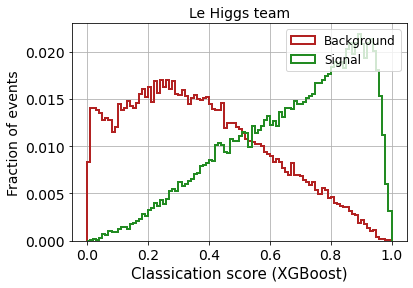

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  700
S/$\sqrt{B}$:  7.0
Z_XG 10 bins:  12.832222070315657

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  700
S/$\sqrt{B}$:  7.0
Z_XG 25 bins:  13.285076140454713

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  700
S/$\sqrt{B}$:  7.0
Z_XG 50 bins:  13.316034027912306

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  700
S/$\sqrt{B}$:  7.0
Z_XG 100 bins:  13.40201144793327

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  700
S/$\sqrt{B}$:  7.0
Z_XG 10 bins:  11.240336830157986

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  700
S/$\sqrt{B}$:  7.0
Z_XG 25 bins:  12.113225360775768

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   635.78714706   640.60706211   639.34873519   632.38751317
   618.29614214   590.79649655   544.2644849    466.9608724
   323.48577829    16.98455076  -654.19243916 -1959.17842556]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf   974.88663192
   965.89223186   941.18552703   883.92368261   770.29889522
   553.80492221   162.41327043  -569.60781297 -1928.39643306]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


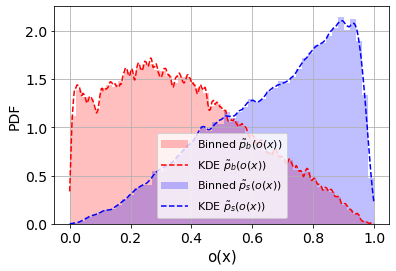

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  700
S/$\sqrt{B}$:  7.0
n_ensembles (initial):  2000

 If  2140  =  380    then the proposed range has to be extended
n_ensembles (actual):  1671

 This may take long... 



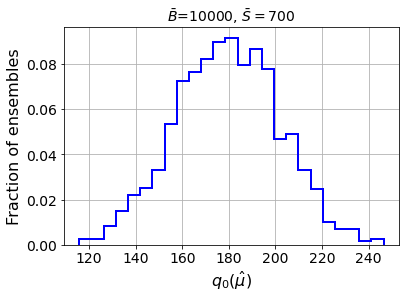

muhat mean:  0.02980251346499102
median q_muhat_KDE:  179.59909934335906
Z_KDE:  13.401458851310146
Z_KDE mu=0:  13.40194078765873

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  700
S/$\sqrt{B}$:  7.0

 ----------------------------------------- 

Z_XG 10 bins:  12.832222070315657
Z_XG 25 bins:  13.285076140454713
Z_XG 50 bins:  13.316034027912306
Z_XG 100 bins:  13.40201144793327

 ----------------------------------------- 

muhat mean:  0.02980251346499102
median q_muhat_KDE:  179.59909934335906
Z_KDE:  13.401458851310146
Z_KDE mu=0:  13.40194078765873


In [22]:
# 10 ML

##############
# PARAMETERS #
##############

# requested number of ensembles
n_ensembles = 2000

# number of expected background events per ensemble
B_expected = 10000
#S_expected = 100

Z_MLL_10ML = []
Z_10_10ML  = []
Z_25_10ML  = []
Z_50_10ML  = []
Z_100_10ML = []
Z_10_10ML_nl  = []
Z_25_10ML_nl  = []
Z_50_10ML_nl  = []
Z_100_10ML_nl = []
mu_hat_dist   = []
q_mu_hat_dist = []

store_Z_bins_XG_10bins_10ML = []
store_Z_bins_XG_25bins_10ML = []
store_Z_bins_XG_50bins_10ML = []
store_Z_bins_XG_100bins_10ML = []

store_Z_bins_XG_10bins_10ML_nl = []
store_Z_bins_XG_25bins_10ML_nl = []
store_Z_bins_XG_50bins_10ML_nl = []
store_Z_bins_XG_100bins_10ML_nl = []

store_muhat_mean_MLL_KDE_10ML = []
store_Z_MLL_KDE_10ML = []
store_Z_MLL_KDE_mu0_10ML = []
for S_expected in [10, 50, 100, 200, 300, 400, 500, 700]:
    # SOME USEFUL DERIVATED PARAMETERS (maybe not used?):

    # ratio S_expected/B_expected (signal ratio)
    SB_ratio = 0.1

    # S/\sqrt{B}
    SsqrtB = S_expected / (B_expected)**0.5

    # CHECKEAR QUE TENGAS #

    X_gauss_train = trainset[:,1:]
    Y_gauss_train = trainset[:,0]

    X_gauss_val = valset[:,1:]
    Y_gauss_val = valset[:,0]

    X_gauss_test = testset[:,1:]
    Y_gauss_test = testset[:,0]

    y_pred_xg = y_pred_10

    ########################
    # CLASSIFICATION SCORE #
    ########################

    # Outputs for validation data set

    pred_XG_SM = []
    pred_XG_NP = []

    for i in range(len(Y_gauss_test)):
        if Y_gauss_test[i] == 0:
            pred_XG_SM.append(y_pred_xg[i])
        else:
            pred_XG_NP.append(y_pred_xg[i])


    print('Classification score:')

    weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
    nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

    weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
    nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Classication score (XGBoost)",fontsize=15)
    plt.ylabel("Fraction of events",fontsize=14)
    plt.grid()
    plt.legend(fontsize=12)
    plt.title('Le Higgs team', fontsize=14)
    plt.show()

    ##################################################
    # CLASSIFIER OUTPUT BINNED POISON LOG-LIKELIHOOD #
    ##################################################

    # 10 BINS

    print('BINNED CLASSIFIER OUTPUT')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)

    # Les't find the number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_ensembles_sig  = len(pred_XG_NP) / S_expected

    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(10), range = [[0,1]])

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0
    hist_back[np.where(hist_back == 0)[0]] = hist_back[np.argsort(hist_back)[1]]

    # now divide by the number of possible ensembles
    back_prom = hist_back/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(10), range = [[0,1]])
    sig_prom = hist_sig/N_ensembles_sig

    # then the signif Z^binned-Asimov:
    Z_bins_XG_10bins_10ML = np.sqrt( 2* np.sum( (back_prom * np.log(back_prom / (sig_prom+back_prom))) + sig_prom ) )

    store_Z_bins_XG_10bins_10ML.append(Z_bins_XG_10bins_10ML)

    print('Z_XG 10 bins: ', Z_bins_XG_10bins_10ML)
    print('\n ----------------------------------------- \n')

    ##############################

    # 25 BINS

    print('BINNED CLASSIFIER OUTPUT')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)


    # Les't find the number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_ensembles_sig = len(pred_XG_NP) / S_expected

    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(25), range = [[0,1]])

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    hist_back_noceros = []
    for i in range(len(hist_back)):
        if hist_back[i]!=0:
            hist_back_noceros.append(hist_back[i])

    min_back = min(hist_back_noceros)

    # replace the zeros
    for i in range(len(hist_back)):
        if hist_back[i]==0:
            hist_back[i] = min_back

    # now divide by the number of possible ensembles
    back_prom = hist_back/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(25), range = [[0,1]])
    sig_prom = hist_sig/N_ensembles_sig

    # then the signif Z^binned-Asimov:
    Z_bins_XG_25bins_10ML = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins_XG_25bins_10ML.append(Z_bins_XG_25bins_10ML)

    print('Z_XG 25 bins: ', Z_bins_XG_25bins_10ML)
    print('\n ----------------------------------------- \n')

    #############################

    # 50 BINS

    print('BINNED CLASSIFIER OUTPUT')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)


    # Les't find the number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_ensembles_sig = len(pred_XG_NP) / S_expected

    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(50), range = [[0,1]])

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    hist_back_noceros = []
    for i in range(len(hist_back)):
        if hist_back[i]!=0:
            hist_back_noceros.append(hist_back[i])

    min_back = min(hist_back_noceros)

    # replace the zeros
    for i in range(len(hist_back)):
        if hist_back[i]==0:
            hist_back[i] = min_back

    # now divide by the number of possible ensembles
    back_prom = hist_back/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(50), range = [[0,1]])
    sig_prom = hist_sig/N_ensembles_sig

    # then the signif Z^binned-Asimov:
    Z_bins_XG_50bins_10ML = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins_XG_50bins_10ML.append(Z_bins_XG_50bins_10ML)

    print('Z_XG 50 bins: ', Z_bins_XG_50bins_10ML)
    print('\n ----------------------------------------- \n')

    ##############################

    # 100 BINS

    print('BINNED CLASSIFIER OUTPUT')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)


    # Les't find the number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_ensembles_sig = len(pred_XG_NP) / S_expected

    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(100), range = [[0,1]])

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    hist_back_noceros = []
    for i in range(len(hist_back)):
        if hist_back[i]!=0:
            hist_back_noceros.append(hist_back[i])

    min_back = min(hist_back_noceros)

    # replace the zeros
    for i in range(len(hist_back)):
        if hist_back[i]==0:
            hist_back[i] = min_back

    # now divide by the number of possible ensembles
    back_prom = hist_back/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(100), range = [[0,1]])
    sig_prom = hist_sig/N_ensembles_sig

    # then the signif Z^binned-Asimov:
    Z_bins_XG_100bins_10ML = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins_XG_100bins_10ML.append(Z_bins_XG_100bins_10ML)

    print('Z_XG 100 bins: ', Z_bins_XG_100bins_10ML)
    print('\n ----------------------------------------- \n')

    
    # 10 BINS (NL)

    print('BINNED CLASSIFIER OUTPUT')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)

    # Les't find the number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_ensembles_sig  = len(pred_XG_NP) / S_expected

    #Let's find out the expected number of B and S events in each bin:
    bin_edges_same = pd.qcut(pd.DataFrame(pred_XG_SM)[0], q = 10, precision=0, retbins = True)[1]

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=[bin_edges_same], range = [[0,1]])

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0
    hist_back[np.where(hist_back == 0)[0]] = hist_back[np.argsort(hist_back)[1]]

    # now divide by the number of possible ensembles
    back_prom = hist_back/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=[bin_edges_same], range = [[0,1]])
    sig_prom = hist_sig/N_ensembles_sig

    # then the signif Z^binned-Asimov:
    Z_bins_XG_10bins_10ML_nl = np.sqrt( 2* np.sum( (back_prom * np.log(back_prom / (sig_prom+back_prom))) + sig_prom ) )

    store_Z_bins_XG_10bins_10ML_nl.append(Z_bins_XG_10bins_10ML_nl)

    print('Z_XG 10 bins: ', Z_bins_XG_10bins_10ML_nl)
    print('\n ----------------------------------------- \n')

    ##############################

    # 25 BINS (NL)

    print('BINNED CLASSIFIER OUTPUT')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)


    # Les't find the number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_ensembles_sig = len(pred_XG_NP) / S_expected

    #Let's find out the expected number of B and S events in each bin:
    bin_edges_same = pd.qcut(pd.DataFrame(pred_XG_SM)[0], q = 25, precision=0, retbins = True)[1]

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=[bin_edges_same], range = [[0,1]])

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    hist_back_noceros = []
    for i in range(len(hist_back)):
        if hist_back[i]!=0:
            hist_back_noceros.append(hist_back[i])

    min_back = min(hist_back_noceros)

    # replace the zeros
    for i in range(len(hist_back)):
        if hist_back[i]==0:
            hist_back[i] = min_back

    # now divide by the number of possible ensembles
    back_prom = hist_back/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=[bin_edges_same], range = [[0,1]])
    sig_prom = hist_sig/N_ensembles_sig

    # then the signif Z^binned-Asimov:
    Z_bins_XG_25bins_10ML_nl = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins_XG_25bins_10ML_nl.append(Z_bins_XG_25bins_10ML_nl)

    print('Z_XG 25 bins: ', Z_bins_XG_25bins_10ML_nl)
    print('\n ----------------------------------------- \n')

    #############################

    # 50 BINS (NL)

    print('BINNED CLASSIFIER OUTPUT')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)


    # Les't find the number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_ensembles_sig = len(pred_XG_NP) / S_expected

    #Let's find out the expected number of B and S events in each bin:
    bin_edges_same = pd.qcut(pd.DataFrame(pred_XG_SM)[0], q = 50, precision=0, retbins = True)[1]

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=[bin_edges_same], range = [[0,1]])

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    hist_back_noceros = []
    for i in range(len(hist_back)):
        if hist_back[i]!=0:
            hist_back_noceros.append(hist_back[i])

    min_back = min(hist_back_noceros)

    # replace the zeros
    for i in range(len(hist_back)):
        if hist_back[i]==0:
            hist_back[i] = min_back

    # now divide by the number of possible ensembles
    back_prom = hist_back/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=[bin_edges_same], range = [[0,1]])
    sig_prom = hist_sig/N_ensembles_sig

    # then the signif Z^binned-Asimov:
    Z_bins_XG_50bins_10ML_nl = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins_XG_50bins_10ML_nl.append(Z_bins_XG_50bins_10ML_nl)

    print('Z_XG 50 bins: ', Z_bins_XG_50bins_10ML_nl)
    print('\n ----------------------------------------- \n')

    ##############################

    # 100 BINS (NL)

    print('BINNED CLASSIFIER OUTPUT')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)


    # Les't find the number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_ensembles_sig = len(pred_XG_NP) / S_expected

    #Let's find out the expected number of B and S events in each bin:
    bin_edges_same = pd.qcut(pd.DataFrame(pred_XG_SM)[0], q = 100, precision=0, retbins = True)[1]

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=[bin_edges_same], range = [[0,1]])

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    hist_back_noceros = []
    for i in range(len(hist_back)):
        if hist_back[i]!=0:
            hist_back_noceros.append(hist_back[i])

    min_back = min(hist_back_noceros)

    # replace the zeros
    for i in range(len(hist_back)):
        if hist_back[i]==0:
            hist_back[i] = min_back

    # now divide by the number of possible ensembles
    back_prom = hist_back/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=[bin_edges_same], range = [[0,1]])
    sig_prom = hist_sig/N_ensembles_sig

    # then the signif Z^binned-Asimov:
    Z_bins_XG_100bins_10ML_nl = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins_XG_100bins_10ML_nl.append(Z_bins_XG_100bins_10ML_nl)

    print('Z_XG 100 bins: ', Z_bins_XG_100bins_10ML_nl)
    print('\n ----------------------------------------- \n')

    #########
    #  KDE  #
    #########  

    print(' MLL + KDE ')

    # FIND THE BANDWIDTH

    bandwidth = np.logspace(-4.0, 0.05, 20)

    kde = KernelDensity(kernel='epanechnikov')
    grid = GridSearchCV(kde, {'bandwidth': bandwidth})
    grid.fit(np.c_[pred_XG_SM[:20000]])
    print('Background: ', grid.best_estimator_)

    SM_bandwidth = grid.best_estimator_.bandwidth

    kde = KernelDensity(kernel='epanechnikov')
    grid = GridSearchCV(kde, {'bandwidth': bandwidth})
    grid.fit(np.c_[pred_XG_NP[:20000]])
    print('Signal: ', grid.best_estimator_)

    NP_bandwidth = grid.best_estimator_.bandwidth

    # with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
    # notice: epanechnikov kernel
    kde_bkg = KernelDensity(kernel='epanechnikov', bandwidth=SM_bandwidth).fit(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ])
    kde_sig = KernelDensity(kernel='epanechnikov', bandwidth=NP_bandwidth).fit(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ])

    # range (~between 0 and 1)
    min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
    max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

    s_vals = np.linspace(min_val,max_val,1000)

    # evaluate the densities for each value of s (~bins)
    dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
    dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

    # Normalize to 1
    # Area
    factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
    factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

    # normalize
    dens_bkg = dens_bkg / factor_aux_SM
    dens_sig = dens_sig / factor_aux_NP

    # plot to check the estimation

    plt.figure()

    plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
    plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

    plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
    plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("o(x)",fontsize=15)
    plt.ylabel("PDF",fontsize=14)
    plt.grid()
    plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
    #plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{dim}$', fontsize=14)
    #plt.savefig('images/' + 'Ndimgaussian-output.pdf', format="pdf", bbox_inches="tight")
    plt.show()

    #############
    # MLL + KDE #
    #############

    # FOR EXCLUSION:
    # we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

    # FOR DISCOVERY:
    # we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

    print('Evaluating the full test dataset with KDE (may take long...)')

    KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

    # Normalize

    KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
    KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP

    print('done')

    indices = [i for i in range(len(KDE_NP_pred_SM))]

    print('\n')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)
    print('n_ensembles (initial): ', n_ensembles)

    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected + B_expected

    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]

    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break

    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))

    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected/(S_expected+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######

    print('\n This may take long... \n')

    # NOW LETS APPLY THE METHOD

    muhat_selected_KDE_list = []
    q_muhat_KDE = []
    q_muhat_KDE_mu0 = []

    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):

            # KDE
            ran_ind = np.random.choice(indices, list_B_per_ensembles[bb])

            KDE_SM_pred_SM_shuf = []
            KDE_NP_pred_SM_shuf = []

            for i in ran_ind:
                KDE_SM_pred_SM_shuf.append(KDE_SM_pred_SM[i])
                KDE_NP_pred_SM_shuf.append(KDE_NP_pred_SM[i])

            KDE_SM_pred_SM_shuf  = np.array(KDE_SM_pred_SM_shuf)
            KDE_NP_pred_SM_shuf  = np.array(KDE_NP_pred_SM_shuf)

            # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

            # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )

            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
            # WE NEED TO ESTIMATE mu_hat for this particular ensemble
            # we are going to obtain a mu_hat with a grid of values for this particular ensemble

            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

            sum_muhat_zero = sum ( [(x*1.) / ( (x * 0. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
            sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            # grid, mu_hat is around 1
            muhat_test = np.arange(0., 1., 0.05).tolist()

            muhat_selected_KDE = 0.0

            if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 > 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break

            elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 < 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break

            muhat_selected_KDE_list.append(muhat_selected_KDE)

            # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
            # and append it (we need the median over lots of ensembles)
            #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            # EXCLUSION:
            q_muhat_KDE.append( 2 * ( ( (1.-muhat_selected_KDE) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (muhat_selected_KDE*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            q_muhat_KDE_mu0.append( 2 * ( ( (1.-0.) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (0.*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

    # Histogram of q_muhats

    weights = np.ones_like(q_muhat_KDE)/float(len(q_muhat_KDE))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_KDE, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()

    # Finally calculate muhat_mean and Z_gaussian

    # Remove nan if any
    q_muhat_KDE_mu0 = [x for x in q_muhat_KDE_mu0 if x == x]

    q_muhat_KDE_median_mu0 = np.median(q_muhat_KDE_mu0)

    Z_KDE_mu0 = abs(q_muhat_KDE_median_mu0)**0.5
    store_Z_MLL_KDE_mu0_10ML.append(Z_KDE_mu0)

    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean_MLL_KDE = np.mean(muhat_selected_KDE_list)
    store_muhat_mean_MLL_KDE_10ML.append(muhat_mean_MLL_KDE)
    mu_hat_dist.append(muhat_selected_KDE_list)

    # Remove nan if any
    q_muhat_KDE = [x for x in q_muhat_KDE if x == x]

    q_muhat_KDE_median = np.median(q_muhat_KDE)
    q_mu_hat_dist.append(q_muhat_KDE)

    Z_KDE = abs(q_muhat_KDE_median)**0.5
    store_Z_MLL_KDE_10ML.append(Z_KDE)

    Z_MLL_10ML.insert(0,Z_KDE)
    Z_10_10ML.insert(0,Z_bins_XG_10bins_10ML)
    Z_25_10ML.insert(0,Z_bins_XG_25bins_10ML)
    Z_50_10ML.insert(0,Z_bins_XG_50bins_10ML)
    Z_100_10ML.insert(0,Z_bins_XG_100bins_10ML)
    Z_10_10ML_nl.insert(0,Z_bins_XG_10bins_10ML_nl)
    Z_25_10ML_nl.insert(0,Z_bins_XG_25bins_10ML_nl)
    Z_50_10ML_nl.insert(0,Z_bins_XG_50bins_10ML_nl)
    Z_100_10ML_nl.insert(0,Z_bins_XG_100bins_10ML_nl)
    print('muhat mean: ', muhat_mean_MLL_KDE)
    print('median q_muhat_KDE: ', q_muhat_KDE_median)
    print('Z_KDE: ', Z_KDE)
    print('Z_KDE mu=0: ', Z_KDE_mu0)

    print('\n -------------------------------- \n')

    print('RESULTS FOR:')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)
    print('\n ----------------------------------------- \n')

    print('Z_XG 10 bins: ', Z_bins_XG_10bins)
    print('Z_XG 25 bins: ', Z_bins_XG_25bins)
    print('Z_XG 50 bins: ', Z_bins_XG_50bins)
    print('Z_XG 100 bins: ', Z_bins_XG_100bins)
    print('\n ----------------------------------------- \n')

    print('muhat mean: ', muhat_mean_MLL_KDE)
    print('median q_muhat_KDE: ', q_muhat_KDE_median)
    print('Z_KDE: ', Z_KDE)
    print('Z_KDE mu=0: ', Z_KDE_mu0)

In [23]:
ypoints = [10/np.sqrt(10000), 50/np.sqrt(10000), 100/np.sqrt(10000), 200/np.sqrt(10000), 300/np.sqrt(10000), 400/np.sqrt(10000), 500/np.sqrt(10000), 700/np.sqrt(10000)]

Z_MLL_10ML = np.asarray(store_Z_MLL_KDE_10ML)
Z_10_10ML  = np.asarray(store_Z_bins_XG_10bins_10ML)
Z_25_10ML  = np.asarray(store_Z_bins_XG_25bins_10ML)
Z_50_10ML  = np.asarray(store_Z_bins_XG_50bins_10ML)
Z_100_10ML = np.asarray(store_Z_bins_XG_100bins_10ML)
Z_10_10ML_nl  = np.asarray(store_Z_bins_XG_10bins_10ML_nl)
Z_25_10ML_nl  = np.asarray(store_Z_bins_XG_25bins_10ML_nl)
Z_50_10ML_nl  = np.asarray(store_Z_bins_XG_50bins_10ML_nl)
Z_100_10ML_nl = np.asarray(store_Z_bins_XG_100bins_10ML_nl)

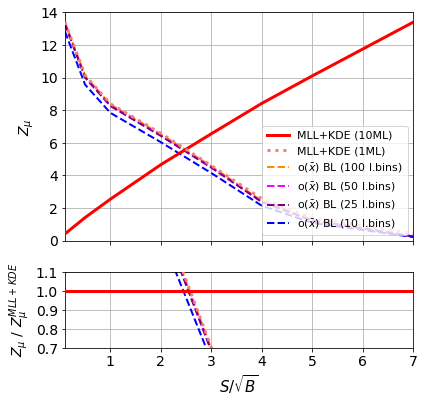

In [24]:
fig, axs = plt.subplots(2,1,figsize=(6,5.7), gridspec_kw={'height_ratios': [3, 1]})

axs[0].plot(ypoints, Z_MLL_10ML, label = 'MLL+KDE (10ML)', c = 'red', lw=3, zorder=5)
axs[0].plot(ypoints, Z_MLL, label = 'MLL+KDE (1ML)', color = 'lightcoral', linestyle = ':', lw=3, zorder=5)

axs[0].plot(ypoints, Z_100, label = r'o$(\bar{x})$ BL (100 l.bins)', color = 'darkorange', linestyle = '--', lw=2)
axs[0].plot(ypoints, Z_50, label = r'o$(\bar{x})$ BL (50 l.bins)', c = 'magenta', linestyle = '--', lw=2)
axs[0].plot(ypoints, Z_25, label = r'o$(\bar{x})$ BL (25 l.bins)', c = 'purple', linestyle = '--', lw=2)
axs[0].plot(ypoints, Z_10, label =r'o$(\bar{x})$ BL (10 l.bins)', c = 'blue', linestyle = '--', lw=2)

#axs[0].plot(ypoints, Z_100_10ML, label = r'o$(\bar{x})$ BL (100 l.bins) (ML)', color = 'darkorange', linestyle = ':', lw=2)
#axs[0].plot(ypoints, Z_50_10ML, label = r'o$(\bar{x})$ BL (50 l.bins) (ML)', c = 'magenta', linestyle = ':', lw=2)
#axs[0].plot(ypoints, Z_25_10ML, label = r'o$(\bar{x})$ BL (25 l.bins) (ML)', c = 'purple', linestyle = ':', lw=2)
#axs[0].plot(ypoints, Z_10_10ML, label =r'o$(\bar{x})$ BL (10 l.bins) (ML)', c = 'blue', linestyle = ':', lw=2)

#axs[0].plot(ypoints, Z_100_10ML_nl, label = r'o$(\bar{x})$ BL (100 n.l.bins) (ML)', color = 'darkorange', linestyle = ':', lw=2)
#axs[0].plot(ypoints, Z_50_10ML_nl, label = r'o$(\bar{x})$ BL (50 n.l.bins) (ML)', c = 'magenta', linestyle = ':', lw=2)
#axs[0].plot(ypoints, Z_25_10ML_nl, label = r'o$(\bar{x})$ BL (25 n.l.bins) (ML)', c = 'purple', linestyle = ':', lw=2)
#axs[0].plot(ypoints, Z_10_10ML_nl, label =r'o$(\bar{x})$ BL (10 n.l.bins) (ML)', c = 'blue', linestyle = ':', lw=2)

axs[1].plot(ypoints, Z_MLL_10ML / Z_MLL_10ML, label = 'MLL+KDE (10ML)', c = 'red', lw=3, zorder=5)
axs[1].plot(ypoints, Z_MLL / Z_MLL_10ML, label = 'MLL+KDE (1ML)', color = 'lightcoral', linestyle = ':', lw=3, zorder=5)

axs[1].plot(ypoints, Z_100 / Z_MLL_10ML, label = '100Bins', color = 'darkorange', linestyle = '--', lw=2)
axs[1].plot(ypoints, Z_50 / Z_MLL_10ML, label = '50Bins', c = 'magenta', linestyle = '--', lw=2)
axs[1].plot(ypoints, Z_25 / Z_MLL_10ML, label = '25Bins', c = 'purple', linestyle = '--', lw=2)
axs[1].plot(ypoints, Z_10 / Z_MLL_10ML, label = '10Bins', c = 'blue', linestyle = '--', lw=2)

#axs[1].plot(ypoints, Z_100_10ML / Z_MLL_10ML, label = '100Bins', color = 'darkorange', linestyle = '--', lw=2)
#axs[1].plot(ypoints, Z_50_10ML / Z_MLL_10ML, label = '50Bins', c = 'magenta', linestyle = '--', lw=2)
#axs[1].plot(ypoints, Z_25_10ML / Z_MLL_10ML, label = '25Bins', c = 'purple', linestyle = '--', lw=2)
#axs[1].plot(ypoints, Z_10_10ML / Z_MLL_10ML, label = '10Bins', c = 'blue', linestyle = '--', lw=2)

#axs[1].plot(ypoints, Z_100_10ML_nl / Z_MLL_10ML, label = '100Bins', color = 'darkorange', linestyle = ':', lw=2)
#axs[1].plot(ypoints, Z_50_10ML_nl / Z_MLL_10ML, label = '50Bins', c = 'magenta', linestyle = ':', lw=2)
#axs[1].plot(ypoints, Z_25_10ML_nl / Z_MLL_10ML, label = '25Bins', c = 'purple', linestyle = ':', lw=2)
#axs[1].plot(ypoints, Z_10_10ML_nl / Z_MLL_10ML, label = '10Bins', c = 'blue', linestyle = ':', lw=2)


axs[0].set_xlim([0.1, 7])
axs[0].set_ylim([0, 14])
axs[1].set_xlim([0.1, 7])
axs[1].set_ylim([0.7,1.1])
axs[0].set_ylabel('$Z_{\mu}$', fontsize=14)
axs[1].set_xlabel(r'$S/\sqrt{B}$', fontsize=15)
axs[1].set_ylabel(r'$Z_{\mu}$ / $Z_{\mu}^{MLL+KDE}$', fontsize=14)

axs[0].yaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_ticklabels([])
axs[1].yaxis.set_ticks([0.7,0.8,0.9,1,1.1])
axs[1].xaxis.set_tick_params(labelsize=14)
axs[1].yaxis.set_tick_params(labelsize=14)

axs[0].grid()
axs[1].grid()

#axs[0].set_title('Multivariate Gaussian distributions, $\mathcal{N}_{n}$', fontsize=14)
axs[0].legend(loc="lower right", fontsize=11)
plt.tight_layout()
plt.savefig('../graph/' + 'HH-Zexclusion.pdf', format="pdf", bbox_inches="tight")

In [26]:
print(Z_10_10ML)
print(Z_25_10ML)
print(Z_50_10ML)
print(Z_100_10ML)
print(Z_MLL_10ML)
print(ypoints)

[ 0.22216429  1.09322037  2.14606152  4.15013482  6.04254782  7.8439409
  9.56909687 12.83222207]
[ 0.25581102  1.23259443  2.37461287  4.48240827  6.42952615  8.26194731
 10.00528117 13.28507614]
[ 0.25923955  1.24463226  2.3921691   4.50540074  6.45540128  8.28969911
 10.03438437 13.31603403]
[ 0.26738351  1.27593833  2.4410955   4.57324539  6.53244851  8.37153584
 10.11871538 13.40201145]
[ 0.41651735  1.41898331  2.54461684  4.6629834   6.55767978  8.42147212
 10.10660067 13.40145885]
[0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0]


### Let's see what happens when varing the testset

Reading data from 0.0 ...
Classification score:


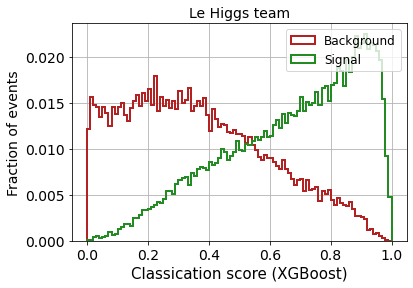

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.062443948800189

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.5237354291056295

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.666054436914805

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.607248549069432

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf   604.99021558   596.33082727
   577.95596041   545.87716347   491.44071434   400.82812146
   244.65954081   -56.91426625  -705.72482786 -1977.68027427]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   926.23048533   933.98038475   937.34652189   934.49112332
   923.35434633   892.56652409   827.20345129   696.85758104
   463.75233227    70.19705191  -633.44385896 -1949.96959177]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


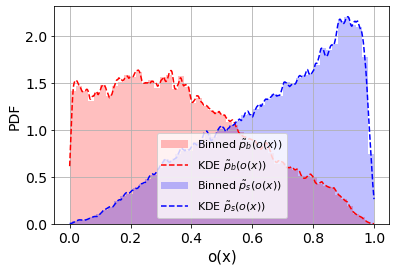

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



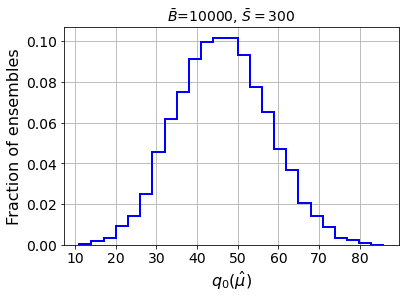

muhat mean:  0.04438394523957686
median q_muhat_KDE:  46.15542021214253
Z_KDE:  6.793778051433718
Z_KDE mu=0:  6.792627687556977

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.062443948800189
Z_XG 25 bins:  6.5237354291056295
Z_XG 50 bins:  6.666054436914805
Z_XG 100 bins:  6.607248549069432

 ----------------------------------------- 

muhat mean:  0.04438394523957686
median q_muhat_KDE:  46.15542021214253
Z_KDE:  6.793778051433718
Z_KDE mu=0:  6.792627687556977
The analysis for 1 testset of 10000 observations took 6.632901 minutes...
Reading data from 1.0 ...
Classification score:


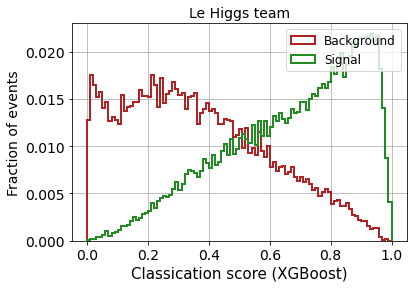

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.015553432123237

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.445392004956013

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.458692682234047

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.428652606529062

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   622.04157935   620.09110801   610.53681508
   590.25556108   554.42456924   493.1185556    399.74897264
   246.12290666   -56.44626848  -705.33970114 -1977.56306004]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf   953.997242
   961.11128728   963.82193239   964.47495708   962.51564747
   951.88671352   921.83433649   856.1375043    726.77167381
   495.66707416    99.55729689  -612.52878312 -1942.90024785]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


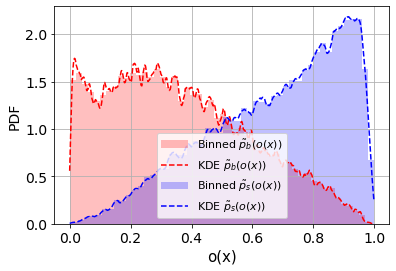

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



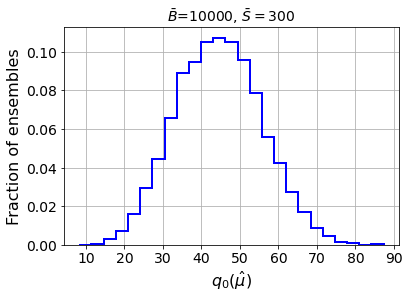

muhat mean:  0.043600912673719155
median q_muhat_KDE:  44.43519979027059
Z_KDE:  6.6659732815449075
Z_KDE mu=0:  6.66606867758186

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.015553432123237
Z_XG 25 bins:  6.445392004956013
Z_XG 50 bins:  6.458692682234047
Z_XG 100 bins:  6.428652606529062

 ----------------------------------------- 

muhat mean:  0.043600912673719155
median q_muhat_KDE:  44.43519979027059
Z_KDE:  6.6659732815449075
Z_KDE mu=0:  6.66606867758186
The analysis for 1 testset of 10000 observations took 6.623524 minutes...
Reading data from 2.0 ...
Classification score:


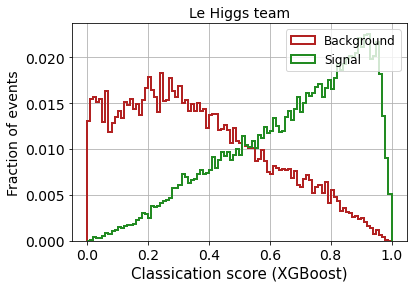

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.002106965955901

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.293994673847087

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.438768515114046

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.372847269812148

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   628.29906552   625.55663751   614.76220099
   596.43735464   562.69510394   506.10227162   418.8007464
   265.15155497   -47.20663527  -703.22235879 -1976.27122104]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf   954.12816406
   962.29416796   965.94788409   967.94404292   965.19527089
   954.98128245   927.14448316   863.41578962   739.81950873
   517.31407245   121.63109879  -602.62279539 -1939.62796264]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


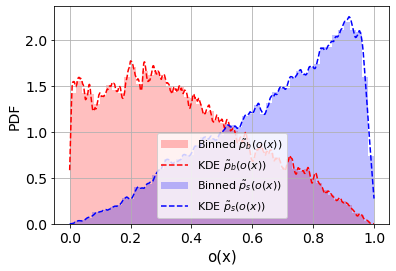

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



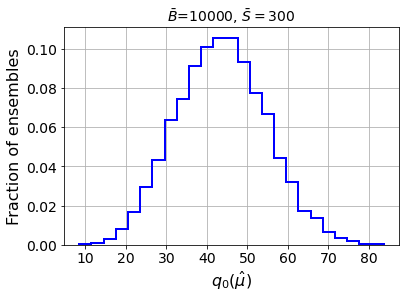

muhat mean:  0.040385812072184196
median q_muhat_KDE:  43.44476360905202
Z_KDE:  6.591264188989243
Z_KDE mu=0:  6.591324016142746

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.002106965955901
Z_XG 25 bins:  6.293994673847087
Z_XG 50 bins:  6.438768515114046
Z_XG 100 bins:  6.372847269812148

 ----------------------------------------- 

muhat mean:  0.040385812072184196
median q_muhat_KDE:  43.44476360905202
Z_KDE:  6.591264188989243
Z_KDE mu=0:  6.591324016142746
The analysis for 1 testset of 10000 observations took 6.581551 minutes...
Reading data from 3.0 ...
Classification score:


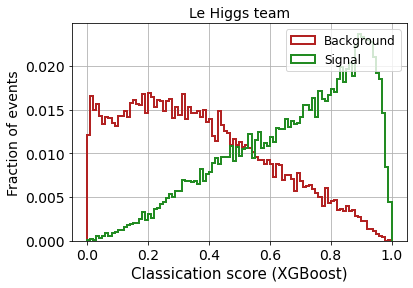

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.121438164172623

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.4199575205027335

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.574996937751368

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.5200992429684845

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf   613.68149621
   593.96620703   559.25412972   503.35725824   415.38501028
   259.97995515   -48.14823001  -701.55699713 -1976.07824052]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf   997.87547135   995.66829976
   985.61841208   956.81798214   892.33359705   759.6475103
   522.20571181   117.26393338  -601.76336461 -1939.08037137]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


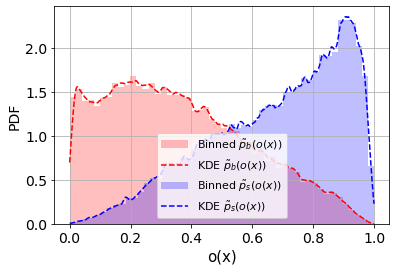

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



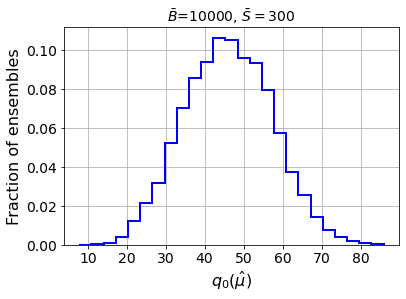

muhat mean:  0.03594689898361336
median q_muhat_KDE:  45.94906501322163
Z_KDE:  6.778573966050796
Z_KDE mu=0:  6.778311125223376

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.121438164172623
Z_XG 25 bins:  6.4199575205027335
Z_XG 50 bins:  6.574996937751368
Z_XG 100 bins:  6.5200992429684845

 ----------------------------------------- 

muhat mean:  0.03594689898361336
median q_muhat_KDE:  45.94906501322163
Z_KDE:  6.778573966050796
Z_KDE mu=0:  6.778311125223376
The analysis for 1 testset of 10000 observations took 6.575800 minutes...
Reading data from 4.0 ...
Classification score:


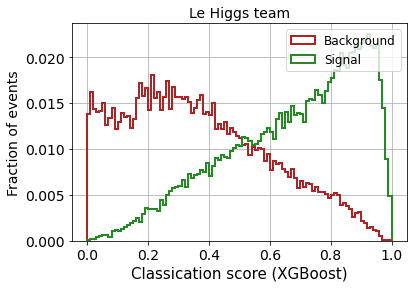

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.0409559257695244

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.410383227602372

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.46838945640417

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.532813032319534

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf   587.91255367
   568.24562283   534.4002494    477.98465782   386.5551825
   238.01197359   -61.10006026  -709.12994317 -1978.95486248]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   963.26368535   966.86340384   964.56819161
   954.76153226   925.45943523   861.74892429   735.8930318
   504.64060467   104.16628198  -612.33338076 -1942.66875816]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


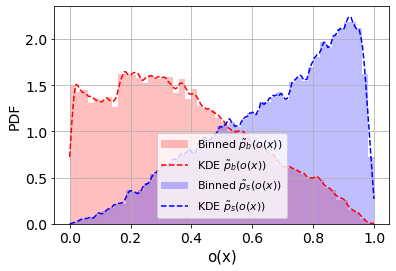

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



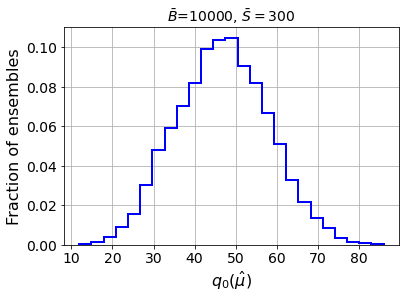

muhat mean:  0.02906036092097076
median q_muhat_KDE:  46.85280467044578
Z_KDE:  6.844910859203776
Z_KDE mu=0:  6.844910859203776

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.0409559257695244
Z_XG 25 bins:  6.410383227602372
Z_XG 50 bins:  6.46838945640417
Z_XG 100 bins:  6.532813032319534

 ----------------------------------------- 

muhat mean:  0.02906036092097076
median q_muhat_KDE:  46.85280467044578
Z_KDE:  6.844910859203776
Z_KDE mu=0:  6.844910859203776
The analysis for 1 testset of 10000 observations took 6.523707 minutes...
Reading data from 5.0 ...
Classification score:


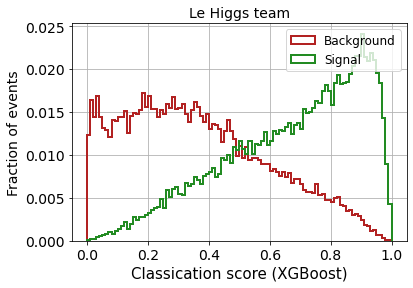

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  5.998939668888548

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.229398390399502

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.325023057684492

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.400008338560796

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf   595.18903901
   602.86852207   604.9504913    602.1477561    591.26740566
   571.97655708   536.34611151   479.91440607   392.28413675
   237.37292189   -64.60938109  -712.29059034 -1979.89050099]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   940.28940948   945.57314356   945.33479845   941.95313739
   931.7513341    903.22173449   840.54235927   713.65841485
   486.56323531    93.00562641  -619.49714407 -1945.41702219]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


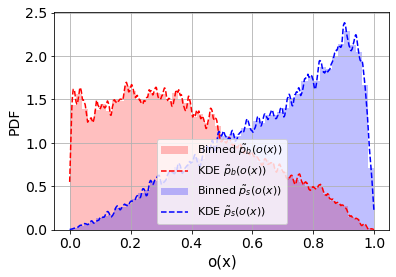

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



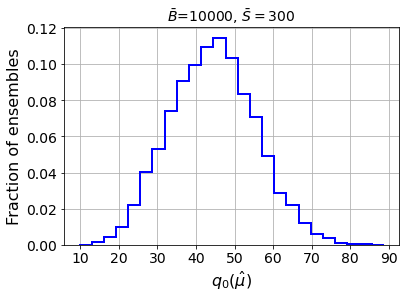

muhat mean:  0.03180875337066999
median q_muhat_KDE:  44.310577112209046
Z_KDE:  6.6566190451466465
Z_KDE mu=0:  6.6566190451466465

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  5.998939668888548
Z_XG 25 bins:  6.229398390399502
Z_XG 50 bins:  6.325023057684492
Z_XG 100 bins:  6.400008338560796

 ----------------------------------------- 

muhat mean:  0.03180875337066999
median q_muhat_KDE:  44.310577112209046
Z_KDE:  6.6566190451466465
Z_KDE mu=0:  6.6566190451466465
The analysis for 1 testset of 10000 observations took 6.707532 minutes...
Reading data from 6.0 ...
Classification score:


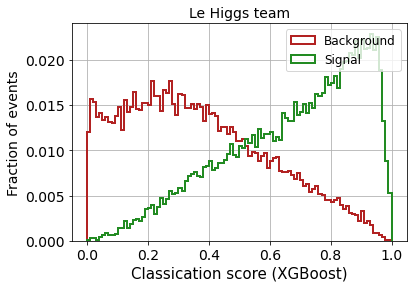

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  5.854395074647396

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.188294779961312

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.3101777449645065

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.3344435760234505

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   602.41550898   600.28891488   591.49758395
   572.86700878   540.22327203   486.37634111   400.37625333
   250.02155462   -52.48003216  -704.21836298 -1977.21828764]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   977.08059828   982.82736952   982.17413954   979.4168895
   969.57839599   940.66662298   875.32527639   748.95317399
   519.83450469   119.25011141  -602.77750378 -1939.51241629]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


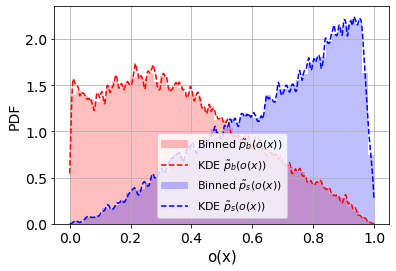

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



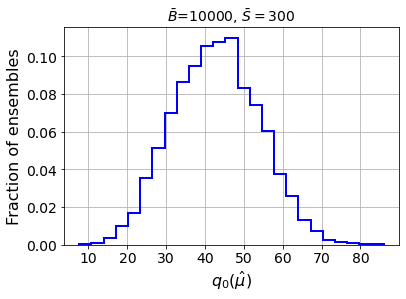

muhat mean:  0.04575814146442647
median q_muhat_KDE:  42.7764115278527
Z_KDE:  6.540367843466658
Z_KDE mu=0:  6.540987615308584

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  5.854395074647396
Z_XG 25 bins:  6.188294779961312
Z_XG 50 bins:  6.3101777449645065
Z_XG 100 bins:  6.3344435760234505

 ----------------------------------------- 

muhat mean:  0.04575814146442647
median q_muhat_KDE:  42.7764115278527
Z_KDE:  6.540367843466658
Z_KDE mu=0:  6.540987615308584
The analysis for 1 testset of 10000 observations took 6.578767 minutes...
Reading data from 7.0 ...
Classification score:


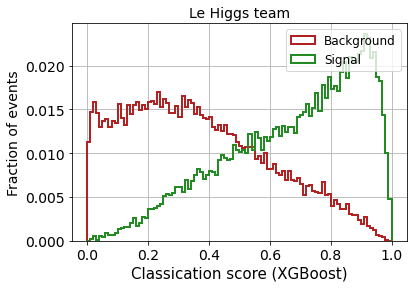

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.008391156903873

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.325915052643252

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.465534875117396

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.4006866134642495

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   601.92645688   606.2763563    604.98926757   596.99545522
   579.10470157   547.03713274   494.14944088   406.9858618
   252.21092013   -55.40848421  -706.95160345 -1977.79426541]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   956.71432278   961.32095274   961.5964691    958.45688762
   947.69609824   920.0985045    857.50394259   730.65037569
   500.10571471    97.22369019  -615.4684546  -1943.67613279]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


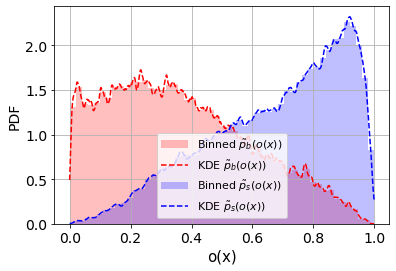

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



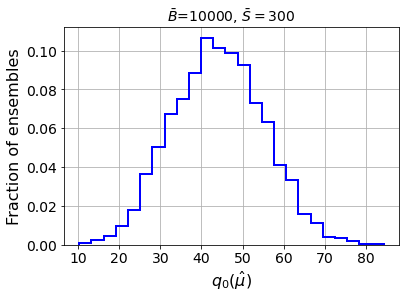

muhat mean:  0.0373988799004356
median q_muhat_KDE:  44.09780737116557
Z_KDE:  6.640617996178185
Z_KDE mu=0:  6.640617996178185

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.008391156903873
Z_XG 25 bins:  6.325915052643252
Z_XG 50 bins:  6.465534875117396
Z_XG 100 bins:  6.4006866134642495

 ----------------------------------------- 

muhat mean:  0.0373988799004356
median q_muhat_KDE:  44.09780737116557
Z_KDE:  6.640617996178185
Z_KDE mu=0:  6.640617996178185
The analysis for 1 testset of 10000 observations took 6.650196 minutes...
Reading data from 8.0 ...
Classification score:


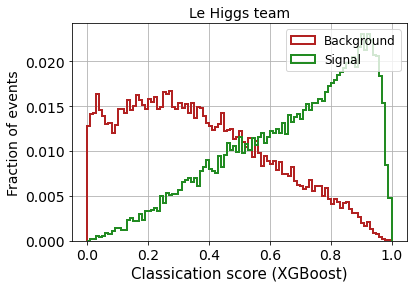

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.1259389016718

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.412836774787776

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.500614967379848

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.528180561401639

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   596.90964505   594.84040157   586.79961877
   570.76886602   537.8278327    481.917966     397.16093196
   244.28914341   -59.75836693  -707.00367763 -1977.91031116]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf   918.83569428   934.98665776
   944.10772872   949.44007228   951.54744053   948.8817079
   938.49853662   909.09481245   845.55001988   719.16314955
   488.03350007    89.05404604  -623.34071992 -1946.7078877 ]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


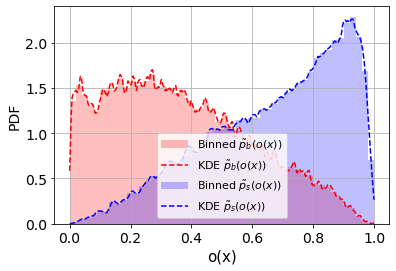

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



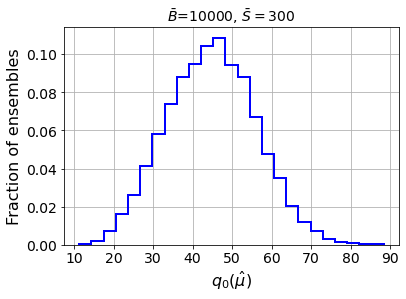

muhat mean:  0.04743310516490355
median q_muhat_KDE:  44.88174008210723
Z_KDE:  6.699383559858864
Z_KDE mu=0:  6.69993900873371

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.1259389016718
Z_XG 25 bins:  6.412836774787776
Z_XG 50 bins:  6.500614967379848
Z_XG 100 bins:  6.528180561401639

 ----------------------------------------- 

muhat mean:  0.04743310516490355
median q_muhat_KDE:  44.88174008210723
Z_KDE:  6.699383559858864
Z_KDE mu=0:  6.69993900873371
The analysis for 1 testset of 10000 observations took 6.668433 minutes...
Reading data from 9.0 ...
Classification score:


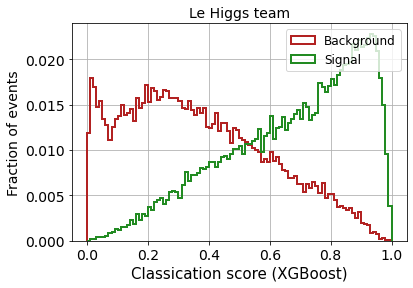

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.239103799829688

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.5773539511291625

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.611418835815143

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.660494029378513

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   620.61055681   622.31767585   620.00484939   610.729807
   591.15389544   553.21804061   493.77244688   405.67747171
   257.08998697   -46.82414218  -698.14012589 -1974.82719925]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf   965.97126075   963.56030642
   951.5437781    922.46652384   856.22367957   726.96943075
   493.43349975    93.67305994  -618.57663492 -1944.85524164]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


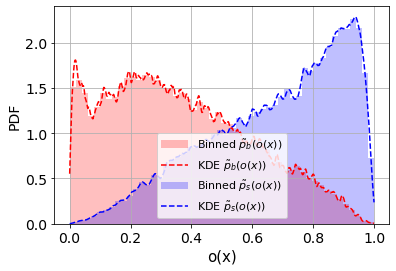

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



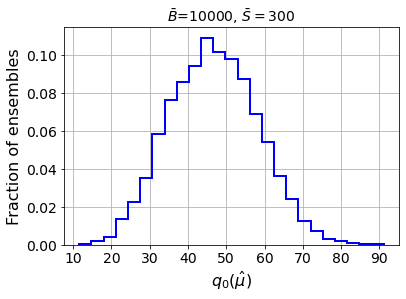

muhat mean:  0.046494503215100604
median q_muhat_KDE:  46.50715924266427
Z_KDE:  6.819615769430436
Z_KDE mu=0:  6.820383480971034

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.239103799829688
Z_XG 25 bins:  6.5773539511291625
Z_XG 50 bins:  6.611418835815143
Z_XG 100 bins:  6.660494029378513

 ----------------------------------------- 

muhat mean:  0.046494503215100604
median q_muhat_KDE:  46.50715924266427
Z_KDE:  6.819615769430436
Z_KDE mu=0:  6.820383480971034
The analysis for 1 testset of 10000 observations took 6.698795 minutes...
Reading data from 10.0 ...
Classification score:


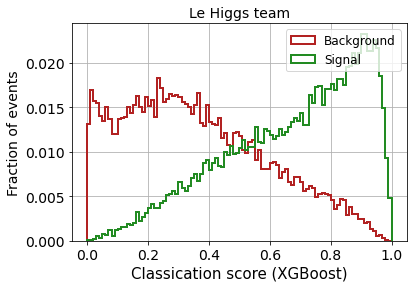

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.049623794315642

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.329753447133346

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.463938834322044

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.4478562114858375

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf   609.35474295
   616.07288303   619.16972822   616.48703492   605.2945131
   584.32292332   549.10364924   490.31732846   400.7303608
   247.61858673   -55.7950844   -707.73333716 -1978.39148488]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   944.10307943   945.61088455   943.49624942
   932.53111429   903.31795121   837.05618149   705.14346693
   474.53535248    73.96415383  -630.95408122 -1949.17371682]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


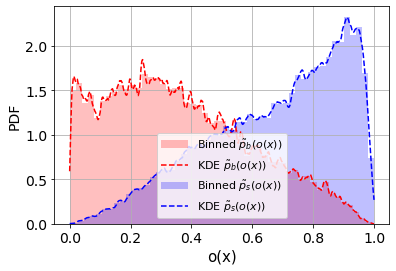

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



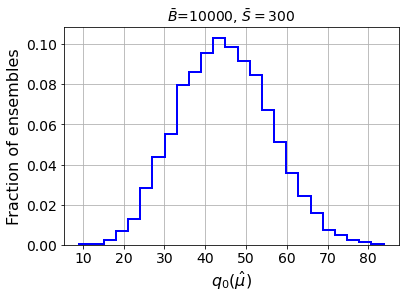

muhat mean:  0.0440883634100809
median q_muhat_KDE:  44.56690012552491
Z_KDE:  6.675844525266066
Z_KDE mu=0:  6.675844525266066

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.049623794315642
Z_XG 25 bins:  6.329753447133346
Z_XG 50 bins:  6.463938834322044
Z_XG 100 bins:  6.4478562114858375

 ----------------------------------------- 

muhat mean:  0.0440883634100809
median q_muhat_KDE:  44.56690012552491
Z_KDE:  6.675844525266066
Z_KDE mu=0:  6.675844525266066
The analysis for 1 testset of 10000 observations took 6.674702 minutes...
Reading data from 11.0 ...
Classification score:


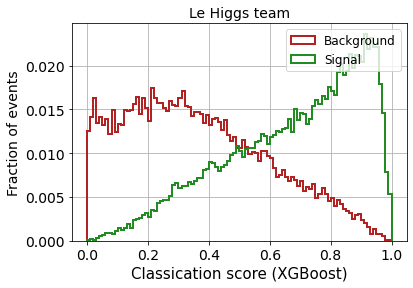

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.092282239760141

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.290066634865646

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.3945437834999295

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.470398384464059

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf   610.9580238    602.47009958
   584.26604988   551.24106181   496.77097489   411.87840253
   260.72379585   -42.39794544  -696.19533512 -1974.26576802]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   959.64595022   961.39916137   959.74042137
   949.89150573   919.98898646   851.86647048   721.15208228
   485.14487279    84.30390054  -627.85923348 -1947.83125088]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


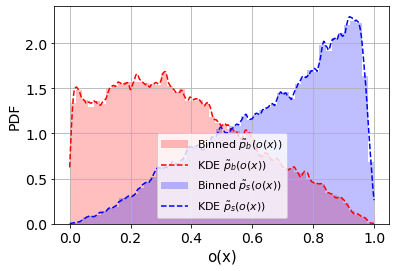

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



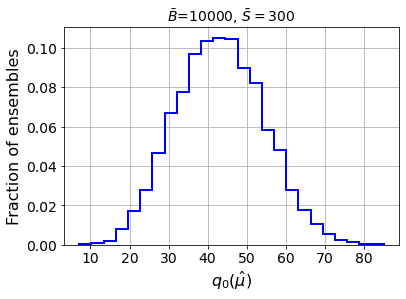

muhat mean:  0.04990665836963286
median q_muhat_KDE:  42.959323258684606
Z_KDE:  6.554336218007481
Z_KDE mu=0:  6.554453676292688

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.092282239760141
Z_XG 25 bins:  6.290066634865646
Z_XG 50 bins:  6.3945437834999295
Z_XG 100 bins:  6.470398384464059

 ----------------------------------------- 

muhat mean:  0.04990665836963286
median q_muhat_KDE:  42.959323258684606
Z_KDE:  6.554336218007481
Z_KDE mu=0:  6.554453676292688
The analysis for 1 testset of 10000 observations took 6.739207 minutes...
Reading data from 12.0 ...
Classification score:


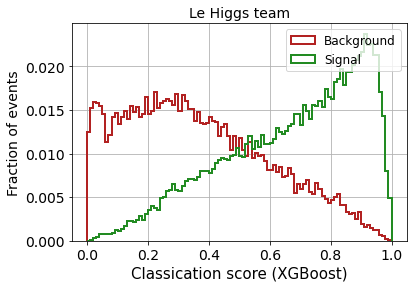

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  5.9393866117687555

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.05991599702952

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.140056380837364

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.167373525140224

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   591.52240407   594.5271966    593.8906789    586.17315871
   568.50021723   534.05752104   478.22875974   392.70893747
   241.03722765   -61.65489817  -710.98179399 -1979.59597458]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf   930.48296976   928.8125709
   918.99233732   890.92633706   824.97912488   695.15517655
   464.67114855    65.99974215  -636.36404381 -1950.92655603]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


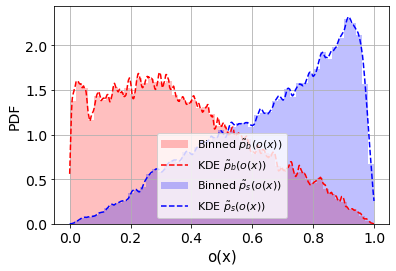

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



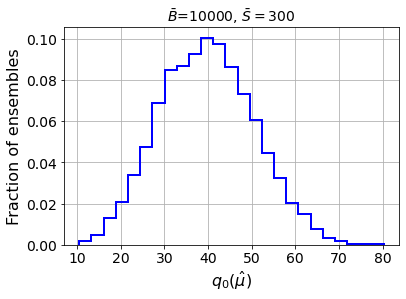

muhat mean:  0.05337066998548019
median q_muhat_KDE:  39.67060615755412
Z_KDE:  6.298460618083923
Z_KDE mu=0:  6.298945730573358

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  5.9393866117687555
Z_XG 25 bins:  6.05991599702952
Z_XG 50 bins:  6.140056380837364
Z_XG 100 bins:  6.167373525140224

 ----------------------------------------- 

muhat mean:  0.05337066998548019
median q_muhat_KDE:  39.67060615755412
Z_KDE:  6.298460618083923
Z_KDE mu=0:  6.298945730573358
The analysis for 1 testset of 10000 observations took 6.854958 minutes...
Reading data from 13.0 ...
Classification score:


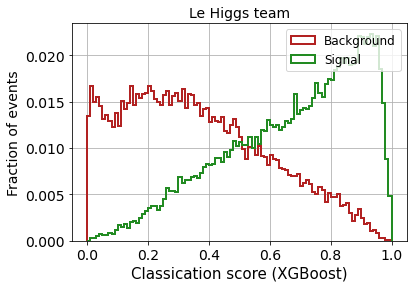

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.078492132908552

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.493041300500265

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.542558941184783

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.600360966756008

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf   601.37608884
   611.0773997    614.6013708    611.71284789   601.57390435
   581.95707818   547.21388966   489.86494413   404.46524237
   251.5937232    -54.70730158  -706.64213349 -1977.85033082]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf   932.75815306
   940.59198229   945.57972426   947.69700056   943.98511132
   932.81134978   902.69631185   837.28139677   711.35393437
   484.28857541    87.71067778  -622.41938289 -1946.45056277]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


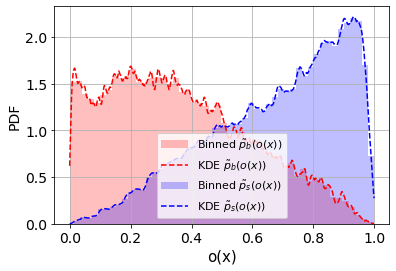

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



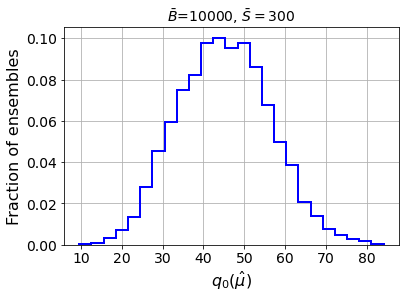

muhat mean:  0.04959551960174238
median q_muhat_KDE:  45.076852547452745
Z_KDE:  6.713929739537996
Z_KDE mu=0:  6.715108030761892

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.078492132908552
Z_XG 25 bins:  6.493041300500265
Z_XG 50 bins:  6.542558941184783
Z_XG 100 bins:  6.600360966756008

 ----------------------------------------- 

muhat mean:  0.04959551960174238
median q_muhat_KDE:  45.076852547452745
Z_KDE:  6.713929739537996
Z_KDE mu=0:  6.715108030761892
The analysis for 1 testset of 10000 observations took 6.635778 minutes...
Reading data from 14.0 ...
Classification score:


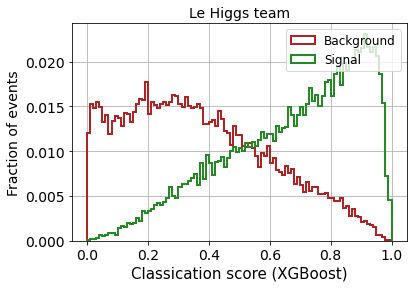

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  5.892390207598187

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.129220870144463

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.181673327301216

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.242112394527556

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   593.03916755   589.08590417   578.75646796
   561.03656988   526.73270903   470.22844788   381.48548302
   231.19208233   -64.8680652   -709.50157854 -1979.29725603]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf   963.84188835
   970.59436154   974.49096668   975.58642046   973.26406673
   963.03539314   932.89402346   867.94248789   740.71918983
   512.22445039   111.14526342  -608.0442979  -1941.33063935]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


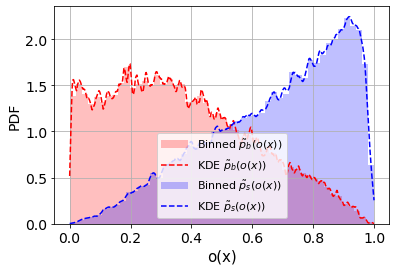

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



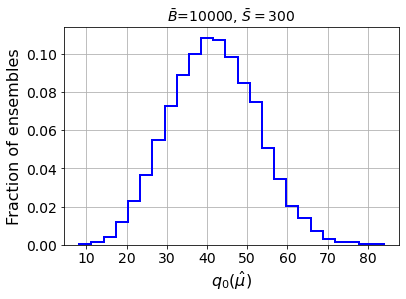

muhat mean:  0.04418689068657956
median q_muhat_KDE:  41.50381531161179
Z_KDE:  6.442345482168105
Z_KDE mu=0:  6.442345482168105

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  5.892390207598187
Z_XG 25 bins:  6.129220870144463
Z_XG 50 bins:  6.181673327301216
Z_XG 100 bins:  6.242112394527556

 ----------------------------------------- 

muhat mean:  0.04418689068657956
median q_muhat_KDE:  41.50381531161179
Z_KDE:  6.442345482168105
Z_KDE mu=0:  6.442345482168105
The analysis for 1 testset of 10000 observations took 6.703315 minutes...
Reading data from 15.0 ...
Classification score:


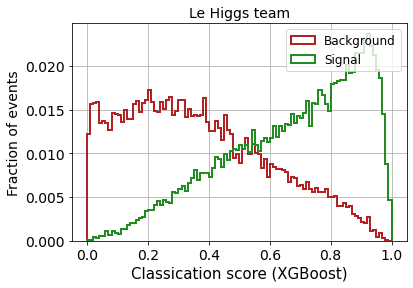

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  5.915555894535187

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.114949469512083

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.265089463189811

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.297110705855503

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   593.7512339    594.58272109   592.45252417   583.96232281
   565.95471272   530.69736049   475.99073549   387.14856741
   230.95010926   -76.34643655  -722.06387348 -1983.21615207]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf   955.76038471   952.96420594
   942.66994149   913.80806418   847.27766605   717.26980039
   487.72277137    92.63155024  -618.95285121 -1945.22488723]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


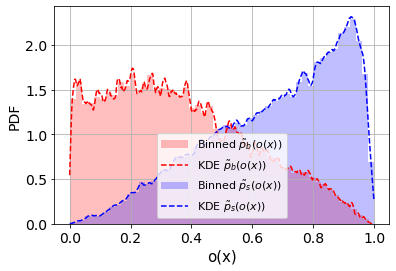

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



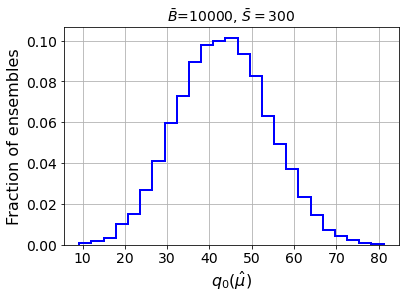

muhat mean:  0.03485791329599668
median q_muhat_KDE:  43.20468862511888
Z_KDE:  6.5730273561821475
Z_KDE mu=0:  6.5730273561821475

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  5.915555894535187
Z_XG 25 bins:  6.114949469512083
Z_XG 50 bins:  6.265089463189811
Z_XG 100 bins:  6.297110705855503

 ----------------------------------------- 

muhat mean:  0.03485791329599668
median q_muhat_KDE:  43.20468862511888
Z_KDE:  6.5730273561821475
Z_KDE mu=0:  6.5730273561821475
The analysis for 1 testset of 10000 observations took 6.736450 minutes...
Reading data from 16.0 ...
Classification score:


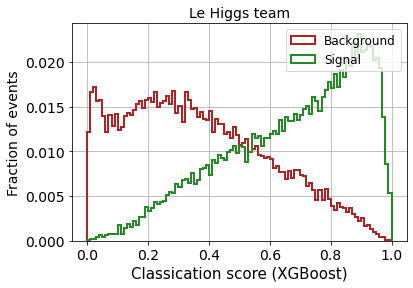

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.0794036194108365

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.3871250243314455

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.4389435642809385

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.478869688151233

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   616.1654103    613.81163763   605.23023994
   585.70727144   548.27487483   488.1018501    396.04986967
   246.42200481   -54.91771257  -703.16125867 -1976.80428109]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   950.2793367    949.96709745   948.08659901
   939.51357587   912.06080356   849.69737895   722.60212048
   487.95714841    83.4702277   -623.4698789  -1946.3761581 ]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


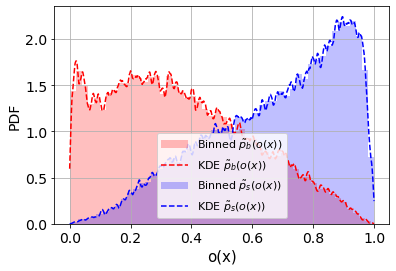

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



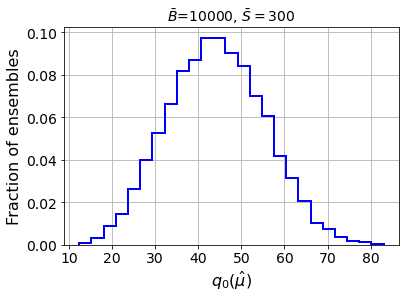

muhat mean:  0.04570109935697988
median q_muhat_KDE:  44.09790462608538
Z_KDE:  6.640625318905244
Z_KDE mu=0:  6.641679687466927

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.0794036194108365
Z_XG 25 bins:  6.3871250243314455
Z_XG 50 bins:  6.4389435642809385
Z_XG 100 bins:  6.478869688151233

 ----------------------------------------- 

muhat mean:  0.04570109935697988
median q_muhat_KDE:  44.09790462608538
Z_KDE:  6.640625318905244
Z_KDE mu=0:  6.641679687466927
The analysis for 1 testset of 10000 observations took 6.746703 minutes...
Reading data from 17.0 ...
Classification score:


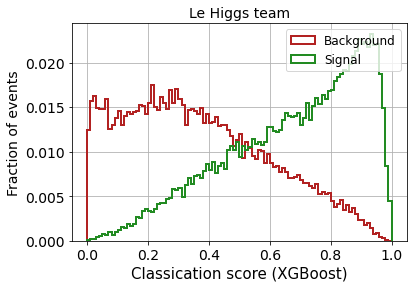

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.118759021496021

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.509368477976695

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.671332982266227

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.624255526849344

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf   595.76934788   587.17046664
   569.28846915   535.81789001   477.13175776   383.08738123
   228.04018489   -74.31465858  -717.37891324 -1981.59842395]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf   979.88236571   977.96647301
   969.06548861   940.02578655   874.41216562   745.98512088
   513.6971502    115.15904061  -606.35156139 -1940.72941258]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


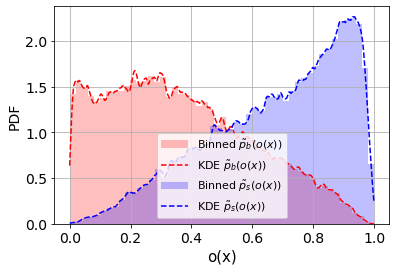

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



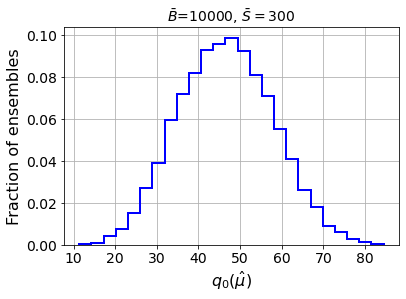

muhat mean:  0.04003318813524165
median q_muhat_KDE:  46.57902445911748
Z_KDE:  6.824882743250427
Z_KDE mu=0:  6.825492405503912

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.118759021496021
Z_XG 25 bins:  6.509368477976695
Z_XG 50 bins:  6.671332982266227
Z_XG 100 bins:  6.624255526849344

 ----------------------------------------- 

muhat mean:  0.04003318813524165
median q_muhat_KDE:  46.57902445911748
Z_KDE:  6.824882743250427
Z_KDE mu=0:  6.825492405503912
The analysis for 1 testset of 10000 observations took 6.753905 minutes...
Reading data from 18.0 ...
Classification score:


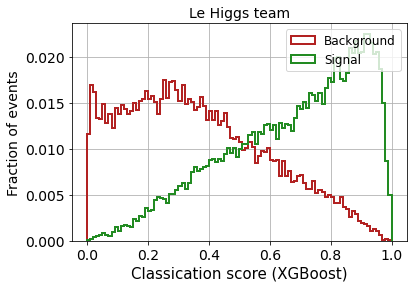

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.1030974522384955

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.410911614145856

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.435936139545531

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.57625467682118

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   622.84757865   620.21859261   609.87408866
   588.98666418   554.19068925   498.65752819   410.55095362
   258.23806442   -43.08330693  -696.70817816 -1974.43400955]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   930.36399447   934.9312287    936.85909042   934.69331604
   922.82128458   891.45514307   826.42448883   702.02671201
   477.8925596     83.88564319  -623.12037973 -1946.7430499 ]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


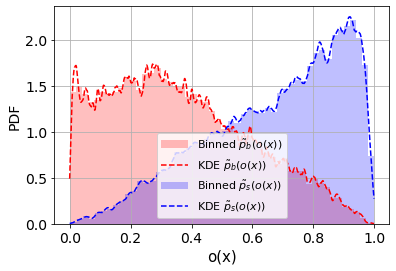

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



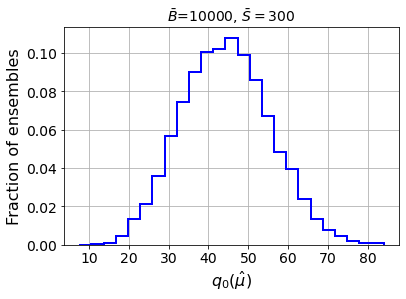

muhat mean:  0.04687305538270069
median q_muhat_KDE:  44.26848678766521
Z_KDE:  6.653456754775311
Z_KDE mu=0:  6.65359338440792

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.1030974522384955
Z_XG 25 bins:  6.410911614145856
Z_XG 50 bins:  6.435936139545531
Z_XG 100 bins:  6.57625467682118

 ----------------------------------------- 

muhat mean:  0.04687305538270069
median q_muhat_KDE:  44.26848678766521
Z_KDE:  6.653456754775311
Z_KDE mu=0:  6.65359338440792
The analysis for 1 testset of 10000 observations took 6.905269 minutes...
Reading data from 19.0 ...
Classification score:


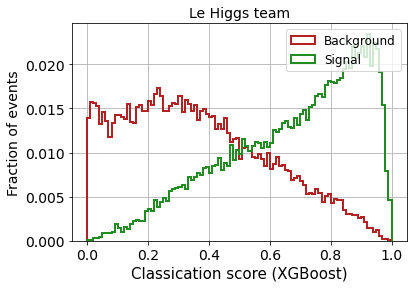

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.006408409179045

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.350800288811307

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.366834943112266

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.423728446169347

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   609.59641025   606.4892476    596.81687772
   576.59507451   542.17076695   486.48800406   399.27937842
   250.21195192   -51.66996978  -702.41525878 -1976.53246213]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   955.29579952   959.39795014   959.63887524   957.74842773
   947.8058349    916.76113552   849.01635359   719.54657462
   486.66339187    79.4405517   -630.81442312 -1948.88615226]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


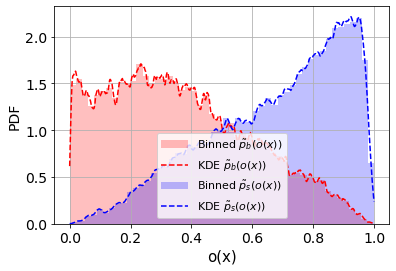

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



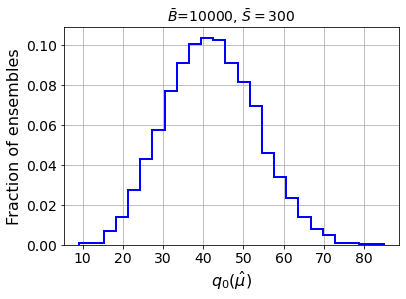

muhat mean:  0.058800041485169055
median q_muhat_KDE:  41.83518451454296
Z_KDE:  6.468012408347943
Z_KDE mu=0:  6.469319361837808

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.006408409179045
Z_XG 25 bins:  6.350800288811307
Z_XG 50 bins:  6.366834943112266
Z_XG 100 bins:  6.423728446169347

 ----------------------------------------- 

muhat mean:  0.058800041485169055
median q_muhat_KDE:  41.83518451454296
Z_KDE:  6.468012408347943
Z_KDE mu=0:  6.469319361837808
The analysis for 1 testset of 10000 observations took 6.826214 minutes...
Reading data from 20.0 ...
Classification score:


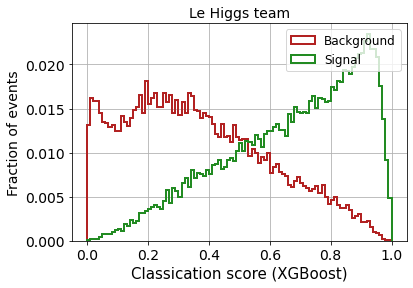

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  5.934868997260504

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.211893093801027

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.337127544765377

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.390527175024038

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   597.70811156   597.1522147    588.98124129
   569.46028633   533.08536707   474.57745256   385.00100934
   236.90668863   -63.52683857  -710.5171258  -1979.45848582]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   940.63628809   944.4645533    943.96634955   942.10565853
   931.78026561   904.34328921   839.01569128   708.2435997
   479.60406931    89.84541512  -622.56594081 -1946.28117111]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


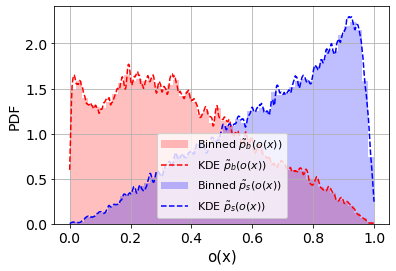

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



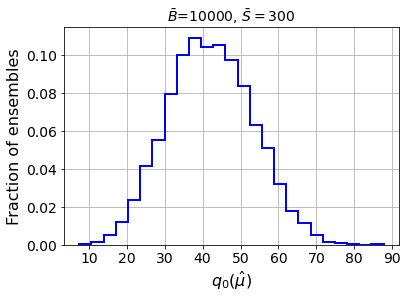

muhat mean:  0.054905621240406564
median q_muhat_KDE:  41.78400099160899
Z_KDE:  6.4640545319179505
Z_KDE mu=0:  6.46454551611549

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  5.934868997260504
Z_XG 25 bins:  6.211893093801027
Z_XG 50 bins:  6.337127544765377
Z_XG 100 bins:  6.390527175024038

 ----------------------------------------- 

muhat mean:  0.054905621240406564
median q_muhat_KDE:  41.78400099160899
Z_KDE:  6.4640545319179505
Z_KDE mu=0:  6.46454551611549
The analysis for 1 testset of 10000 observations took 6.870433 minutes...
Reading data from 21.0 ...
Classification score:


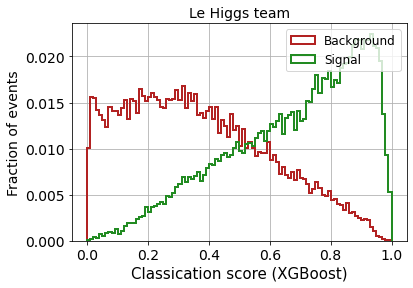

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.022467069108631

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.463057769951749

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.5497642900670385

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.6184985080764305

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   604.62220466   601.6451821    594.01296933
   576.56705629   543.41086301   491.59324705   405.94402136
   253.3426081    -48.14224418  -698.6881525  -1975.16363459]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   979.56197212   983.52298387   983.79087502   981.89308663
   971.61247441   941.32774822   875.38098586   747.36940451
   516.72141708   111.53875133  -609.33490878 -1941.65757102]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


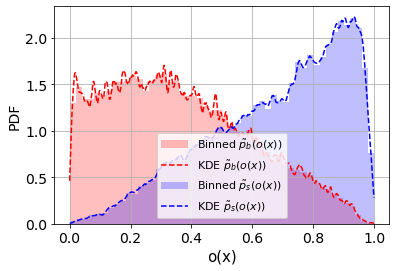

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



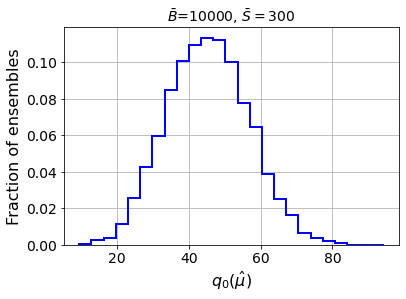

muhat mean:  0.051607550300767475
median q_muhat_KDE:  45.308545495282544
Z_KDE:  6.7311622692728585
Z_KDE mu=0:  6.732267513065085

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.022467069108631
Z_XG 25 bins:  6.463057769951749
Z_XG 50 bins:  6.5497642900670385
Z_XG 100 bins:  6.6184985080764305

 ----------------------------------------- 

muhat mean:  0.051607550300767475
median q_muhat_KDE:  45.308545495282544
Z_KDE:  6.7311622692728585
Z_KDE mu=0:  6.732267513065085
The analysis for 1 testset of 10000 observations took 6.919133 minutes...
Reading data from 22.0 ...
Classification score:


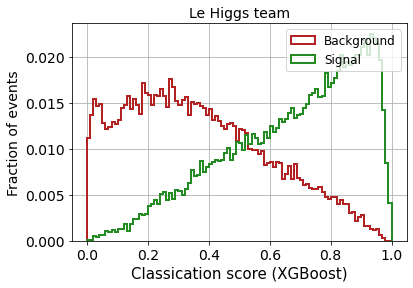

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  5.958957955556397

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.301503687975935

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.075091274995798

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.1420485765208275

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf   597.17275014
   604.17195408   607.5057749    604.68560522   598.3449535
   581.92577576   550.02319272   495.79383078   412.79571229
   262.99604264   -42.55592617  -697.48707508 -1974.54537736]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   941.15343375   942.54237674   940.01466982
   929.70079632   899.7292065    833.2847632    708.85666954
   483.51295285    88.11677893  -623.3036187  -1946.8028768 ]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


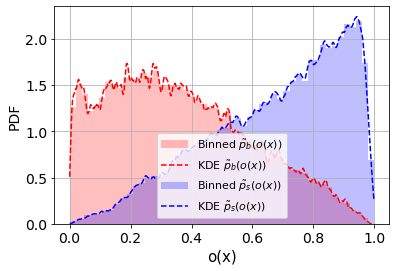

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



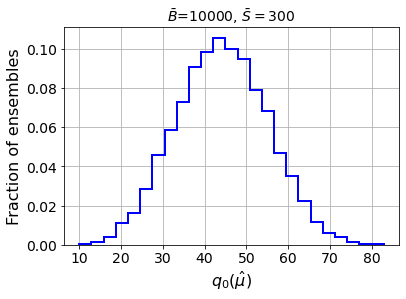

muhat mean:  0.031279817465256175
median q_muhat_KDE:  44.063441801315435
Z_KDE:  6.6380299638759865
Z_KDE mu=0:  6.6380299638759865

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  5.958957955556397
Z_XG 25 bins:  6.301503687975935
Z_XG 50 bins:  6.075091274995798
Z_XG 100 bins:  6.1420485765208275

 ----------------------------------------- 

muhat mean:  0.031279817465256175
median q_muhat_KDE:  44.063441801315435
Z_KDE:  6.6380299638759865
Z_KDE mu=0:  6.6380299638759865
The analysis for 1 testset of 10000 observations took 6.699572 minutes...
Reading data from 23.0 ...
Classification score:


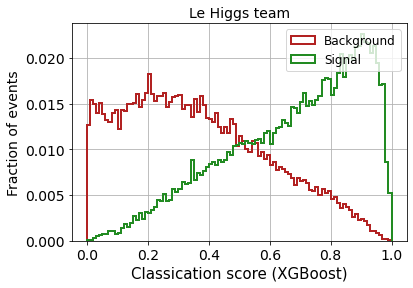

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.040044621272863

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.379366928064434

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.416392111387734

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.494623152509189

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   609.05274324   606.30451838   597.91636487
   580.31716946   547.0376262    492.91725483   407.92260607
   256.22870302   -49.11271808  -700.6668661  -1975.71895563]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   941.79285924   941.27273602   938.27354617
   928.24335461   899.75083694   838.3499971    716.03501965
   494.31938343    99.54099946  -615.49884785 -1944.08025461]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


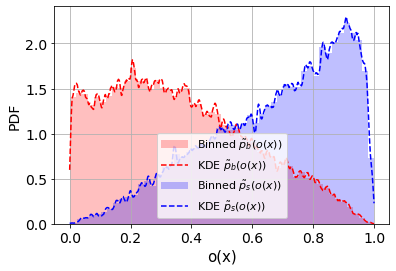

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



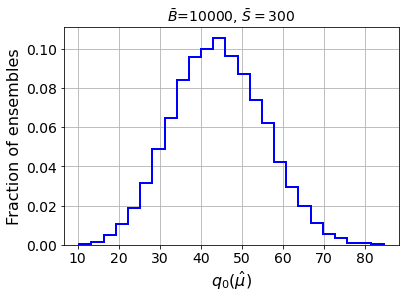

muhat mean:  0.04799315494710641
median q_muhat_KDE:  44.08689846867014
Z_KDE:  6.6397965683197055
Z_KDE mu=0:  6.640865888315525

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.040044621272863
Z_XG 25 bins:  6.379366928064434
Z_XG 50 bins:  6.416392111387734
Z_XG 100 bins:  6.494623152509189

 ----------------------------------------- 

muhat mean:  0.04799315494710641
median q_muhat_KDE:  44.08689846867014
Z_KDE:  6.6397965683197055
Z_KDE mu=0:  6.640865888315525
The analysis for 1 testset of 10000 observations took 6.799214 minutes...
Reading data from 24.0 ...
Classification score:


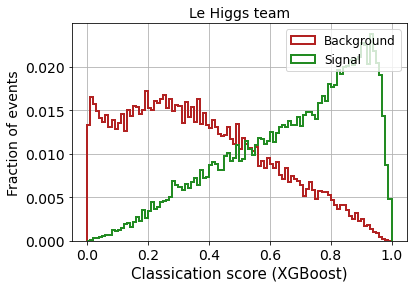

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.119260568736791

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.482690128604921

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.553483524087074

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.509086410427225

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   605.39312695   606.19639762   602.04689553   593.33054504
   574.68247842   539.8466151    482.44343002   393.02111369
   241.21687513   -59.55626626  -706.21015899 -1977.88943856]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   950.25927032   952.03943208   949.64203652
   939.84109483   911.45902435   846.8451149    721.27920132
   487.88912567    85.73893984  -626.38449032 -1947.38194918]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


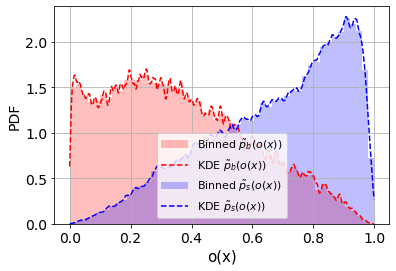

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



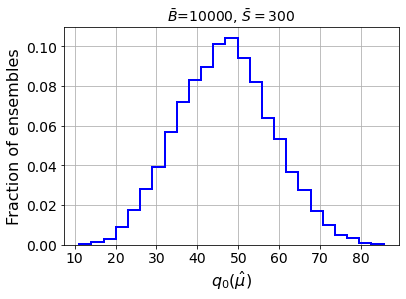

muhat mean:  0.036864758348890275
median q_muhat_KDE:  46.83697848648143
Z_KDE:  6.8437547067732805
Z_KDE mu=0:  6.8437547067732805

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.119260568736791
Z_XG 25 bins:  6.482690128604921
Z_XG 50 bins:  6.553483524087074
Z_XG 100 bins:  6.509086410427225

 ----------------------------------------- 

muhat mean:  0.036864758348890275
median q_muhat_KDE:  46.83697848648143
Z_KDE:  6.8437547067732805
Z_KDE mu=0:  6.8437547067732805
The analysis for 1 testset of 10000 observations took 6.746009 minutes...
Reading data from 25.0 ...
Classification score:


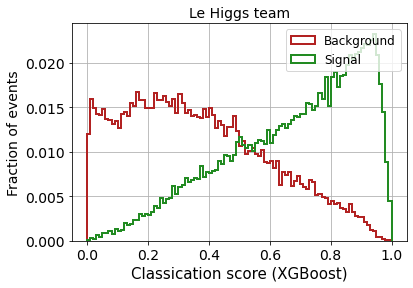

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.104347108433655

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.533631181093931

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.6475774291629515

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.722898543826794

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf   615.80245269   607.68568697
   589.37423148   557.41371025   500.30711375   410.52672287
   257.55154355   -44.96472232  -696.92285786 -1974.55130928]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   958.57346815   965.83835871   967.84914136   965.10502687
   954.9345009    924.97644478   856.50761081   724.07557743
   491.14703879    91.49996041  -621.64293829 -1946.15992354]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


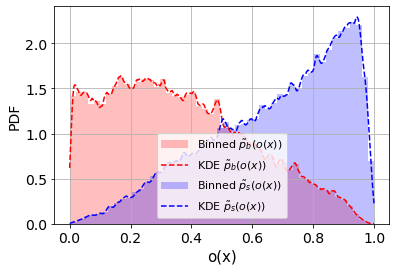

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



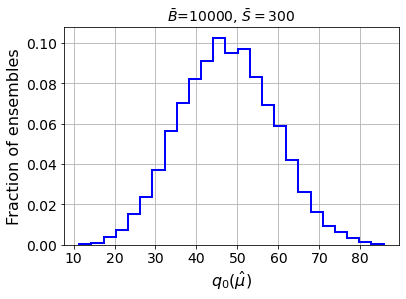

muhat mean:  0.0403858120721842
median q_muhat_KDE:  47.37819696195152
Z_KDE:  6.8831821828244175
Z_KDE mu=0:  6.884913995025623

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.104347108433655
Z_XG 25 bins:  6.533631181093931
Z_XG 50 bins:  6.6475774291629515
Z_XG 100 bins:  6.722898543826794

 ----------------------------------------- 

muhat mean:  0.0403858120721842
median q_muhat_KDE:  47.37819696195152
Z_KDE:  6.8831821828244175
Z_KDE mu=0:  6.884913995025623
The analysis for 1 testset of 10000 observations took 6.784647 minutes...
Reading data from 26.0 ...
Classification score:


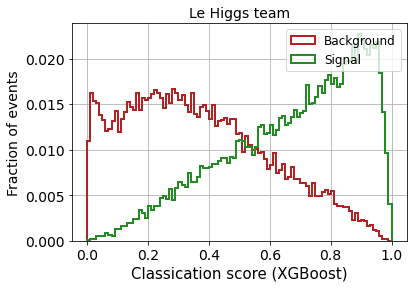

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  5.960691035250248

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.334243230302214

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.377578400148406

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.336266683946313

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   615.76661921   618.67130111   616.33952076   607.67814742
   588.73805734   554.41539862   499.86034483   415.6494104
   269.80179561   -27.30061258  -684.04853994 -1970.31047977]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   967.77836489   970.56202965   970.98290653   967.82500169
   956.69625533   925.44709157   860.40976284   733.2221759
   500.60243438    96.57449293  -619.3471284  -1945.11422794]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


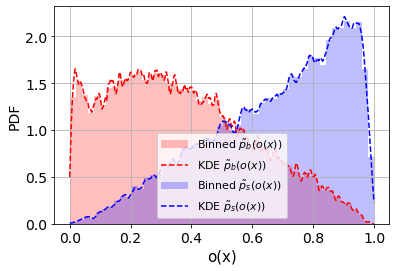

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



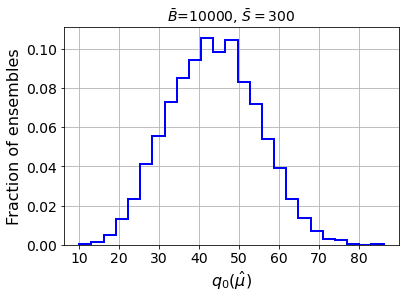

muhat mean:  0.04336237295166978
median q_muhat_KDE:  43.61602895954235
Z_KDE:  6.604243254116428
Z_KDE mu=0:  6.6043537205856815

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  5.960691035250248
Z_XG 25 bins:  6.334243230302214
Z_XG 50 bins:  6.377578400148406
Z_XG 100 bins:  6.336266683946313

 ----------------------------------------- 

muhat mean:  0.04336237295166978
median q_muhat_KDE:  43.61602895954235
Z_KDE:  6.604243254116428
Z_KDE mu=0:  6.6043537205856815
The analysis for 1 testset of 10000 observations took 6.855941 minutes...
Reading data from 27.0 ...
Classification score:


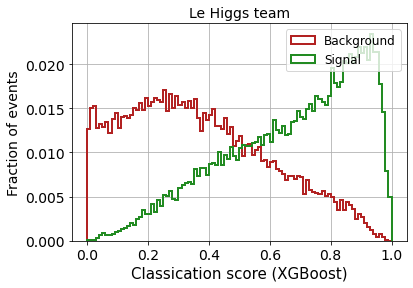

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.06411783388741

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.355135244586864

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.551199903301375

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.519591653242984

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf   597.34104973
   606.49602571   610.65533119   607.84062258   597.19820824
   577.31894961   544.02425789   491.33634551   406.0071442
   257.42242329   -44.8616024   -698.14195514 -1974.87921295]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   954.56931237   954.83492019   952.73090531
   943.29475593   914.07225005   849.0857467    721.16414712
   486.77911389    86.33677847  -622.6018182  -1946.18932213]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


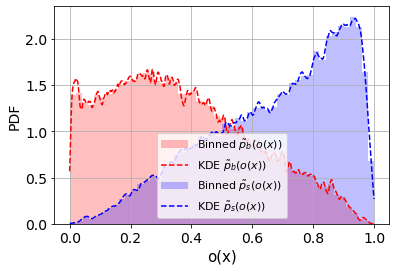

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



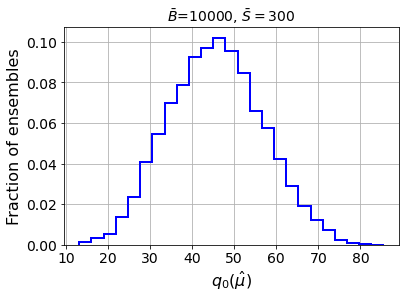

muhat mean:  0.04158888197469405
median q_muhat_KDE:  45.522272557303836
Z_KDE:  6.747019531415619
Z_KDE mu=0:  6.7478440849003

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.06411783388741
Z_XG 25 bins:  6.355135244586864
Z_XG 50 bins:  6.551199903301375
Z_XG 100 bins:  6.519591653242984

 ----------------------------------------- 

muhat mean:  0.04158888197469405
median q_muhat_KDE:  45.522272557303836
Z_KDE:  6.747019531415619
Z_KDE mu=0:  6.7478440849003
The analysis for 1 testset of 10000 observations took 6.869697 minutes...
Reading data from 28.0 ...
Classification score:


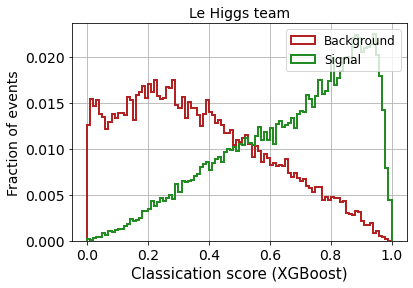

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  5.952509599651894

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.184534775378971

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.2862288189191045

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.224900651835149

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   590.65728784   595.26022491   594.12308437   584.45561018
   566.85391112   534.34279873   480.55344623   395.80873876
   246.24006714   -62.18317461  -711.1100228  -1979.39707925]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   952.40270998   955.8728789    956.99096085   954.91319364
   945.27713589   916.54115404   852.97997184   727.47097792
   496.20902624    93.83250744  -619.63040629 -1945.20740994]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


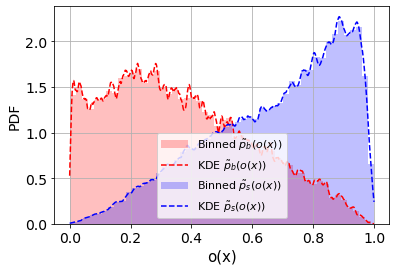

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



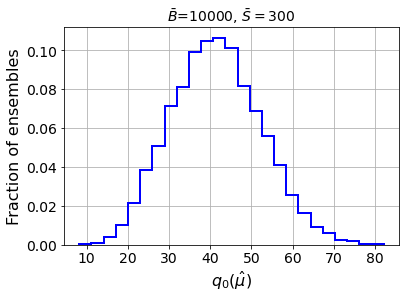

muhat mean:  0.0507778469197262
median q_muhat_KDE:  41.1907975142953
Z_KDE:  6.418005727194024
Z_KDE mu=0:  6.418336799113147

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  5.952509599651894
Z_XG 25 bins:  6.184534775378971
Z_XG 50 bins:  6.2862288189191045
Z_XG 100 bins:  6.224900651835149

 ----------------------------------------- 

muhat mean:  0.0507778469197262
median q_muhat_KDE:  41.1907975142953
Z_KDE:  6.418005727194024
Z_KDE mu=0:  6.418336799113147
The analysis for 1 testset of 10000 observations took 6.929495 minutes...
Reading data from 29.0 ...
Classification score:


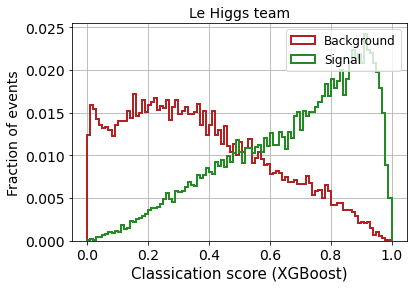

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  5.9976635287004685

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.3078417612211695

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.459762840419281

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.501289481895

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf   588.36251767
   597.4347759    600.28730363   596.19026318   586.85742306
   566.6366333    533.33210067   478.74081297   393.68601848
   242.03112123   -66.42616512  -715.26912702 -1980.63036725]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   959.55322798   965.26279298   967.19199191   964.96105805
   954.56077492   926.0147899    862.64859826   734.49548173
   497.73597652    87.50371212  -625.21185537 -1947.02211298]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


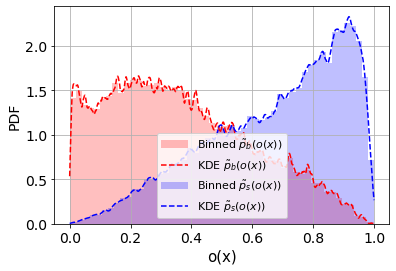

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



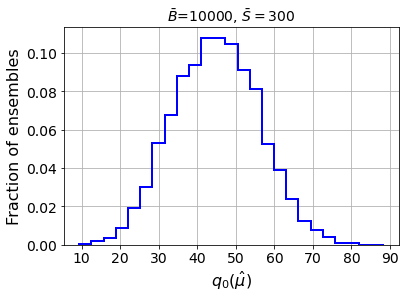

muhat mean:  0.03457788840489525
median q_muhat_KDE:  44.87630001919172
Z_KDE:  6.698977535355057
Z_KDE mu=0:  6.698977535355057

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  5.9976635287004685
Z_XG 25 bins:  6.3078417612211695
Z_XG 50 bins:  6.459762840419281
Z_XG 100 bins:  6.501289481895

 ----------------------------------------- 

muhat mean:  0.03457788840489525
median q_muhat_KDE:  44.87630001919172
Z_KDE:  6.698977535355057
Z_KDE mu=0:  6.698977535355057
The analysis for 1 testset of 10000 observations took 6.890488 minutes...
Reading data from 30.0 ...
Classification score:


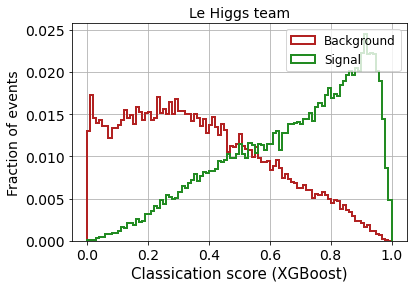

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.127893718343198

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.403025360932714

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.575182691263241

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.572861499716596

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf   600.40207863   590.2900782
   570.09849631   536.03141745   481.03806164   394.1691801
   239.98092476   -59.70201923  -705.46400813 -1977.51181209]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   972.76620823   974.19670656   973.15583433
   962.58771486   933.25630541   865.57181683   733.93579951
   501.75392135   102.80773825  -611.37713307 -1942.53712749]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


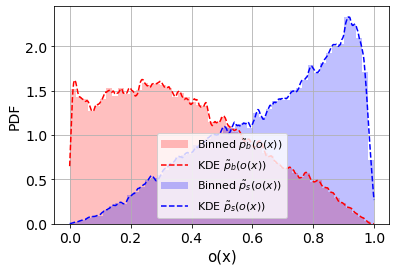

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



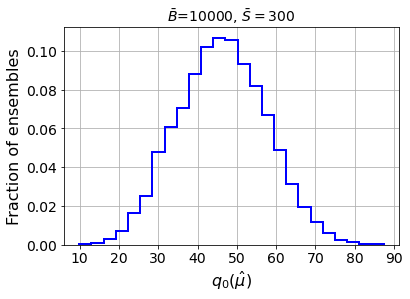

muhat mean:  0.034484546774528106
median q_muhat_KDE:  46.23688874928234
Z_KDE:  6.799771227716588
Z_KDE mu=0:  6.799892813168719

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.127893718343198
Z_XG 25 bins:  6.403025360932714
Z_XG 50 bins:  6.575182691263241
Z_XG 100 bins:  6.572861499716596

 ----------------------------------------- 

muhat mean:  0.034484546774528106
median q_muhat_KDE:  46.23688874928234
Z_KDE:  6.799771227716588
Z_KDE mu=0:  6.799892813168719
The analysis for 1 testset of 10000 observations took 7.142456 minutes...
Reading data from 31.0 ...
Classification score:


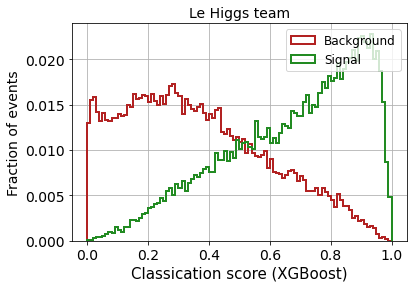

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.070750293331658

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.4452120300812235

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.479210456099423

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.43833525562553

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   611.57661823   610.29751202   602.34193435
   582.37132641   545.87145937   490.2126878    405.94534914
   253.95911071   -49.77445355  -702.77382587 -1976.51283831]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf   956.20741862   952.36528229
   941.64166051   912.9824284    848.16484299   721.56112983
   490.30928097    86.4358786   -623.9972295  -1946.59006806]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


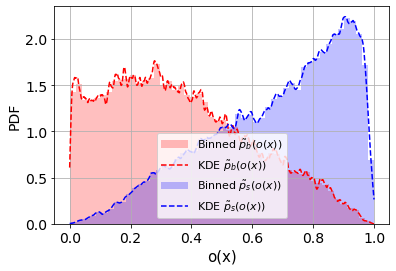

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



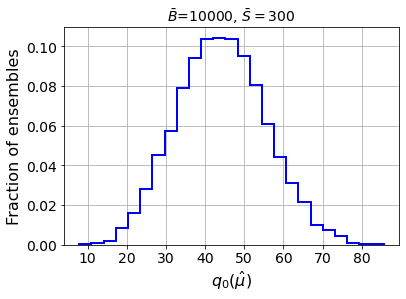

muhat mean:  0.05189794648413193
median q_muhat_KDE:  44.01486569141525
Z_KDE:  6.6343700297326835
Z_KDE mu=0:  6.634583389218066

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.070750293331658
Z_XG 25 bins:  6.4452120300812235
Z_XG 50 bins:  6.479210456099423
Z_XG 100 bins:  6.43833525562553

 ----------------------------------------- 

muhat mean:  0.05189794648413193
median q_muhat_KDE:  44.01486569141525
Z_KDE:  6.6343700297326835
Z_KDE mu=0:  6.634583389218066
The analysis for 1 testset of 10000 observations took 6.921061 minutes...
Reading data from 32.0 ...
Classification score:


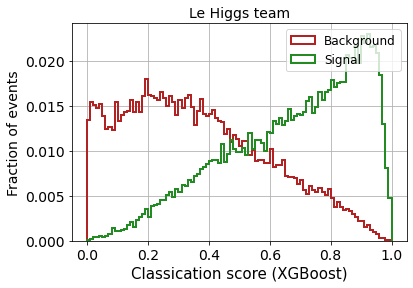

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.200819475343183

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.52317997668969

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.573273290482273

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.601086225454482

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   633.94302352   630.57140526   620.51551407
   602.50934762   569.38833936   513.94846952   428.33992018
   278.54895232   -28.00029822  -687.33055019 -1970.93771833]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf   950.26272236   948.91219929
   939.60920365   911.14395036   845.24821116   713.97107578
   486.65410214    94.48751261  -616.39124587 -1944.52770702]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


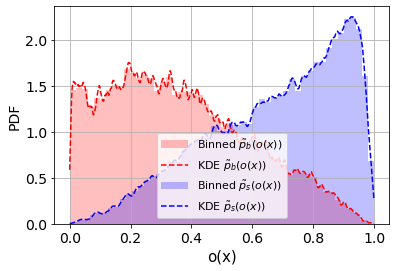

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



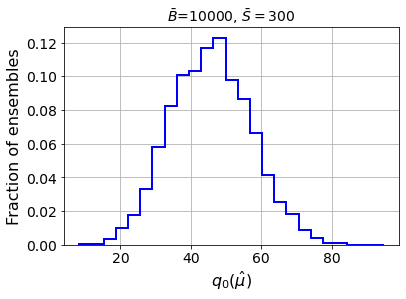

muhat mean:  0.04645301804604854
median q_muhat_KDE:  45.55922585198306
Z_KDE:  6.7497574661600295
Z_KDE mu=0:  6.751346753947871

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.200819475343183
Z_XG 25 bins:  6.52317997668969
Z_XG 50 bins:  6.573273290482273
Z_XG 100 bins:  6.601086225454482

 ----------------------------------------- 

muhat mean:  0.04645301804604854
median q_muhat_KDE:  45.55922585198306
Z_KDE:  6.7497574661600295
Z_KDE mu=0:  6.751346753947871
The analysis for 1 testset of 10000 observations took 6.892512 minutes...
Reading data from 33.0 ...
Classification score:


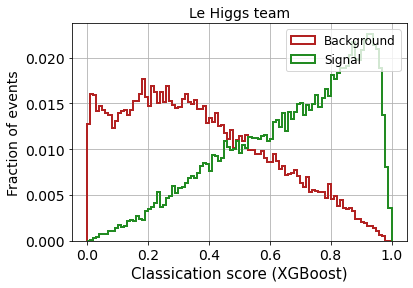

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  5.931935339861777

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.165802661850011

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  5.965410231884304

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  5.993419265614293

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf   583.39470973
   591.41065784   595.45341163   593.13012986   584.2853321
   564.92740076   531.77583461   475.08547901   386.87125107
   236.15493048   -69.45745703  -715.45308577 -1981.02793384]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf   909.33747437
   919.58922588   923.63426584   925.0391081    924.0619485
   913.39500829   883.70148307   817.55362821   689.86849401
   460.94556305    70.88792939  -633.61314042 -1950.52569846]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


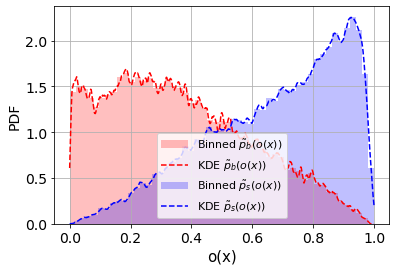

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



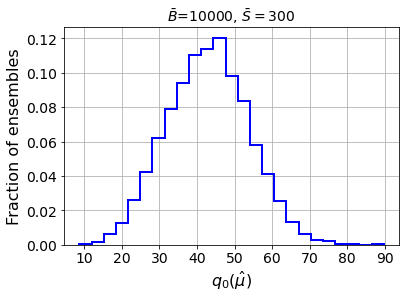

muhat mean:  0.03266438498236881
median q_muhat_KDE:  43.00302894153339
Z_KDE:  6.5576694748617355
Z_KDE mu=0:  6.5576694748617355

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  5.931935339861777
Z_XG 25 bins:  6.165802661850011
Z_XG 50 bins:  5.965410231884304
Z_XG 100 bins:  5.993419265614293

 ----------------------------------------- 

muhat mean:  0.03266438498236881
median q_muhat_KDE:  43.00302894153339
Z_KDE:  6.5576694748617355
Z_KDE mu=0:  6.5576694748617355
The analysis for 1 testset of 10000 observations took 6.880272 minutes...
Reading data from 34.0 ...
Classification score:


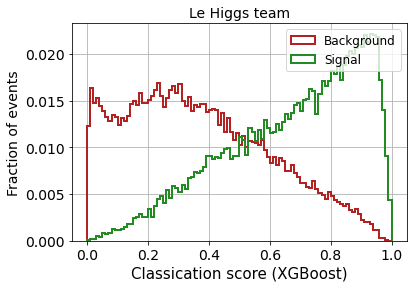

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  5.9115938437830895

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.353088489718418

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.489738583548989

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.427332000564837

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf   599.52902858   590.60667681
   571.69584766   538.14067323   480.57091781   390.8346863
   244.04885109   -53.68168639  -701.91956803 -1976.49512276]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   956.49128478   961.98230386   963.67469832   961.79783624
   951.1926502    921.64768613   854.24035897   726.24519057
   498.02198462   103.3060354   -611.2185411  -1942.65641663]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


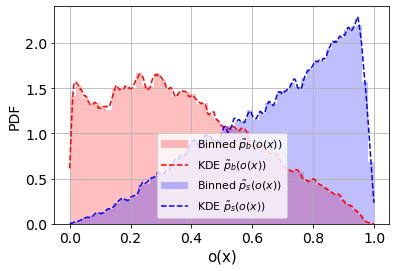

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



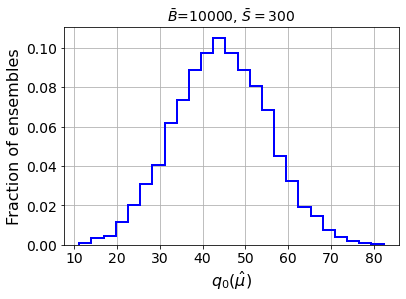

muhat mean:  0.035122381248703594
median q_muhat_KDE:  44.19681778364014
Z_KDE:  6.648068725851151
Z_KDE mu=0:  6.648245566368606

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  5.9115938437830895
Z_XG 25 bins:  6.353088489718418
Z_XG 50 bins:  6.489738583548989
Z_XG 100 bins:  6.427332000564837

 ----------------------------------------- 

muhat mean:  0.035122381248703594
median q_muhat_KDE:  44.19681778364014
Z_KDE:  6.648068725851151
Z_KDE mu=0:  6.648245566368606
The analysis for 1 testset of 10000 observations took 6.890445 minutes...
Reading data from 35.0 ...
Classification score:


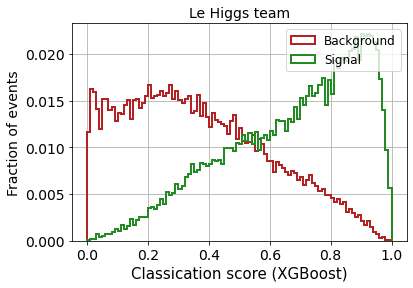

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.071408173569814

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.386351446428765

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.476178254387207

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.544232713223736

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf   607.72887518   597.19277018
   576.22947204   542.78777647   489.27368526   397.64061119
   243.78728079   -59.88224273  -707.11198126 -1977.95708988]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf   949.099854     946.65085414
   936.86116655   909.54164322   845.74371376   719.1942776
   491.32973058    90.8537068   -618.67364018 -1945.19038726]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


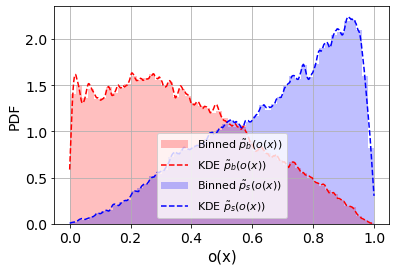

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



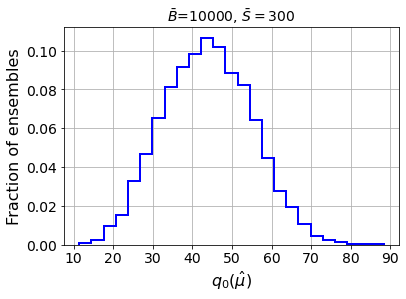

muhat mean:  0.05080896079651524
median q_muhat_KDE:  43.80512423210632
Z_KDE:  6.618543966168565
Z_KDE mu=0:  6.618656793313189

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.071408173569814
Z_XG 25 bins:  6.386351446428765
Z_XG 50 bins:  6.476178254387207
Z_XG 100 bins:  6.544232713223736

 ----------------------------------------- 

muhat mean:  0.05080896079651524
median q_muhat_KDE:  43.80512423210632
Z_KDE:  6.618543966168565
Z_KDE mu=0:  6.618656793313189
The analysis for 1 testset of 10000 observations took 6.872175 minutes...
Reading data from 36.0 ...
Classification score:


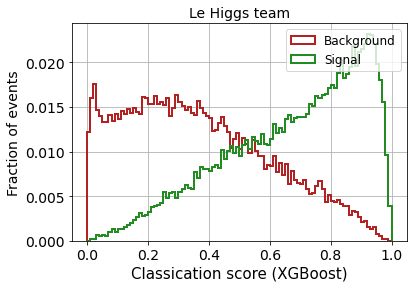

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.030783315284181

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.370072084428062

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.408168843695622

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.384153461620723

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   590.40718578   591.31755383   589.041637     580.62721974
   560.63501978   523.32174465   466.27798908   375.59019416
   220.5957967    -81.80253231  -723.07072657 -1983.67166275]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   952.82535457   954.52042899   952.19056426
   940.2687572    909.93748179   842.51993268   712.31191832
   480.6021628     84.80951021  -625.52263924 -1947.38211653]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


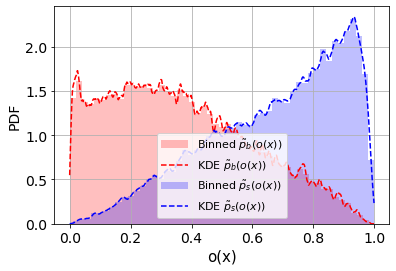

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



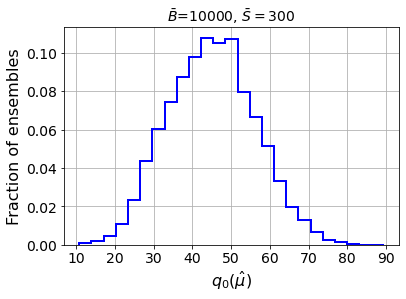

muhat mean:  0.03802115743621656
median q_muhat_KDE:  45.01351332244349
Z_KDE:  6.709211080480587
Z_KDE mu=0:  6.709331241169895

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.030783315284181
Z_XG 25 bins:  6.370072084428062
Z_XG 50 bins:  6.408168843695622
Z_XG 100 bins:  6.384153461620723

 ----------------------------------------- 

muhat mean:  0.03802115743621656
median q_muhat_KDE:  45.01351332244349
Z_KDE:  6.709211080480587
Z_KDE mu=0:  6.709331241169895
The analysis for 1 testset of 10000 observations took 6.827662 minutes...
Reading data from 37.0 ...
Classification score:


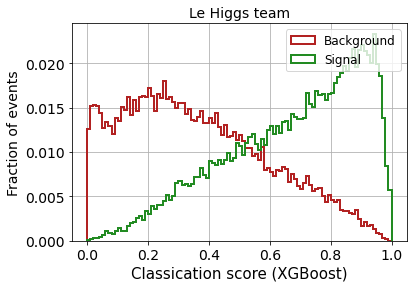

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  5.962082341898662

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.162380782314419

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.261784788651323

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.19195823280626

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf   602.88362382
   612.20976554   618.12893869   617.81451999   609.48804314
   590.65494654   555.46470266   498.77834146   413.30515221
   261.48383149   -49.39612752  -704.21567057 -1976.98239402]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   961.78731216   964.49020338   961.58643673
   952.23298797   925.30451178   861.56362196   735.8758323
   509.34653881   113.56445701  -607.31933151 -1941.11053951]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


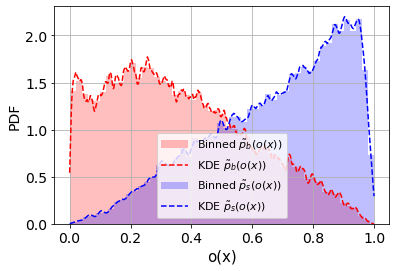

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



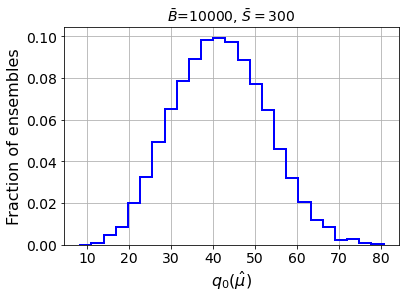

muhat mean:  0.04668118647583489
median q_muhat_KDE:  41.570946029114054
Z_KDE:  6.447553491760581
Z_KDE mu=0:  6.447553491760581

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  5.962082341898662
Z_XG 25 bins:  6.162380782314419
Z_XG 50 bins:  6.261784788651323
Z_XG 100 bins:  6.19195823280626

 ----------------------------------------- 

muhat mean:  0.04668118647583489
median q_muhat_KDE:  41.570946029114054
Z_KDE:  6.447553491760581
Z_KDE mu=0:  6.447553491760581
The analysis for 1 testset of 10000 observations took 7.023913 minutes...
Reading data from 38.0 ...
Classification score:


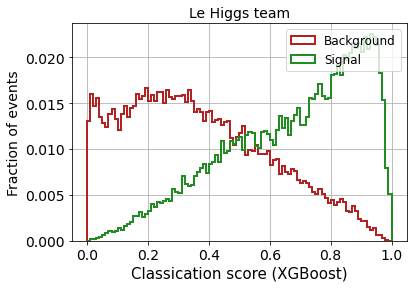

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.081261955165143

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.414614647321589

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.501441984473893

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.485181018198298

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   608.05837774   609.40683708   606.01773251   595.82093413
   576.67261934   542.40268769   487.96701801   400.96486261
   250.47890223   -52.93265344  -703.07531003 -1976.62450898]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   946.27824707   950.48826312   951.46534673   948.46604687
   937.3907       906.67788841   840.20954736   712.82654032
   478.57429958    80.72378229  -623.42755843 -1946.81375347]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


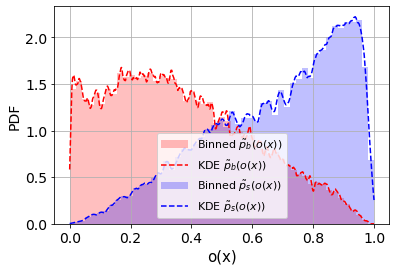

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



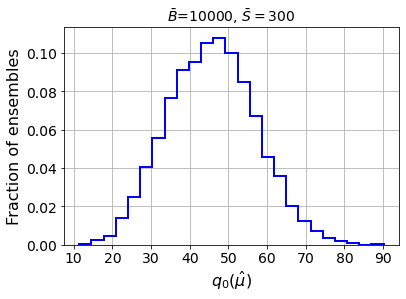

muhat mean:  0.034598630989421286
median q_muhat_KDE:  45.773114117231785
Z_KDE:  6.765583058187357
Z_KDE mu=0:  6.765583058187357

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.081261955165143
Z_XG 25 bins:  6.414614647321589
Z_XG 50 bins:  6.501441984473893
Z_XG 100 bins:  6.485181018198298

 ----------------------------------------- 

muhat mean:  0.034598630989421286
median q_muhat_KDE:  45.773114117231785
Z_KDE:  6.765583058187357
Z_KDE mu=0:  6.765583058187357
The analysis for 1 testset of 10000 observations took 7.081404 minutes...
Reading data from 39.0 ...
Classification score:


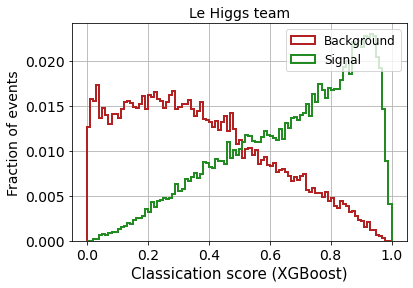

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.153404992906332

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.470252772170721

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.27111059306149

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.3521191533408645

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf   617.34274101
   625.13603643   626.13064529   622.64578123   612.88203849
   593.88487894   557.52680495   498.54634922   409.63692866
   254.54666524   -52.30785023  -703.71104874 -1976.79166833]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf   938.00399868
   948.69666028   955.75748412   957.73222212   955.43927531
   944.77260683   914.86701806   847.73218933   712.93141851
   476.28704568    72.79573871  -632.48761286 -1949.49541781]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


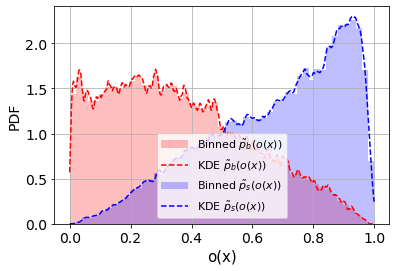

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



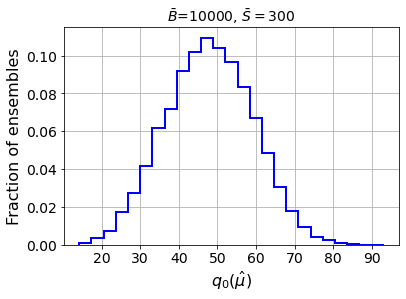

muhat mean:  0.025300767475627466
median q_muhat_KDE:  47.87983083147566
Z_KDE:  6.919525332815515
Z_KDE mu=0:  6.919525332815515

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.153404992906332
Z_XG 25 bins:  6.470252772170721
Z_XG 50 bins:  6.27111059306149
Z_XG 100 bins:  6.3521191533408645

 ----------------------------------------- 

muhat mean:  0.025300767475627466
median q_muhat_KDE:  47.87983083147566
Z_KDE:  6.919525332815515
Z_KDE mu=0:  6.919525332815515
The analysis for 1 testset of 10000 observations took 7.057496 minutes...
Reading data from 40.0 ...
Classification score:


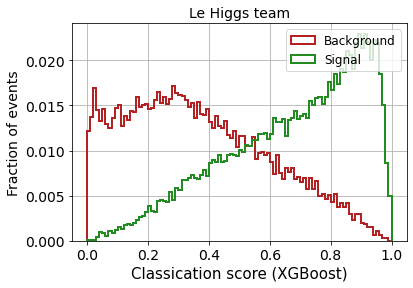

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.115408805555808

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.329713607711082

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.4150779836096685

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.384095153573594

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   604.01572627   606.4988994    602.04235849   593.32481024
   575.49796228   541.9951217    489.15767933   401.34877815
   251.30453893   -48.31546225  -698.51879108 -1975.05125873]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf   956.04398746
   947.10642564   918.24369022   854.36512896   727.22949457
   494.24747195    97.63852201  -617.07006118 -1944.6115891 ]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


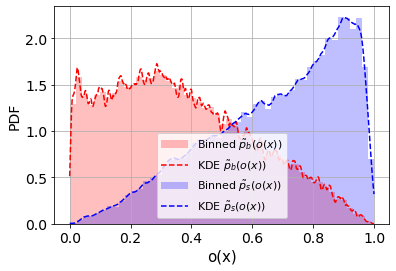

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



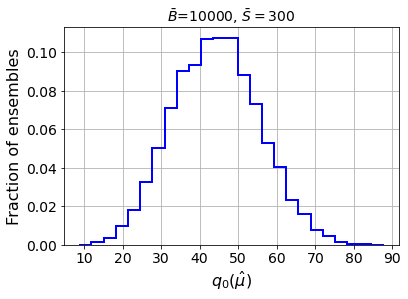

muhat mean:  0.04260526861646962
median q_muhat_KDE:  44.21033377109438
Z_KDE:  6.649085183022878
Z_KDE mu=0:  6.649172118334381

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.115408805555808
Z_XG 25 bins:  6.329713607711082
Z_XG 50 bins:  6.4150779836096685
Z_XG 100 bins:  6.384095153573594

 ----------------------------------------- 

muhat mean:  0.04260526861646962
median q_muhat_KDE:  44.21033377109438
Z_KDE:  6.649085183022878
Z_KDE mu=0:  6.649172118334381
The analysis for 1 testset of 10000 observations took 7.098014 minutes...
Reading data from 41.0 ...
Classification score:


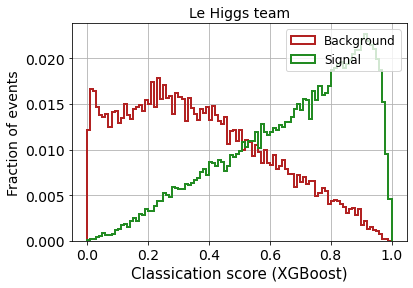

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.068692141331443

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.302215115583942

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.365583328169415

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.337239549816542

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   594.95061689   593.4498037    585.89839039
   566.69583156   531.65030254   474.60715879   384.40218175
   233.67395425   -68.20362689  -713.61288883 -1980.44032528]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf   939.3979848
   948.95754733   951.76628954   953.47043815   951.51842162
   940.05478406   909.50425054   844.15964653   721.61146462
   496.57295952    98.8096997   -620.07928425 -1945.21433457]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


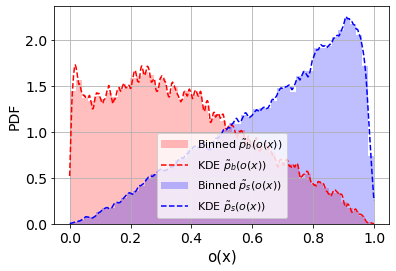

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



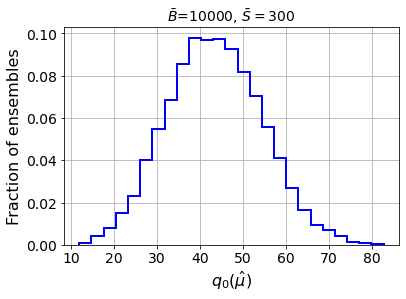

muhat mean:  0.04532254718937981
median q_muhat_KDE:  43.243749877569144
Z_KDE:  6.5759980138051395
Z_KDE mu=0:  6.576182850845449

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.068692141331443
Z_XG 25 bins:  6.302215115583942
Z_XG 50 bins:  6.365583328169415
Z_XG 100 bins:  6.337239549816542

 ----------------------------------------- 

muhat mean:  0.04532254718937981
median q_muhat_KDE:  43.243749877569144
Z_KDE:  6.5759980138051395
Z_KDE mu=0:  6.576182850845449
The analysis for 1 testset of 10000 observations took 6.882646 minutes...
Reading data from 42.0 ...
Classification score:


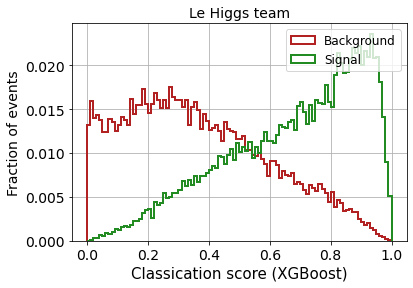

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  5.983678410040669

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.206157376213362

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.276982621283663

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.337253857388813

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   594.72702756   591.49144935   581.33788254
   560.5210096    528.21703044   474.64567557   389.90712304
   241.12072753   -63.04104779  -711.55993333 -1979.69330818]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   941.82526494   945.85379009   945.91867535   943.17365094
   931.81329042   902.77801307   837.65226196   713.57467074
   483.08421065    81.85965697  -629.64050232 -1948.65169239]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


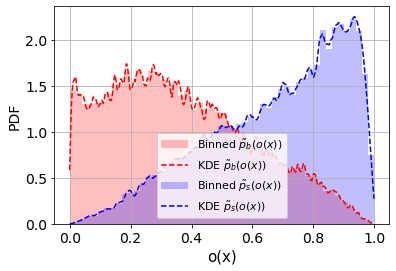

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



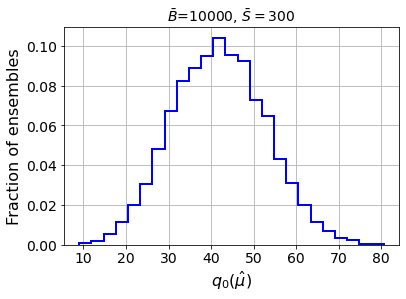

muhat mean:  0.05238021157436217
median q_muhat_KDE:  41.90150025692725
Z_KDE:  6.4731368174114206
Z_KDE mu=0:  6.473996286773102

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  5.983678410040669
Z_XG 25 bins:  6.206157376213362
Z_XG 50 bins:  6.276982621283663
Z_XG 100 bins:  6.337253857388813

 ----------------------------------------- 

muhat mean:  0.05238021157436217
median q_muhat_KDE:  41.90150025692725
Z_KDE:  6.4731368174114206
Z_KDE mu=0:  6.473996286773102
The analysis for 1 testset of 10000 observations took 6.885887 minutes...
Reading data from 43.0 ...
Classification score:


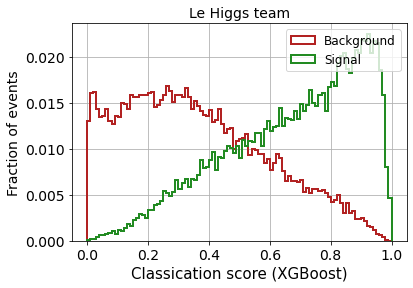

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  5.977531146184851

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.2636200947734055

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.350676315054327

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.292597690004712

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf   619.05391982
   622.57991908   622.85450597   619.89344428   609.95744602
   589.51647541   555.31900794   500.01470303   414.56051102
   261.02948079   -43.71627208  -699.5056418  -1975.55017798]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   952.89198327   954.55064226   952.2910599
   941.23203269   909.57233408   842.15982299   714.13894648
   482.75478928    92.30434765  -618.02618055 -1944.87071731]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


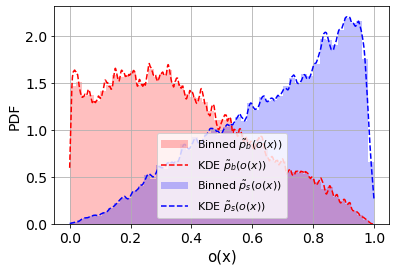

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



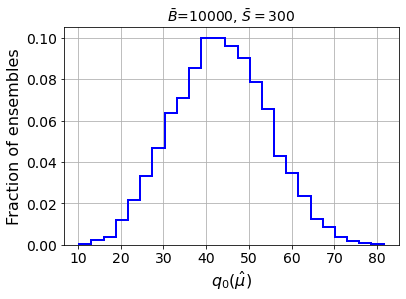

muhat mean:  0.03937461107654014
median q_muhat_KDE:  43.29331345914841
Z_KDE:  6.579765456241462
Z_KDE mu=0:  6.579765456241462

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  5.977531146184851
Z_XG 25 bins:  6.2636200947734055
Z_XG 50 bins:  6.350676315054327
Z_XG 100 bins:  6.292597690004712

 ----------------------------------------- 

muhat mean:  0.03937461107654014
median q_muhat_KDE:  43.29331345914841
Z_KDE:  6.579765456241462
Z_KDE mu=0:  6.579765456241462
The analysis for 1 testset of 10000 observations took 6.916242 minutes...
Reading data from 44.0 ...
Classification score:


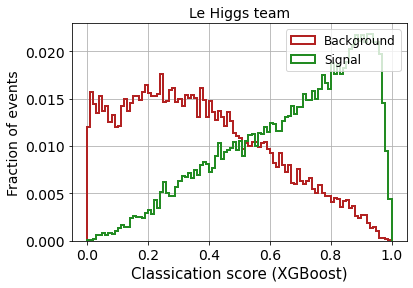

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  5.829977878448105

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.310702691288343

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.327130610331032

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.362522733701987

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   579.57202473   578.60279999   569.04966648
   550.23711693   519.38706679   463.61769633   374.98784193
   227.07944314   -69.71748737  -712.75051135 -1980.50108069]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   955.46662266   957.62641767   957.31369704
   945.82888519   914.79959367   848.70779463   720.60682487
   488.86699611    87.30498024  -625.47965424 -1947.26933259]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


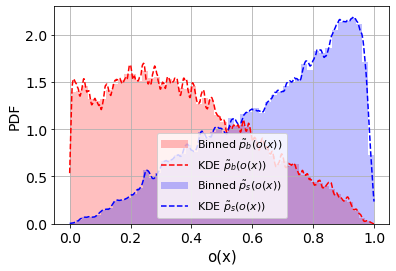

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



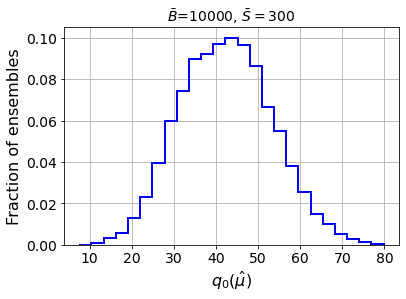

muhat mean:  0.045633685957270284
median q_muhat_KDE:  42.3096041872227
Z_KDE:  6.504583321568162
Z_KDE mu=0:  6.504780987268913

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  5.829977878448105
Z_XG 25 bins:  6.310702691288343
Z_XG 50 bins:  6.327130610331032
Z_XG 100 bins:  6.362522733701987

 ----------------------------------------- 

muhat mean:  0.045633685957270284
median q_muhat_KDE:  42.3096041872227
Z_KDE:  6.504583321568162
Z_KDE mu=0:  6.504780987268913
The analysis for 1 testset of 10000 observations took 6.852019 minutes...
Reading data from 45.0 ...
Classification score:


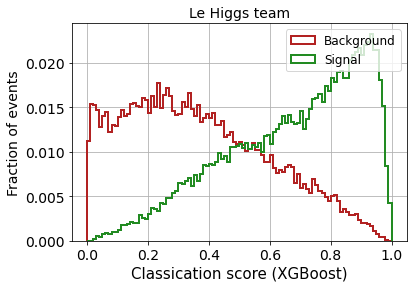

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.040179479089767

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.335710679810737

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.424171366401097

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.360145305147968

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   602.5662971    602.64748936   594.47438286
   575.62847279   542.51537409   487.34707881   403.64598416
   253.79358936   -51.18168899  -701.41696494 -1975.98461142]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   963.76421409   969.16905086   970.50718729   968.66735217
   959.19927027   929.71663408   862.97022991   733.59047418
   502.7539752    104.24076114  -609.25542792 -1942.02936527]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


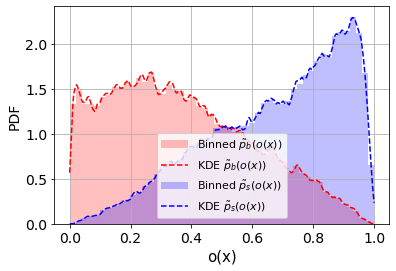

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



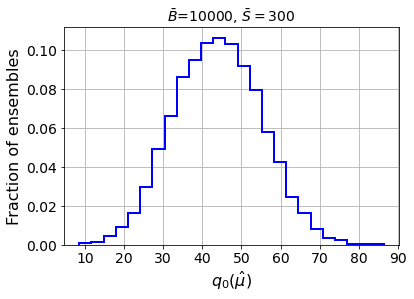

muhat mean:  0.04424911844015765
median q_muhat_KDE:  43.83799511954305
Z_KDE:  6.621026742095447
Z_KDE mu=0:  6.621156567181957

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.040179479089767
Z_XG 25 bins:  6.335710679810737
Z_XG 50 bins:  6.424171366401097
Z_XG 100 bins:  6.360145305147968

 ----------------------------------------- 

muhat mean:  0.04424911844015765
median q_muhat_KDE:  43.83799511954305
Z_KDE:  6.621026742095447
Z_KDE mu=0:  6.621156567181957
The analysis for 1 testset of 10000 observations took 6.890736 minutes...
Reading data from 46.0 ...
Classification score:


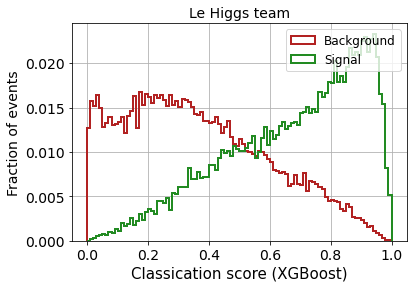

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.042059465269665

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.302538721837317

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.378118064242708

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.413856247009482

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf   600.53250257   591.916291
   573.81076214   539.18369684   480.64418265   391.64784148
   243.46648949   -61.04526872  -709.86617099 -1978.98617072]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   973.0539895    978.05643525   979.42848025   976.00561082
   966.92888403   939.44668973   874.01574338   744.91220679
   509.33795205   103.71391094  -612.22529026 -1942.88177308]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


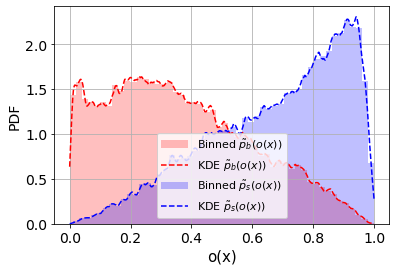

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



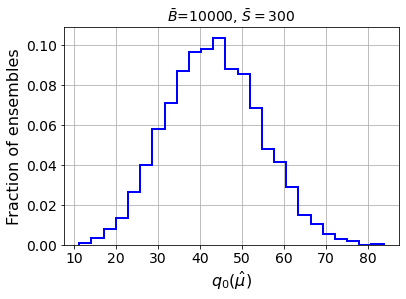

muhat mean:  0.04948662103298071
median q_muhat_KDE:  43.07422404099748
Z_KDE:  6.563095614189807
Z_KDE mu=0:  6.563758675047379

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.042059465269665
Z_XG 25 bins:  6.302538721837317
Z_XG 50 bins:  6.378118064242708
Z_XG 100 bins:  6.413856247009482

 ----------------------------------------- 

muhat mean:  0.04948662103298071
median q_muhat_KDE:  43.07422404099748
Z_KDE:  6.563095614189807
Z_KDE mu=0:  6.563758675047379
The analysis for 1 testset of 10000 observations took 6.935521 minutes...
Reading data from 47.0 ...
Classification score:


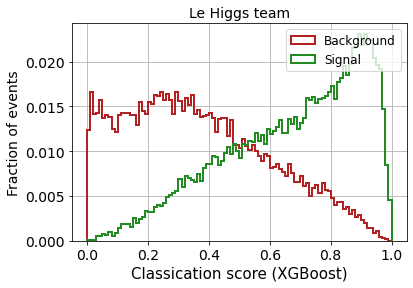

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.048362398061809

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.398181219468693

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.427564093841156

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.359857250858435

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   598.53784076   597.38639422   588.21783277
   570.01297399   536.81546796   479.66260023   390.72813407
   239.75769243   -58.69839791  -705.76483474 -1977.69629263]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf   954.46873764   952.95079132
   941.43911309   911.69509209   846.96391137   715.74010269
   482.26597609    87.08122443  -621.14913925 -1945.93423694]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


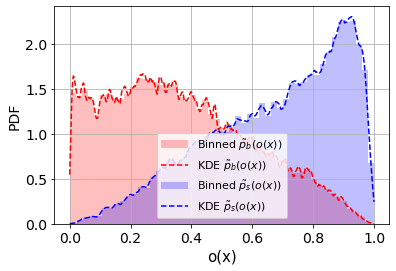

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



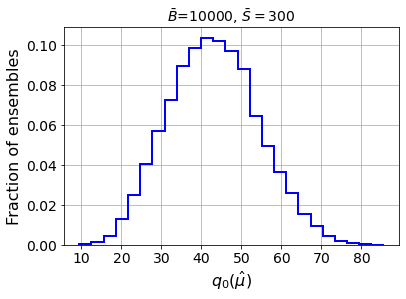

muhat mean:  0.05089193113461938
median q_muhat_KDE:  42.767811807695466
Z_KDE:  6.539710376438353
Z_KDE mu=0:  6.540383109831818

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.048362398061809
Z_XG 25 bins:  6.398181219468693
Z_XG 50 bins:  6.427564093841156
Z_XG 100 bins:  6.359857250858435

 ----------------------------------------- 

muhat mean:  0.05089193113461938
median q_muhat_KDE:  42.767811807695466
Z_KDE:  6.539710376438353
Z_KDE mu=0:  6.540383109831818
The analysis for 1 testset of 10000 observations took 6.983523 minutes...
Reading data from 48.0 ...
Classification score:


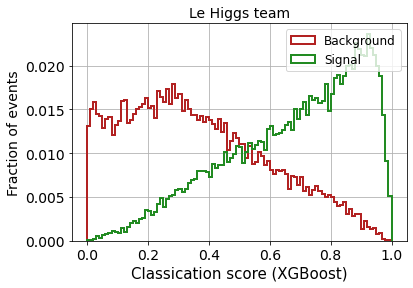

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.074623847478713

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.268462183014525

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.343490187704176

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.440941693368759

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   610.51932308   614.75202901   611.71092224   602.56515755
   583.9069695    550.29379886   496.09076261   408.07240179
   254.44029353   -52.19211136  -706.1062257  -1977.61981411]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
   971.26649097   944.11267389   879.79254925   750.81721003
   521.04801494   120.77107592  -602.20153414 -1939.33103865]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.03613222756796251, kernel='epanechnikov')


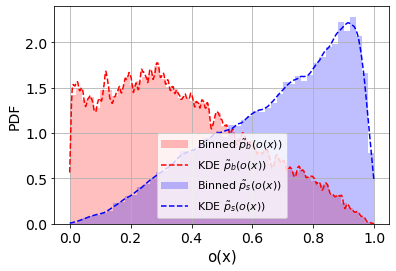

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



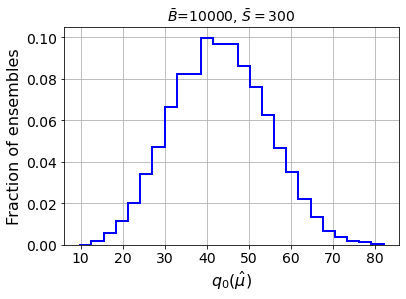

muhat mean:  0.04407799211781788
median q_muhat_KDE:  42.90454780023532
Z_KDE:  6.5501563187633405
Z_KDE mu=0:  6.550785796522191

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.074623847478713
Z_XG 25 bins:  6.268462183014525
Z_XG 50 bins:  6.343490187704176
Z_XG 100 bins:  6.440941693368759

 ----------------------------------------- 

muhat mean:  0.04407799211781788
median q_muhat_KDE:  42.90454780023532
Z_KDE:  6.5501563187633405
Z_KDE mu=0:  6.550785796522191
The analysis for 1 testset of 10000 observations took 7.014982 minutes...
Reading data from 49.0 ...
Classification score:


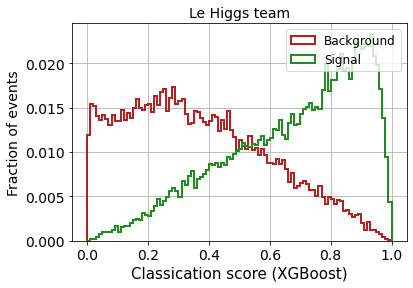

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 10 bins:  6.025653735491816

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 25 bins:  6.136506491653726

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 50 bins:  6.231656304293683

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
Z_XG 100 bins:  6.284131792908024

 ----------------------------------------- 

 MLL + KDE 


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf   593.53411544
   602.75134348   604.14123589   600.19103798   590.77304916
   571.57680713   539.65056574   486.78711857   401.11542227
   251.40013829   -51.42682963  -700.65483542 -1976.0161479 ]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf   917.06307963
   924.59915595   930.70835092   931.97079013   928.95974443
   918.49225006   890.62865492   828.92833241   705.50253328
   477.80155691    78.30378894  -631.44393411 -1949.61083257]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


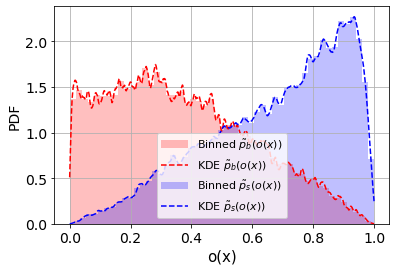

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0
n_ensembles (initial):  10000

 If  2060  =  523    then the proposed range has to be extended
n_ensembles (actual):  9642

 This may take long... 



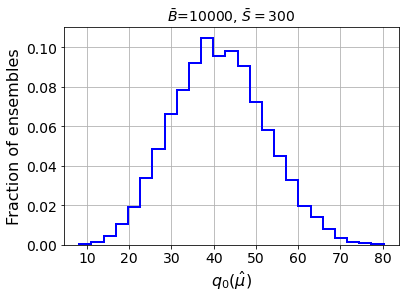

muhat mean:  0.05216760008297034
median q_muhat_KDE:  41.148932676104835
Z_KDE:  6.4147433834959315
Z_KDE mu=0:  6.416383421951188

 -------------------------------- 

RESULTS FOR:
B_expected:  10000
S_expected:  300
S/$\sqrt{B}$:  3.0

 ----------------------------------------- 

Z_XG 10 bins:  6.025653735491816
Z_XG 25 bins:  6.136506491653726
Z_XG 50 bins:  6.231656304293683
Z_XG 100 bins:  6.284131792908024

 ----------------------------------------- 

muhat mean:  0.05216760008297034
median q_muhat_KDE:  41.148932676104835
Z_KDE:  6.4147433834959315
Z_KDE mu=0:  6.416383421951188
The analysis for 1 testset of 10000 observations took 8.528851 minutes...


In [421]:
##############
# PARAMETERS #
##############

# SOME USEFUL DERIVATED PARAMETERS (maybe not used?):
# ratio S_expected/B_expected (signal ratio)
SB_ratio = 0.1
# S/\sqrt{B}
SsqrtB = S_expected / (B_expected)**0.5
# CHECKEAR QUE TENGAS #

X_gauss_train = trainset[:,1:]
Y_gauss_train = trainset[:,0]

X_gauss_val = valset[:,1:]
Y_gauss_val = valset[:,0]
    
nobs = 50_000 # Observations per testset

# requested number of ensembles
n_ensembles = 10000

# number of expected background events per ensemble
B_expected = 10000
S_expected = 300

store_Z_bins_XG_10bins  = []
store_Z_bins_XG_25bins  = []
store_Z_bins_XG_50bins  = []
store_Z_bins_XG_100bins = []
store_Z_MLL_KDE         = []
store_Z_MLL_KDE_mu0     = []
store_Z_WP              = []
store_WP                = []
store_muhat_mean_MLL_KDE = []

q_muhat_dist_lista  = []
muhat_dist_lista    = []
q_muhat0_dist_lista = []

for i in range(50):
    start = time.time()

    i_ini = 1_000_000 + i * nobs
    testset = read_data(i_ini, nobs)
    X_gauss_test = testset[:,1:]
    Y_gauss_test = testset[:,0]

    y_pred_xg = classifier.predict_proba(testset[:,1:]).T[1]

    ########################
    # CLASSIFICATION SCORE #
    ########################

    # Outputs for validation data set

    pred_XG_SM = []
    pred_XG_NP = []

    for i in range(len(Y_gauss_test)):
        if Y_gauss_test[i] == 0:
            pred_XG_SM.append(y_pred_xg[i])
        else:
            pred_XG_NP.append(y_pred_xg[i])


    print('Classification score:')

    weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
    nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

    weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
    nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Classication score (XGBoost)",fontsize=15)
    plt.ylabel("Fraction of events",fontsize=14)
    plt.grid()
    plt.legend(fontsize=12)
    plt.title('Le Higgs team', fontsize=14)
    plt.show()

    ##################################################
    # CLASSIFIER OUTPUT BINNED POISON LOG-LIKELIHOOD #
    ##################################################

    # 10 BINS

    print('BINNED CLASSIFIER OUTPUT')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)

    # Les't find the number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_ensembles_sig  = len(pred_XG_NP) / S_expected

    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(10), range = [[0,1]])

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0
    hist_back[np.where(hist_back == 0)[0]] = hist_back[np.argsort(hist_back)[1]]

    # now divide by the number of possible ensembles
    back_prom = hist_back/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(10), range = [[0,1]])
    sig_prom = hist_sig/N_ensembles_sig

    # then the signif Z^binned-Asimov:
    Z_bins_XG_10bins = np.sqrt( 2* np.sum( (back_prom * np.log(back_prom / (sig_prom+back_prom))) + sig_prom ) )

    store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)

    print('Z_XG 10 bins: ', Z_bins_XG_10bins)
    print('\n ----------------------------------------- \n')

    ##############################

    # 25 BINS

    print('BINNED CLASSIFIER OUTPUT')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)


    # Les't find the number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_ensembles_sig = len(pred_XG_NP) / S_expected

    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(25), range = [[0,1]])

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    hist_back_noceros = []
    for i in range(len(hist_back)):
        if hist_back[i]!=0:
            hist_back_noceros.append(hist_back[i])

    min_back = min(hist_back_noceros)

    # replace the zeros
    for i in range(len(hist_back)):
        if hist_back[i]==0:
            hist_back[i] = min_back

    # now divide by the number of possible ensembles
    back_prom = hist_back/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(25), range = [[0,1]])
    sig_prom = hist_sig/N_ensembles_sig

    # then the signif Z^binned-Asimov:
    Z_bins_XG_25bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)

    print('Z_XG 25 bins: ', Z_bins_XG_25bins)
    print('\n ----------------------------------------- \n')

    #############################

    # 50 BINS

    print('BINNED CLASSIFIER OUTPUT')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)


    # Les't find the number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_ensembles_sig = len(pred_XG_NP) / S_expected

    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(50), range = [[0,1]])

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    hist_back_noceros = []
    for i in range(len(hist_back)):
        if hist_back[i]!=0:
            hist_back_noceros.append(hist_back[i])

    min_back = min(hist_back_noceros)

    # replace the zeros
    for i in range(len(hist_back)):
        if hist_back[i]==0:
            hist_back[i] = min_back

    # now divide by the number of possible ensembles
    back_prom = hist_back/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(50), range = [[0,1]])
    sig_prom = hist_sig/N_ensembles_sig

    # then the signif Z^binned-Asimov:
    Z_bins_XG_50bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)

    print('Z_XG 50 bins: ', Z_bins_XG_50bins)
    print('\n ----------------------------------------- \n')

    ##############################

    # 100 BINS

    print('BINNED CLASSIFIER OUTPUT')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)


    # Les't find the number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_ensembles_sig = len(pred_XG_NP) / S_expected

    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(100), range = [[0,1]])

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    hist_back_noceros = []
    for i in range(len(hist_back)):
        if hist_back[i]!=0:
            hist_back_noceros.append(hist_back[i])

    min_back = min(hist_back_noceros)

    # replace the zeros
    for i in range(len(hist_back)):
        if hist_back[i]==0:
            hist_back[i] = min_back

    # now divide by the number of possible ensembles
    back_prom = hist_back/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(100), range = [[0,1]])
    sig_prom = hist_sig/N_ensembles_sig

    # then the signif Z^binned-Asimov:
    Z_bins_XG_100bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)

    print('Z_XG 100 bins: ', Z_bins_XG_100bins)
    print('\n ----------------------------------------- \n')

    #########
    #  KDE  #
    #########  

    print(' MLL + KDE ')

    # FIND THE BANDWIDTH

    bandwidth = np.logspace(-4.0, 0.05, 20)

    kde = KernelDensity(kernel='epanechnikov')
    grid = GridSearchCV(kde, {'bandwidth': bandwidth})
    grid.fit(np.c_[pred_XG_SM[:20000]])
    print('Background: ', grid.best_estimator_)

    SM_bandwidth = grid.best_estimator_.bandwidth

    kde = KernelDensity(kernel='epanechnikov')
    grid = GridSearchCV(kde, {'bandwidth': bandwidth})
    grid.fit(np.c_[pred_XG_NP[:20000]])
    print('Signal: ', grid.best_estimator_)

    NP_bandwidth = grid.best_estimator_.bandwidth

    # with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
    # notice: epanechnikov kernel
    kde_bkg = KernelDensity(kernel='epanechnikov', bandwidth=SM_bandwidth).fit(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ])
    kde_sig = KernelDensity(kernel='epanechnikov', bandwidth=NP_bandwidth).fit(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ])

    # range (~between 0 and 1)
    min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
    max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

    s_vals = np.linspace(min_val,max_val,1000)

    # evaluate the densities for each value of s (~bins)
    dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
    dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

    # Normalize to 1
    # Area
    factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
    factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

    # normalize
    dens_bkg = dens_bkg / factor_aux_SM
    dens_sig = dens_sig / factor_aux_NP

    # plot to check the estimation

    plt.figure()

    plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
    plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

    plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
    plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("o(x)",fontsize=15)
    plt.ylabel("PDF",fontsize=14)
    plt.grid()
    plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
    #plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{dim}$', fontsize=14)
    #plt.savefig('images/' + 'Ndimgaussian-output.pdf', format="pdf", bbox_inches="tight")
    plt.show()

    #############
    # MLL + KDE #
    #############

    # FOR EXCLUSION:
    # we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

    # FOR DISCOVERY:
    # we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

    print('Evaluating the full test dataset with KDE (may take long...)')

    KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

    # Normalize

    KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
    KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP

    print('done')

    indices = [i for i in range(len(KDE_NP_pred_SM))]

    print('\n')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)
    print('n_ensembles (initial): ', n_ensembles)

    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected + B_expected

    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]

    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break

    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))

    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected/(S_expected+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######

    print('\n This may take long... \n')

    # NOW LETS APPLY THE METHOD

    muhat_selected_KDE_list = []
    q_muhat_KDE = []
    q_muhat_KDE_mu0 = []

    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):

            # KDE
            ran_ind = np.random.choice(indices, list_B_per_ensembles[bb])

            KDE_SM_pred_SM_shuf = []
            KDE_NP_pred_SM_shuf = []

            for i in ran_ind:
                KDE_SM_pred_SM_shuf.append(KDE_SM_pred_SM[i])
                KDE_NP_pred_SM_shuf.append(KDE_NP_pred_SM[i])

            KDE_SM_pred_SM_shuf  = np.array(KDE_SM_pred_SM_shuf)
            KDE_NP_pred_SM_shuf  = np.array(KDE_NP_pred_SM_shuf)

            # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

            # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )

            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
            # WE NEED TO ESTIMATE mu_hat for this particular ensemble
            # we are going to obtain a mu_hat with a grid of values for this particular ensemble

            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

            sum_muhat_zero = sum ( [(x*1.) / ( (x * 0. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
            sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            # grid, mu_hat is around 1
            muhat_test = np.arange(0., 1., 0.05).tolist()

            muhat_selected_KDE = 0.0

            if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 > 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break

            elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 < 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break

            muhat_selected_KDE_list.append(muhat_selected_KDE)

            # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
            # and append it (we need the median over lots of ensembles)
            #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            # EXCLUSION:
            q_muhat_KDE.append( 2 * ( ( (1.-muhat_selected_KDE) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (muhat_selected_KDE*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            q_muhat_KDE_mu0.append( 2 * ( ( (1.-0.) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (0.*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

    # Histogram of q_muhats

    weights = np.ones_like(q_muhat_KDE)/float(len(q_muhat_KDE))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_KDE, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()

    # Finally calculate muhat_mean and Z_gaussian

    # Remove nan if any
    q_muhat_KDE_mu0 = [x for x in q_muhat_KDE_mu0 if x == x]

    q_muhat_KDE_median_mu0 = np.median(q_muhat_KDE_mu0)
    q_muhat0_dist_lista.append(q_muhat_KDE_mu0)
    
    Z_KDE_mu0 = abs(q_muhat_KDE_median_mu0)**0.5
    store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean_MLL_KDE = np.mean(muhat_selected_KDE_list)
    store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)
    muhat_dist_lista.append(muhat_selected_KDE_list)

    # Remove nan if any
    q_muhat_KDE = [x for x in q_muhat_KDE if x == x]

    q_muhat_KDE_median = np.median(q_muhat_KDE)
    q_muhat_dist_lista.append(q_muhat_KDE)

    Z_KDE = abs(q_muhat_KDE_median)**0.5
    store_Z_MLL_KDE.append(Z_KDE)

    print('muhat mean: ', muhat_mean_MLL_KDE)
    print('median q_muhat_KDE: ', q_muhat_KDE_median)
    print('Z_KDE: ', Z_KDE)
    print('Z_KDE mu=0: ', Z_KDE_mu0)

    print('\n -------------------------------- \n')

    print('RESULTS FOR:')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)
    print('\n ----------------------------------------- \n')

    print('Z_XG 10 bins: ', Z_bins_XG_10bins)
    print('Z_XG 25 bins: ', Z_bins_XG_25bins)
    print('Z_XG 50 bins: ', Z_bins_XG_50bins)
    print('Z_XG 100 bins: ', Z_bins_XG_100bins)
    print('\n ----------------------------------------- \n')

    print('muhat mean: ', muhat_mean_MLL_KDE)
    print('median q_muhat_KDE: ', q_muhat_KDE_median)
    print('Z_KDE: ', Z_KDE)
    print('Z_KDE mu=0: ', Z_KDE_mu0)
    
    end = time.time()
    print('The analysis for 1 testset of {} observations took {:2f} minutes...'.format(n_ensembles, (end - start)/60))

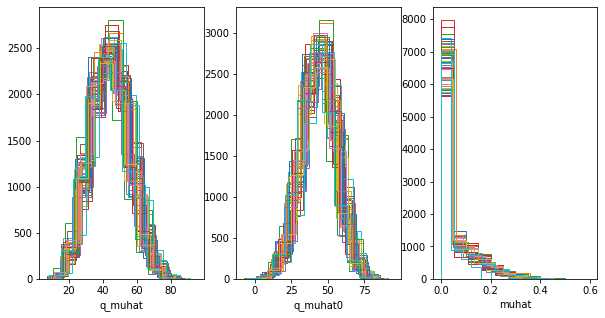

In [422]:
fig, ax = plt.subplots(1,3, figsize = (10,5))

for i, dist in enumerate(q_muhat_dist_lista):
    #print(np.sqrt(np.median(dist)))
    ax[0].hist(dist, histtype='step')
    ax[1].hist(q_muhat0_dist_lista[i], histtype='step')
    ax[2].hist(muhat_dist_lista[i], histtype='step')    
    
ax[0].set_xlabel('q_muhat')
ax[1].set_xlabel('q_muhat0')
ax[2].set_xlabel('muhat')
plt.savefig('../graph/HIGGS_Zexclusion_B{}_S{}_distros_nobs_{}_ensembles_{}.pdf'.format(B_expected, S_expected, nobs, n_ensembles))

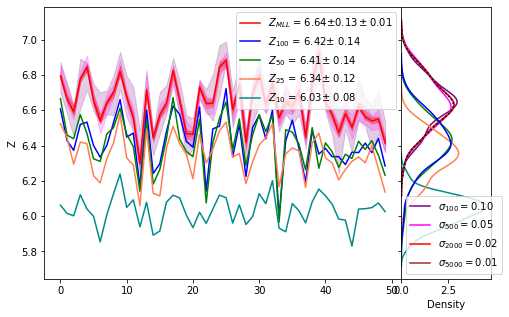

In [431]:
xcoord = np.arange(0, len(store_Z_MLL_KDE))
fig,ax = plt.subplots(1,2, figsize = (8,5), gridspec_kw={'width_ratios': [4, 1], 'wspace':0},  sharey=True)

z_lista = []
for j in range(10): # loop over the number of ensembles
    z_aux = []
    for i in range(len(q_muhat_dist_lista)): # loop over the testsets
        aux = np.random.choice(q_muhat_dist_lista[i], 100)
        z_aux.append( np.sqrt(np.median(aux)) )
    #ax[0].plot(z_aux, color = 'red', alpha = 0.3)
    z_lista.append( z_aux )
z_lista = np.asarray(z_lista)
ax[0].plot(np.mean(z_lista), color = 'purple')
ax[0].fill_between(xcoord, np.mean(z_lista, axis = 0) - np.std(z_lista, axis = 0), np.mean(z_lista, axis = 0) + np.std(z_lista, axis = 0), color = 'purple', alpha = 0.2)
sns.kdeplot(y=np.mean(z_lista, axis = 0), ax = ax[1], color = 'purple', label = '$\sigma_{100} = $' + '{:.2f}'.format(np.mean(np.std(z_lista, axis = 0))))

z_lista = []
for j in range(10): # loop over the number of ensembles
    z_aux = []
    for i in range(len(q_muhat_dist_lista)): # loop over the testsets
        aux = np.random.choice(q_muhat_dist_lista[i], 500)
        z_aux.append( np.sqrt(np.median(aux)) )
    #ax[0].plot(z_aux, color = 'red', alpha = 0.3)
    z_lista.append( z_aux )
z_lista = np.asarray(z_lista)
ax[0].plot(np.mean(z_lista), color = 'magenta')
ax[0].fill_between(xcoord, np.mean(z_lista, axis = 0) - np.std(z_lista, axis = 0), np.mean(z_lista, axis = 0) + np.std(z_lista, axis = 0), color = 'magenta', alpha = 0.2)
sns.kdeplot(y=np.mean(z_lista, axis = 0), ax = ax[1], color = 'magenta', label = '$\sigma_{500} = $' + '{:.2f}'.format(np.mean(np.std(z_lista, axis = 0))))

z_lista = []
for j in range(10): # loop over the number of ensembles
    z_aux = []
    for i in range(len(q_muhat_dist_lista)): # loop over the testsets
        aux = np.random.choice(q_muhat_dist_lista[i], 2000)
        z_aux.append( np.sqrt(np.median(aux)) )
    #ax[0].plot(z_aux, color = 'red', alpha = 0.3)
    z_lista.append( z_aux )
z_lista = np.asarray(z_lista)
ax[0].plot(np.mean(z_lista), color = 'red')
ax[0].fill_between(xcoord, np.mean(z_lista, axis = 0) - np.std(z_lista, axis = 0), np.mean(z_lista, axis = 0) + np.std(z_lista, axis = 0), color = 'red', alpha = 0.2)
sns.kdeplot(y=np.mean(z_lista, axis = 0), ax = ax[1], color = 'red', label = '$\sigma_{2000} = $' + '{:.2f}'.format(np.mean(np.std(z_lista, axis = 0))))

z_lista = []
for j in range(10): # loop over the number of ensembles
    z_aux = []
    for i in range(len(q_muhat_dist_lista)): # loop over the testsets
        aux = np.random.choice(q_muhat_dist_lista[i], 5000)
        z_aux.append( np.sqrt(np.median(aux)) )
    #ax[0].plot(z_aux, color = 'red', alpha = 0.3)
    z_lista.append( z_aux )
z_lista = np.asarray(z_lista)
ax[0].plot(np.mean(z_lista), color = 'brown')
ax[0].fill_between(xcoord, np.mean(z_lista, axis = 0) - np.std(z_lista, axis = 0), np.mean(z_lista, axis = 0) + np.std(z_lista, axis = 0), color = 'red', alpha = 0.2)
sns.kdeplot(y=np.mean(z_lista, axis = 0), ax = ax[1], color = 'brown', label = '$\sigma_{5000} = $' + '{:.2f}'.format(np.mean(np.std(z_lista, axis = 0))))


ax[0].plot(store_Z_MLL_KDE, color = 'red',
           label = r'$Z_{MLL}$ = ' + '{:.2f}'.format(np.mean(store_Z_MLL_KDE)) +'$\pm {:.2f} \pm {:.2f}$'.format(np.std(store_Z_MLL_KDE), np.mean(np.std(z_lista, axis = 0))))    
ax[0].plot(store_Z_bins_XG_100bins, color = 'blue', 
         label = r'$Z_{100}$ = ' + '{:.2f}'.format(np.mean(store_Z_bins_XG_100bins)) +'$\pm$ ' + '{:.2f}'.format(np.std(store_Z_bins_XG_100bins)) )
ax[0].plot(store_Z_bins_XG_50bins, color = 'green', 
         label = r'$Z_{50}$ = ' + '{:.2f}'.format(np.mean(store_Z_bins_XG_50bins)) +'$\pm$ ' + '{:.2f}'.format(np.std(store_Z_bins_XG_50bins)) )
ax[0].plot(store_Z_bins_XG_25bins, color = 'coral', 
         label = r'$Z_{25}$ = ' + '{:.2f}'.format(np.mean(store_Z_bins_XG_25bins)) +'$\pm$ ' + '{:.2f}'.format(np.std(store_Z_bins_XG_25bins)) )
ax[0].plot(store_Z_bins_XG_10bins, color = 'darkcyan', 
         label = r'$Z_{10}$ = ' + '{:.2f}'.format(np.mean(store_Z_bins_XG_10bins)) +'$\pm$ ' + '{:.2f}'.format(np.std(store_Z_bins_XG_10bins)) )
#plt.plot(store_Z_WP, color = 'black', label = 'WP')
ax[0].legend()
ax[0].set_ylabel('Z')

sns.kdeplot(y=store_Z_bins_XG_10bins, ax = ax[1], color = 'darkcyan')
sns.kdeplot(y=store_Z_bins_XG_25bins, ax = ax[1], color = 'coral')
sns.kdeplot(y=store_Z_bins_XG_50bins, ax = ax[1], color = 'green')
sns.kdeplot(y=store_Z_bins_XG_100bins, ax = ax[1], color = 'blue')
sns.kdeplot(y=store_Z_MLL_KDE, ax = ax[1], color = 'black', linestyle = ':')

ax[1].legend()
plt.savefig('../graph/HIGGS_Zexclusion_B{}_S{}_nobs_{}_ensembles_{}.pdf'.format(B_expected, S_expected, nobs, n_ensembles))

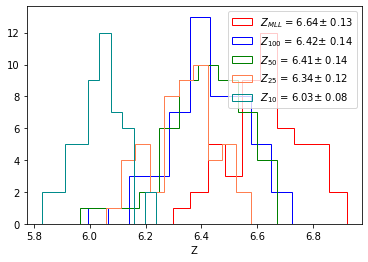

In [424]:
plt.hist(store_Z_MLL_KDE, color = 'red', histtype = 'step', 
         label = r'$Z_{MLL}$ = ' + '{:.2f}'.format(np.mean(store_Z_MLL_KDE)) +'$\pm$ ' + '{:.2f}'.format(np.std(store_Z_MLL_KDE)) )
plt.hist(store_Z_bins_XG_100bins, color = 'blue', histtype = 'step', 
         label = r'$Z_{100}$ = ' + '{:.2f}'.format(np.mean(store_Z_bins_XG_100bins)) +'$\pm$ ' + '{:.2f}'.format(np.std(store_Z_bins_XG_100bins)) )
plt.hist(store_Z_bins_XG_50bins, color = 'green', histtype = 'step', 
         label = r'$Z_{50}$ = ' + '{:.2f}'.format(np.mean(store_Z_bins_XG_50bins)) +'$\pm$ ' + '{:.2f}'.format(np.std(store_Z_bins_XG_50bins)) )
plt.hist(store_Z_bins_XG_25bins, color = 'coral', histtype = 'step', 
         label = r'$Z_{25}$ = ' + '{:.2f}'.format(np.mean(store_Z_bins_XG_25bins)) +'$\pm$ ' + '{:.2f}'.format(np.std(store_Z_bins_XG_25bins)) )
plt.hist(store_Z_bins_XG_10bins, color = 'darkcyan', histtype = 'step', 
         label = r'$Z_{10}$ = ' + '{:.2f}'.format(np.mean(store_Z_bins_XG_10bins)) +'$\pm$ ' + '{:.2f}'.format(np.std(store_Z_bins_XG_10bins)) )
plt.legend()
plt.xlabel('Z')
plt.savefig('../graph/HIGGS_Zexclusion_B{}_S{}_nobs_{}_ensembles_{}_distrosZ.pdf'.format(B_expected, S_expected, nobs, n_ensembles))

## Let's estimate the discovery significanceB_expected

0.8259154885267312
0.8201580887269484
0.8215891047953736
0.82122696367688
0.8191328437761095
0.8249645405725802


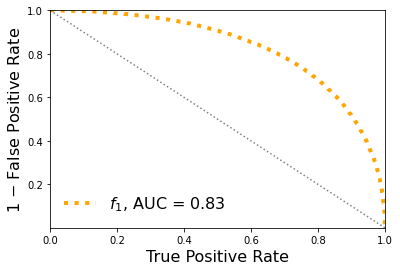

In [25]:
#######################
# CLASSIFIER: XGBoost #
#######################
classifiers = []

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators          = 3500,
    learning_rate         = 0.1,
    reg_lambda            = 0.0,
    reg_alpha             = 0.0,
    gamma                 = 0.0,
    objective             = 'binary:logistic',
    eval_metric           = 'logloss',
    early_stopping_rounds = 50,
    max_depth             = 5)

# FIT
#ran_ind = np.random.choice(np.arange(len(trainset)), size = len(trainset), replace = True)

classifier.fit(trainset[:,1:], trainset[:,0], 
               eval_set              = [(trainset[:,1:], trainset[:,0]), (valset[:,1:], valset[:,0])],
               verbose               = False)
classifiers.append(classifier)

# PREDICTIONS
y_pred_aux0 = classifier.predict_proba(testset[:,1:]).T[1]
y_pred_aux = np.reshape(y_pred_aux0, (1, len(y_pred_aux0)))

# ROC
fpr_gauss_xg, tpr_gauss_xg, _ = roc_curve(testset[:,0], y_pred_aux0)
roc_auc_xg = auc(fpr_gauss_xg, tpr_gauss_xg)

print(roc_auc_xg)

# PLOT THE ROC WITH AUC
plt.plot(tpr_gauss_xg, 1 - fpr_gauss_xg, label = "$f_{1}$, AUC = %0.2f" % roc_auc_xg, color = "orange", ls = ":", lw = 4)
plt.plot([1,0], [0,1], ls = ":", color = "grey")
plt.xlabel("True Positive Rate", fontsize = 16)
plt.ylabel("1 $-$ False Positive Rate", fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.])
plt.legend(frameon=False, fontsize=16)


for i in range(1, 10):
    # CLASSIFIER
    classifier = XGBClassifier(
        n_estimators          = 3500,
        learning_rate         = 0.1,
        reg_lambda            = 0.0,
        reg_alpha             = 0.0,
        gamma                 = 0.0,
        objective             = 'binary:logistic',
        eval_metric           = 'logloss',
        early_stopping_rounds = 50,
        max_depth             = 5)
    

    ran_ind = np.random.choice(np.arange(len(trainset)), size = len(trainset), replace = True)

    classifier.fit(trainset[ran_ind,1:], trainset[ran_ind,0], 
                   eval_set              = [(trainset[ran_ind,1:], trainset[ran_ind,0]), (valset[:,1:], valset[:,0])],
                   verbose               = False)

    classifiers.append(classifier)
    
    # PREDICTIONS
    y_pred_aux_it0 = classifier.predict_proba(testset[:,1:]).T[1]
    y_pred_aux_it = np.reshape(y_pred_aux_it0, (1, len(y_pred_aux_it0)))
    y_pred_aux = np.concatenate((y_pred_aux, y_pred_aux_it))

    # ROC
    fpr_gauss_xg_10, tpr_gauss_xg_10, _ = roc_curve(testset[:,0], y_pred_aux_it0)
    roc_auc_xg_10 = auc(fpr_gauss_xg_10, tpr_gauss_xg_10)
    
    print(roc_auc_xg_10)

    
y_pred_10 = np.mean(y_pred_aux, axis = 0)
fpr_gauss_xg_10, tpr_gauss_xg_10, _ = roc_curve(testset[:,0], y_pred_10)
roc_auc_xg_10 = auc(fpr_gauss_xg_10, tpr_gauss_xg_10)
print(roc_auc_xg_10)
#playsound('/home/martin/Downloads/mario.mp3')

Reading data from 0.0 ...
Classification score:


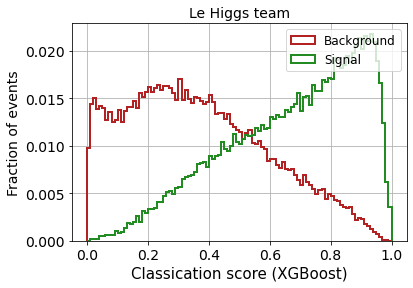

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.121558919580742

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.56542823964484

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.621406790705248

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.618369454842149

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



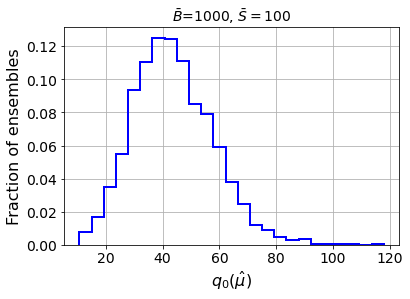

muhat mean:  1.0490185676392572
median q_muhat_KDE:  42.65235561827524
Z_KDE:  6.530877094102693
Z_KDE mu=1:  6.535344804110385
Z_WP:  5.139591649768096

 -------------------------------- 

Reading data from 1.0 ...
Classification score:


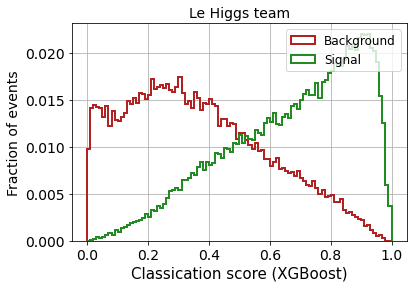

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.185395164038173

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.410160565739805

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.669778823145411

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.619481202364099

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



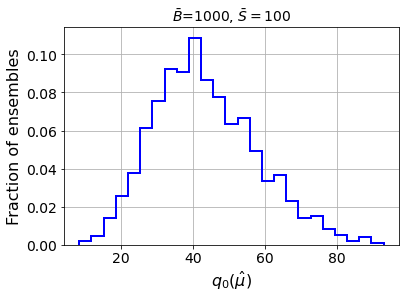

muhat mean:  1.0427055702917771
median q_muhat_KDE:  41.85433882829162
Z_KDE:  6.469492934403099
Z_KDE mu=1:  6.469443429425322
Z_WP:  5.218457761497611

 -------------------------------- 

Reading data from 2.0 ...
Classification score:


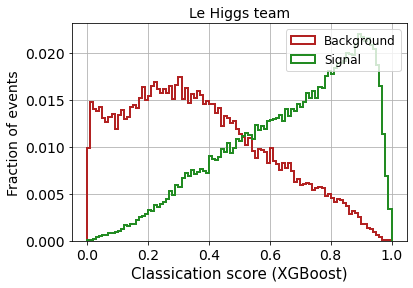

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.186472969395218

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.448005980279551

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.506817817016813

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.545087456303094

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



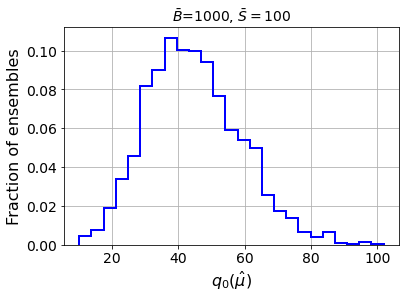

muhat mean:  1.0666312997347478
median q_muhat_KDE:  43.668681142356064
Z_KDE:  6.608228290726347
Z_KDE mu=1:  6.608578640630331
Z_WP:  5.137873487550463

 -------------------------------- 

Reading data from 3.0 ...
Classification score:


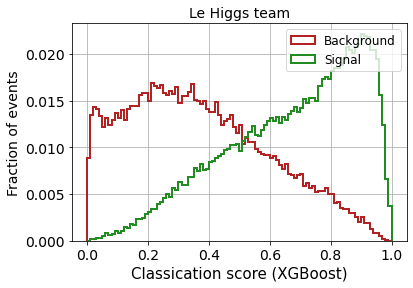

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.056775310698593

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.342713880065866

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.469662366972649

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.4256201530245916

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



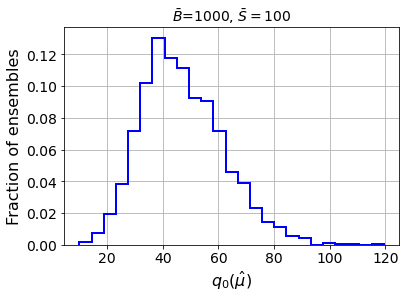

muhat mean:  1.089814323607427
median q_muhat_KDE:  45.55959632029038
Z_KDE:  6.749784909187135
Z_KDE mu=1:  6.748565264515752
Z_WP:  5.167670498920762

 -------------------------------- 

Reading data from 4.0 ...
Classification score:


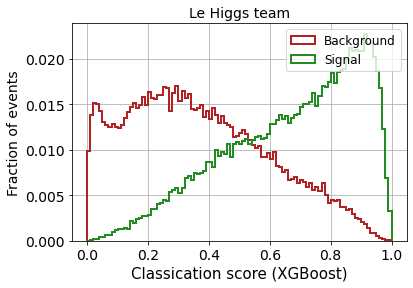

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.2451876271604645

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.599275625805144

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.624803292180619

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.669436314038712

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



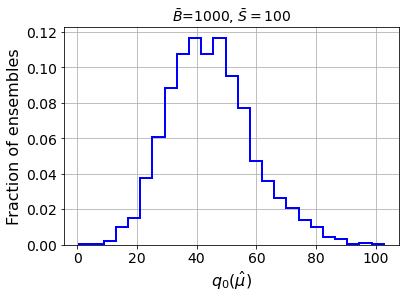

muhat mean:  1.0641909814323607
median q_muhat_KDE:  43.803951051280336
Z_KDE:  6.618455337258108
Z_KDE mu=1:  6.623459619916035
Z_WP:  5.159775635386321

 -------------------------------- 

Reading data from 5.0 ...
Classification score:


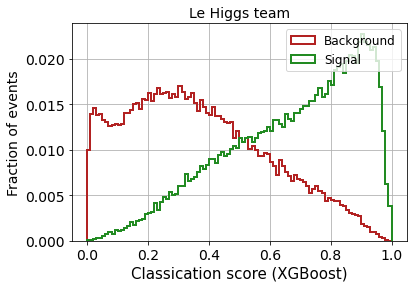

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.239451286775304

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.425768742615177

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.501446685352673

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.532282501793791

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



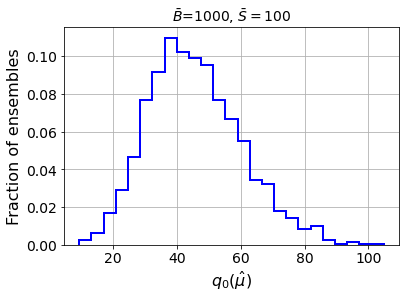

muhat mean:  1.0669496021220157
median q_muhat_KDE:  44.30896442329791
Z_KDE:  6.656497909809475
Z_KDE mu=1:  6.662423986562617
Z_WP:  5.174967312805298

 -------------------------------- 

Reading data from 6.0 ...
Classification score:


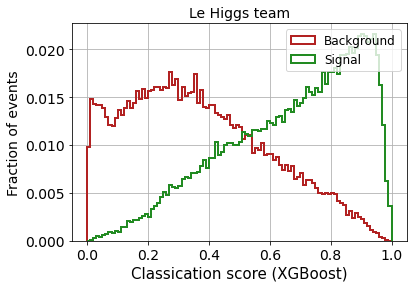

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.082942016271339

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.352425541818493

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.389606553219429

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.4302548829424255

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



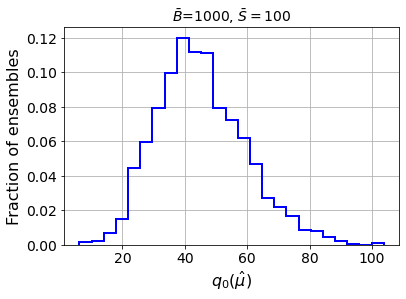

muhat mean:  1.062546419098143
median q_muhat_KDE:  43.98003860166645
Z_KDE:  6.631744763006674
Z_KDE mu=1:  6.631980762670404
Z_WP:  5.127532299653498

 -------------------------------- 

Reading data from 7.0 ...
Classification score:


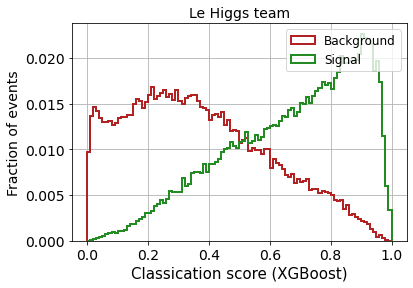

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.020020134046895

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.216286581612252

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.330954940512616

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.385607751203923

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



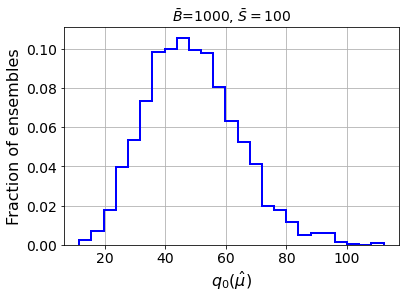

muhat mean:  1.1145888594164457
median q_muhat_KDE:  47.88887851374702
Z_KDE:  6.920179081046026
Z_KDE mu=1:  6.915434532956993
Z_WP:  5.082693563640873

 -------------------------------- 

Reading data from 8.0 ...
Classification score:


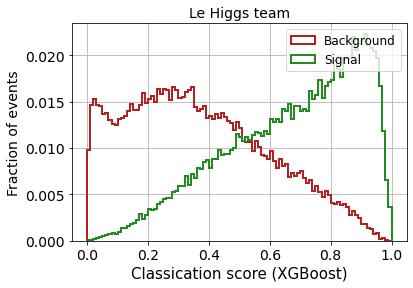

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.244512064027566

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.532882938872235

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.587801254703695

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.538865980822519

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



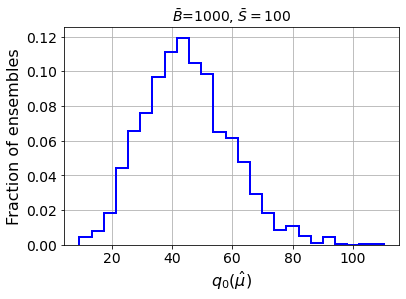

muhat mean:  1.0681697612732095
median q_muhat_KDE:  44.157245055596206
Z_KDE:  6.645091801893801
Z_KDE mu=1:  6.645091801893799
Z_WP:  5.132271172847957

 -------------------------------- 

Reading data from 9.0 ...
Classification score:


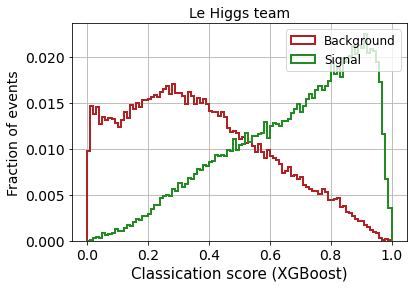

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.151283842703104

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.490244972855455

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.509032912404518

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.541126407365194

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



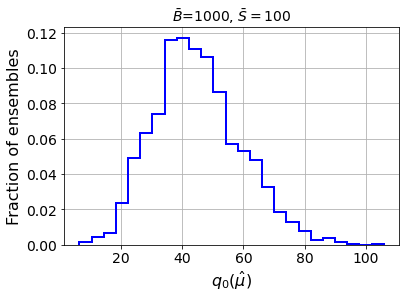

muhat mean:  1.0624933687002651
median q_muhat_KDE:  43.779610045205885
Z_KDE:  6.616616208093521
Z_KDE mu=1:  6.614503015334048
Z_WP:  5.203418263608458

 -------------------------------- 

Reading data from 10.0 ...
Classification score:


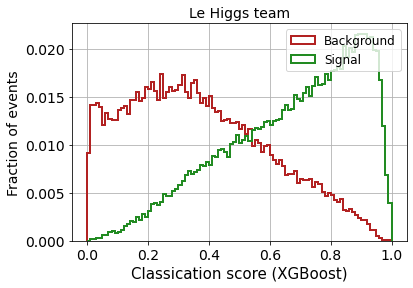

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.111592393975992

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.517716542553546

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.5582742737719

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.630471053094275

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



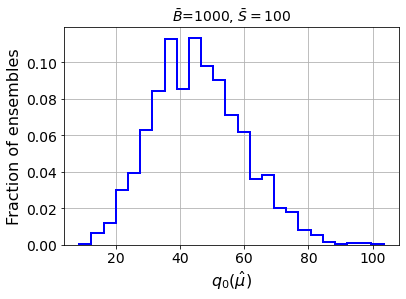

muhat mean:  1.0794164456233422
median q_muhat_KDE:  45.22302393129584
Z_KDE:  6.724806609211587
Z_KDE mu=1:  6.726271171840618
Z_WP:  5.139160691151498

 -------------------------------- 

Reading data from 11.0 ...
Classification score:


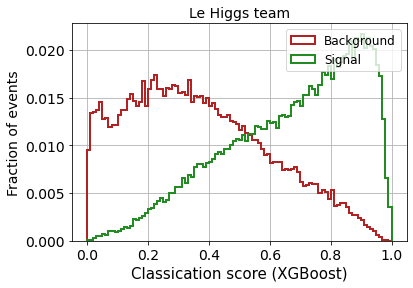

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.147017420822401

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.476384898415259

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.523694280968356

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.512377049652782

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



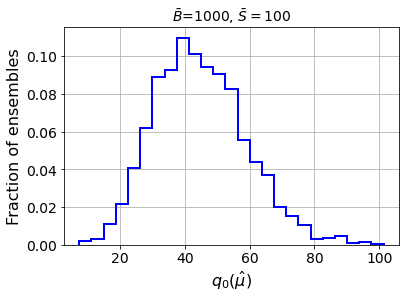

muhat mean:  1.0644031830238727
median q_muhat_KDE:  43.6802017491685
Z_KDE:  6.609099919744632
Z_KDE mu=1:  6.610500754660257
Z_WP:  5.202124788119631

 -------------------------------- 

Reading data from 12.0 ...
Classification score:


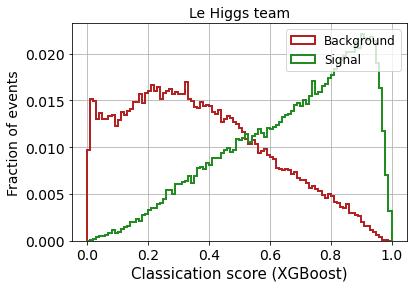

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.277240973006587

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.600444195054871

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.672332999948023

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.666509950488768

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



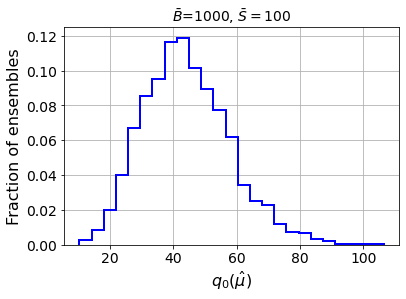

muhat mean:  1.0606896551724136
median q_muhat_KDE:  43.28273200286111
Z_KDE:  6.578961316413185
Z_KDE mu=1:  6.578012564640102
Z_WP:  5.219893802836708

 -------------------------------- 

Reading data from 13.0 ...
Classification score:


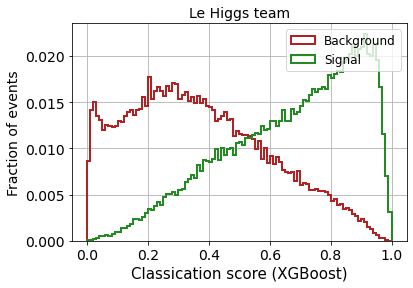

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.09649985998031

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.4030524466568615

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.483516831453017

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.430987197184533

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



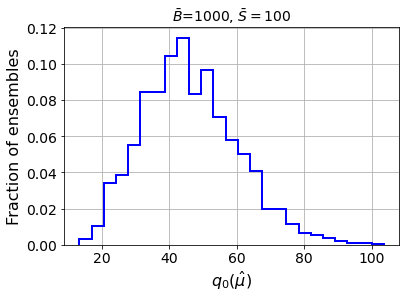

muhat mean:  1.0853050397877984
median q_muhat_KDE:  44.961066100759695
Z_KDE:  6.705301343024018
Z_KDE mu=1:  6.705301343024024
Z_WP:  5.171566236574102

 -------------------------------- 

Reading data from 14.0 ...
Classification score:


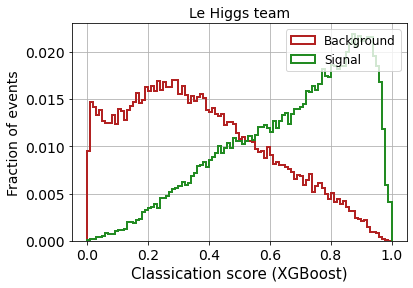

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.093100689445938

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.432519628030202

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.464872752023834

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.523967140560005

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



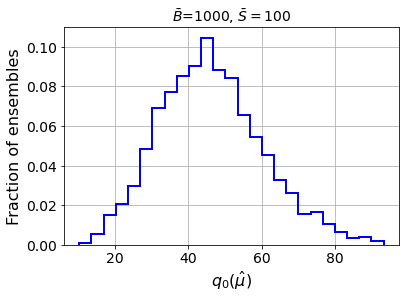

muhat mean:  1.0862599469496022
median q_muhat_KDE:  45.44154402357984
Z_KDE:  6.741034343747244
Z_KDE mu=1:  6.740897700944972
Z_WP:  5.142479526198901

 -------------------------------- 

Reading data from 15.0 ...
Classification score:


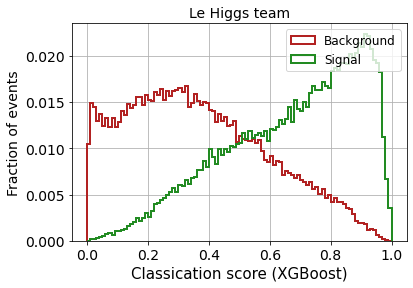

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.223073544974525

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.571913891760445

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.610040486939173

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.650201047168573

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



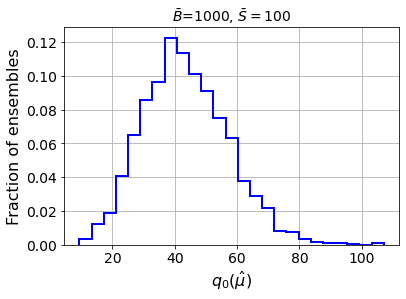

muhat mean:  1.0499204244031828
median q_muhat_KDE:  42.433786808015185
Z_KDE:  6.514122105703514
Z_KDE mu=1:  6.5149195012462995
Z_WP:  5.179896520667209

 -------------------------------- 

Reading data from 16.0 ...
Classification score:


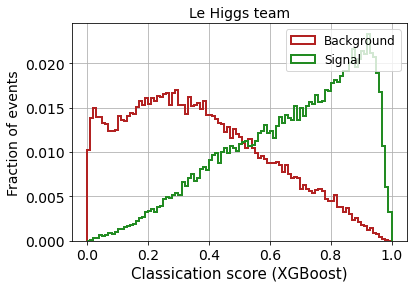

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.196015866992592

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.428656294034068

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.526096688278937

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.474958921103598

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



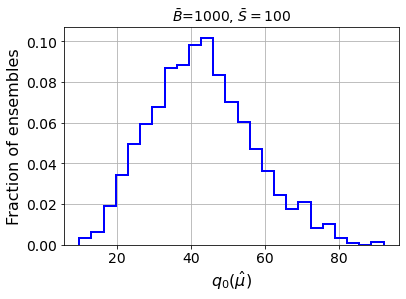

muhat mean:  1.0415384615384613
median q_muhat_KDE:  42.23875847145544
Z_KDE:  6.499135209507142
Z_KDE mu=1:  6.499977938071103
Z_WP:  5.158313556118585

 -------------------------------- 

Reading data from 17.0 ...
Classification score:


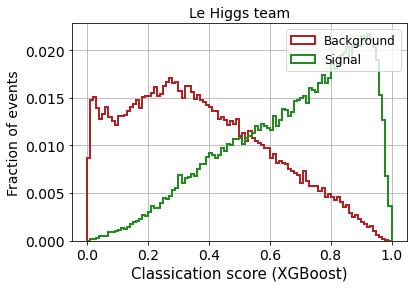

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.099630579820227

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.409208955047885

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.465556747186022

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.517173629973948

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



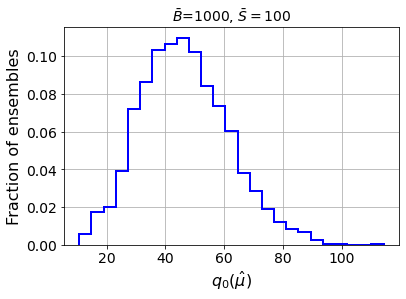

muhat mean:  1.0887002652519893
median q_muhat_KDE:  46.075364677755346
Z_KDE:  6.787883667075869
Z_KDE mu=1:  6.785786239921405
Z_WP:  5.135425508515335

 -------------------------------- 

Reading data from 18.0 ...
Classification score:


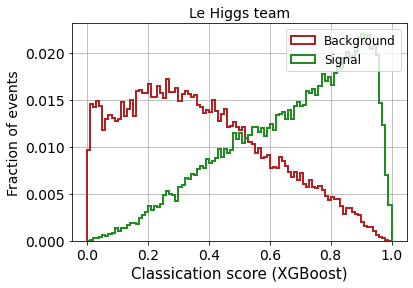

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.130618805776795

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.373498341942786

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.55390483068157

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.486640717902132

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



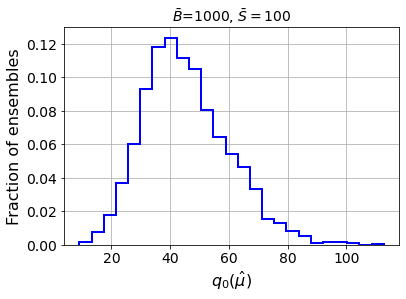

muhat mean:  1.0709814323607427
median q_muhat_KDE:  44.07816529218226
Z_KDE:  6.6391388968888325
Z_KDE mu=1:  6.639305795044274
Z_WP:  5.136028490469782

 -------------------------------- 

Reading data from 19.0 ...
Classification score:


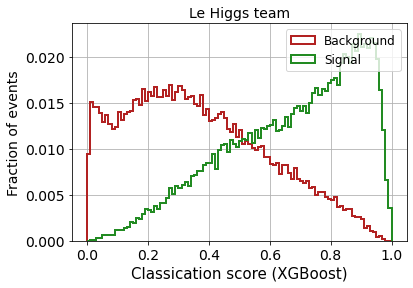

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.245447250869114

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.533389542409431

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.390076268336618

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.496468520931463

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



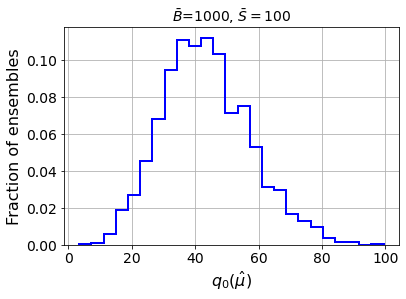

muhat mean:  1.0446153846153845
median q_muhat_KDE:  42.385306424498
Z_KDE:  6.510399866713104
Z_KDE mu=1:  6.5141710792055045
Z_WP:  5.197456946067742

 -------------------------------- 

Reading data from 20.0 ...
Classification score:


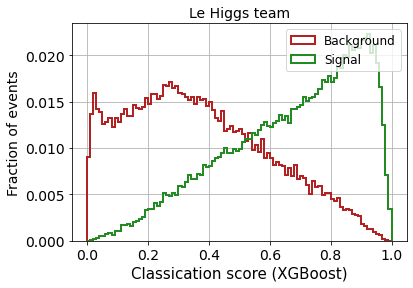

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.215117000273115

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.3757473005445755

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.446659563202815

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.4830714729523224

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



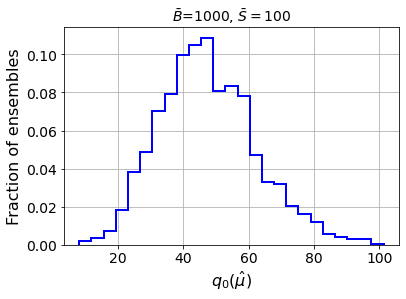

muhat mean:  1.0933687002652517
median q_muhat_KDE:  46.473895157006865
Z_KDE:  6.817176479819696
Z_KDE mu=1:  6.817555002640587
Z_WP:  5.16688541133561

 -------------------------------- 

Reading data from 21.0 ...
Classification score:


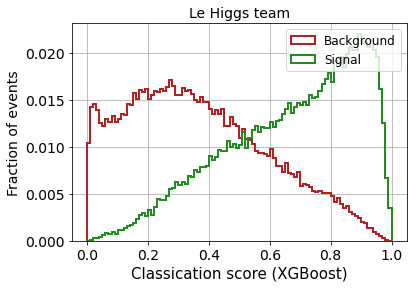

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.120478064341202

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.36713360003693

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.486140942504973

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.419769400738753

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



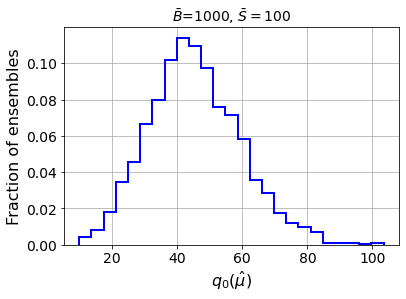

muhat mean:  1.0644562334217504
median q_muhat_KDE:  44.52662859525262
Z_KDE:  6.672827631166013
Z_KDE mu=1:  6.674468803260063
Z_WP:  5.165803898954529

 -------------------------------- 

Reading data from 22.0 ...
Classification score:


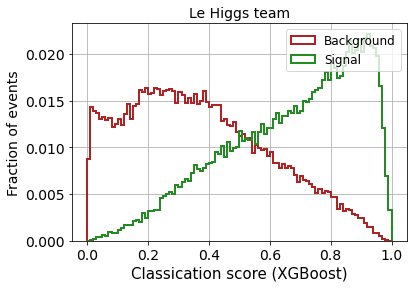

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.05166609980558

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.353182122997471

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.405547695557438

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.459529430695678

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



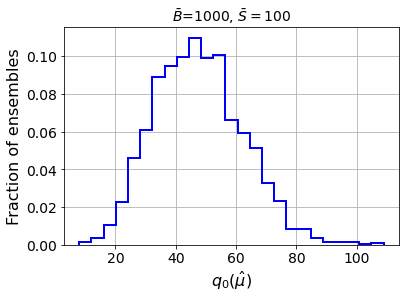

muhat mean:  1.102546419098143
median q_muhat_KDE:  47.08303697411736
Z_KDE:  6.861708021631157
Z_KDE mu=1:  6.858301832571367
Z_WP:  5.138724364859009

 -------------------------------- 

Reading data from 23.0 ...
Classification score:


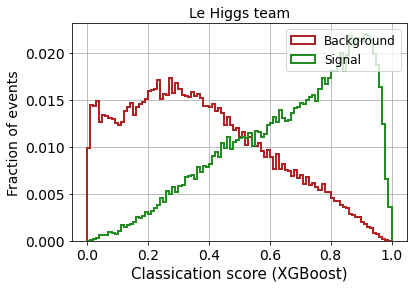

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.160463271366662

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.427000898628618

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.493903844231857

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.511536884627751

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



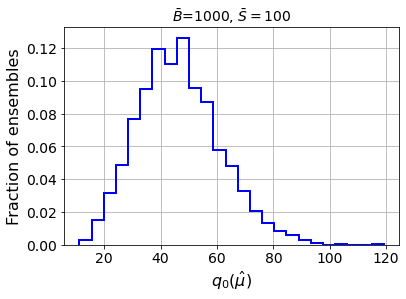

muhat mean:  1.0868435013262598
median q_muhat_KDE:  45.74483739228006
Z_KDE:  6.763492987523537
Z_KDE mu=1:  6.7561945611501555
Z_WP:  5.1311642241228625

 -------------------------------- 

Reading data from 24.0 ...
Classification score:


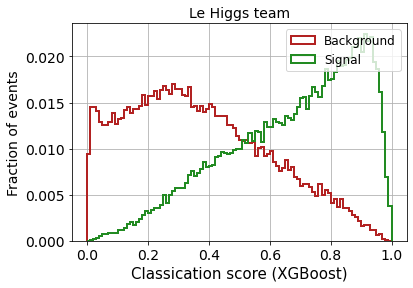

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.155177114984742

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.294939767972224

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.378122100020904

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.371561749121643

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



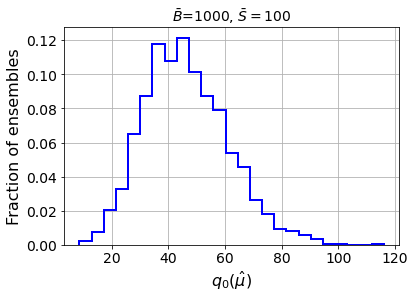

muhat mean:  1.0774005305039787
median q_muhat_KDE:  45.06329021283179
Z_KDE:  6.712919648918181
Z_KDE mu=1:  6.717950385738558
Z_WP:  5.22718417733951

 -------------------------------- 

Reading data from 25.0 ...
Classification score:


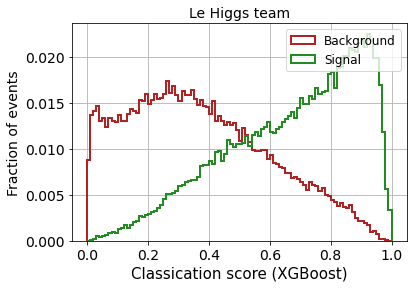

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.159763871484597

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.5848283320909

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.621502594913118

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.579086886299081

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



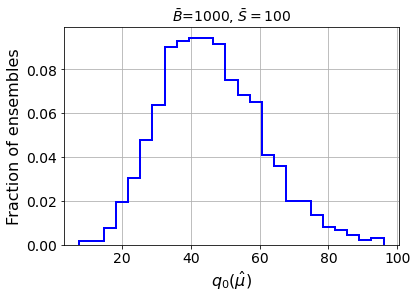

muhat mean:  1.086525198938992
median q_muhat_KDE:  44.91354419439904
Z_KDE:  6.701756799108652
Z_KDE mu=1:  6.701952047017958
Z_WP:  5.175076435006085

 -------------------------------- 

Reading data from 26.0 ...
Classification score:


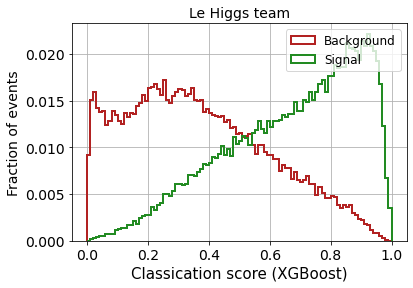

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.078685746364643

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.353712828508379

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.510217839264949

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.44425739777428

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



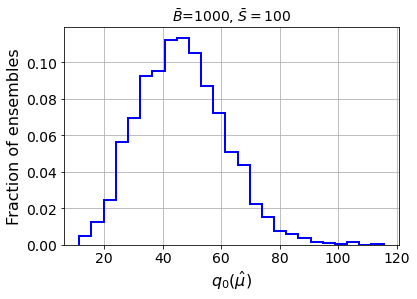

muhat mean:  1.082705570291777
median q_muhat_KDE:  45.78870369280381
Z_KDE:  6.7667350836872435
Z_KDE mu=1:  6.768265492174894
Z_WP:  5.1149822356933035

 -------------------------------- 

Reading data from 27.0 ...
Classification score:


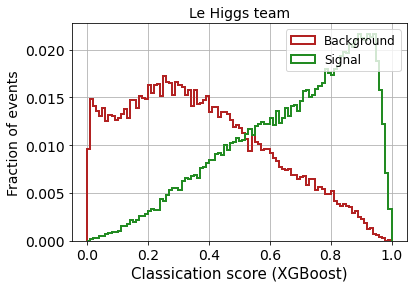

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.154202299878797

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.473487344346668

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.605755277069594

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.652622128421889

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



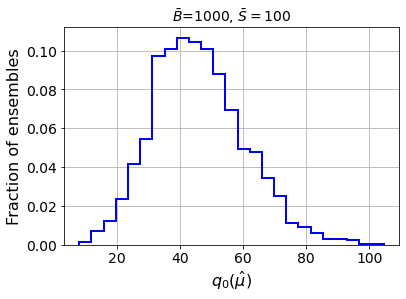

muhat mean:  1.0847745358090184
median q_muhat_KDE:  44.69099422424057
Z_KDE:  6.6851323266066
Z_KDE mu=1:  6.6799816565292724
Z_WP:  5.120036211419764

 -------------------------------- 

Reading data from 28.0 ...
Classification score:


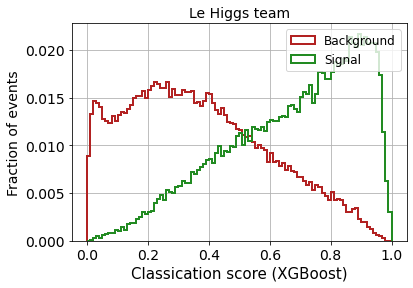

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.10393579433237

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.366690946593115

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.522676151919608

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.547657151157828

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



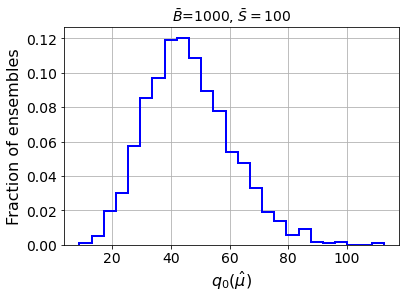

muhat mean:  1.0849336870026525
median q_muhat_KDE:  45.183027783214385
Z_KDE:  6.7218321745796645
Z_KDE mu=1:  6.718208390335586
Z_WP:  5.1464970314849605

 -------------------------------- 

Reading data from 29.0 ...
Classification score:


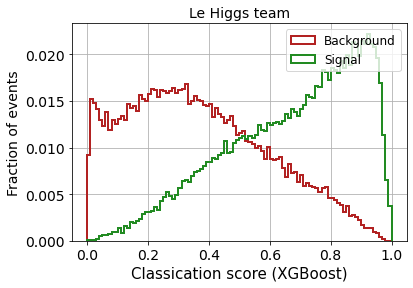

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.281600029335469

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.584792465205161

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.788704358167626

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.712288720737573

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



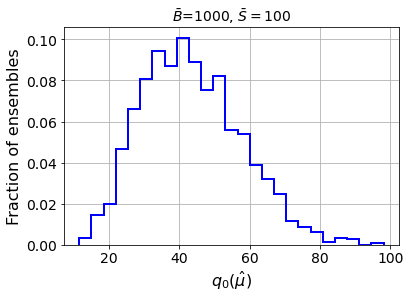

muhat mean:  1.0514058355437663
median q_muhat_KDE:  42.37566023991329
Z_KDE:  6.509658995670455
Z_KDE mu=1:  6.5141101258771705
Z_WP:  5.209364653042099

 -------------------------------- 

Reading data from 30.0 ...
Classification score:


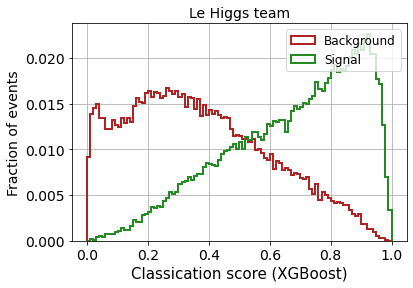

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.209765720813562

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.527954705760637

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.666870641083257

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.606548520644838

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



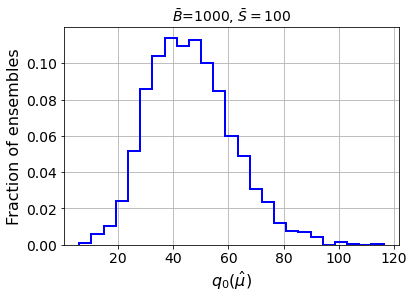

muhat mean:  1.0914058355437664
median q_muhat_KDE:  45.40904893700582
Z_KDE:  6.738623667857245
Z_KDE mu=1:  6.732709428350063
Z_WP:  5.165665210183681

 -------------------------------- 

Reading data from 31.0 ...
Classification score:


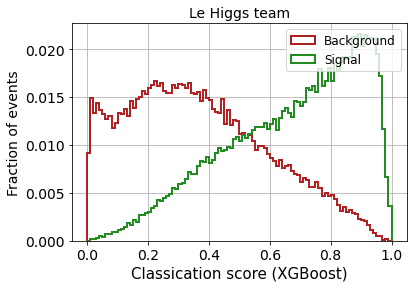

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.1519388905797365

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.452695838973864

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.512146597399404

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.522049459023622

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



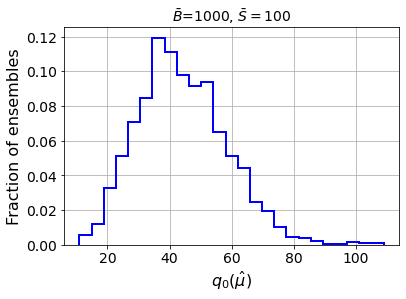

muhat mean:  1.0516710875331565
median q_muhat_KDE:  42.73551097462044
Z_KDE:  6.537240317949191
Z_KDE mu=1:  6.531934336957374
Z_WP:  5.196975492367607

 -------------------------------- 

Reading data from 32.0 ...
Classification score:


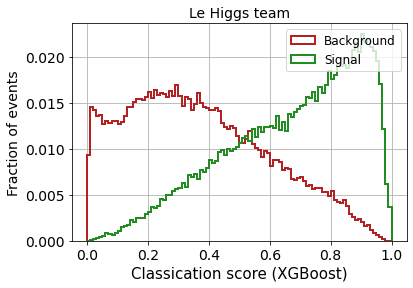

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.193618608639314

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.5258344186695405

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.743379336535385

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.688497508410349

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



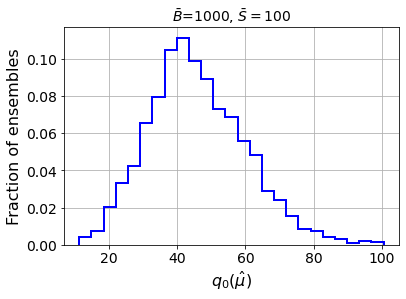

muhat mean:  1.083395225464191
median q_muhat_KDE:  44.33829303784384
Z_KDE:  6.658700551747604
Z_KDE mu=1:  6.6589918860508766
Z_WP:  5.125240837887068

 -------------------------------- 

Reading data from 33.0 ...
Classification score:


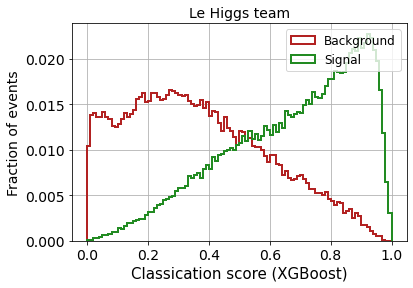

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.326102430043409

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.577195914806246

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.805142001635067

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.814286245340647

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



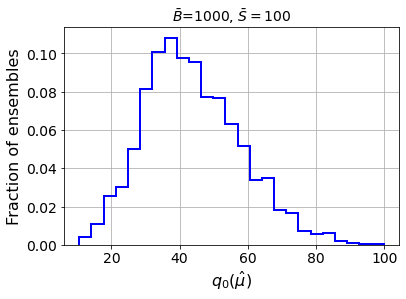

muhat mean:  1.0557559681697612
median q_muhat_KDE:  42.40540518732101
Z_KDE:  6.511943272735183
Z_KDE mu=1:  6.510558183082557
Z_WP:  5.204467321316644

 -------------------------------- 

Reading data from 34.0 ...
Classification score:


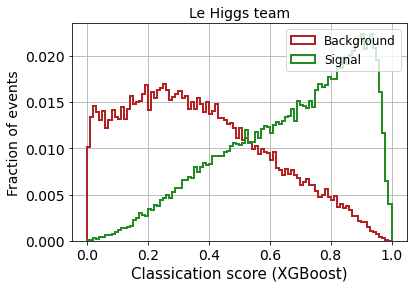

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.152427458641007

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.443471840347295

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.547049986526772

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.484923991688554

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



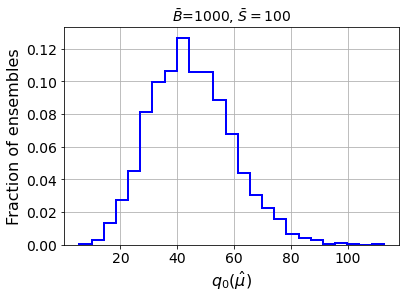

muhat mean:  1.0638726790450928
median q_muhat_KDE:  44.03597152799014
Z_KDE:  6.635960482702571
Z_KDE mu=1:  6.637965977973922
Z_WP:  5.157510497942645

 -------------------------------- 

Reading data from 35.0 ...
Classification score:


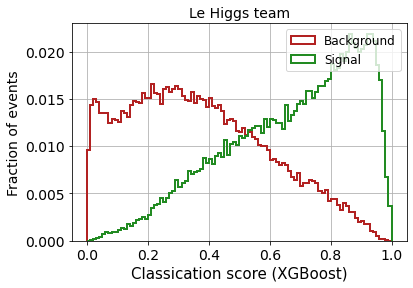

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.215257755971847

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.664174673772435

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.739938170411322

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.696043454624324

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



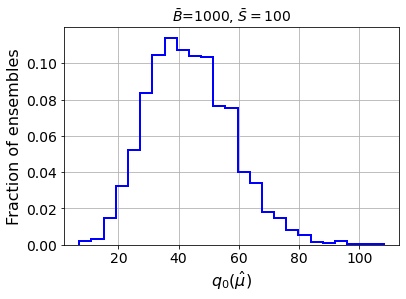

muhat mean:  1.0586737400530504
median q_muhat_KDE:  42.993036615921795
Z_KDE:  6.556907549746435
Z_KDE mu=1:  6.561081939976779
Z_WP:  5.2009193156737314

 -------------------------------- 

Reading data from 36.0 ...
Classification score:


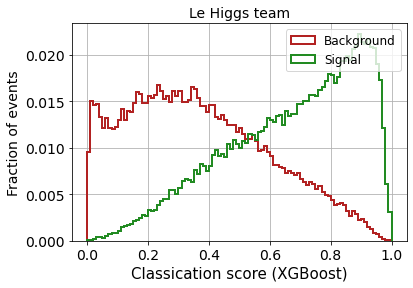

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.100505498882078

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.425202486666177

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.485451448417786

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.50354958634637

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



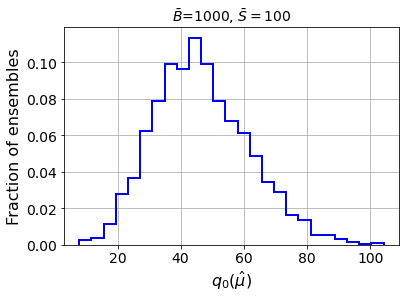

muhat mean:  1.0884880636604772
median q_muhat_KDE:  45.38140234137424
Z_KDE:  6.736572002240772
Z_KDE mu=1:  6.741761689404758
Z_WP:  5.141752592528506

 -------------------------------- 

Reading data from 37.0 ...
Classification score:


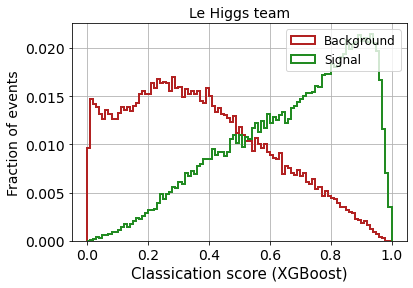

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.161174114034417

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.480479511165224

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.635643873782272

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.660249310500255

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



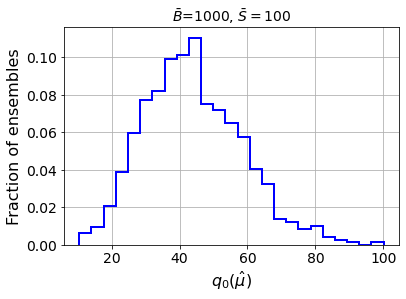

muhat mean:  1.0524668435013262
median q_muhat_KDE:  43.03098453048975
Z_KDE:  6.559800647160685
Z_KDE mu=1:  6.564254181994609
Z_WP:  5.189994410271832

 -------------------------------- 

Reading data from 38.0 ...
Classification score:


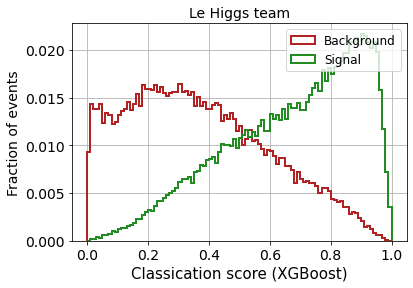

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.159482807574845

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.360089200474413

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.572722389042772

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.513753038758686

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



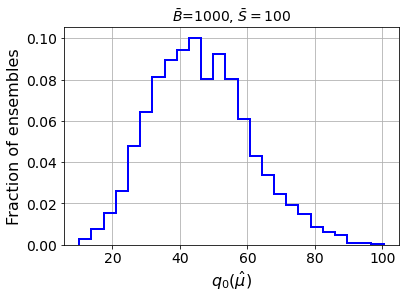

muhat mean:  1.0882228116710877
median q_muhat_KDE:  45.05710580563505
Z_KDE:  6.7124589984323215
Z_KDE mu=1:  6.717470160556332
Z_WP:  5.128294077913412

 -------------------------------- 

Reading data from 39.0 ...
Classification score:


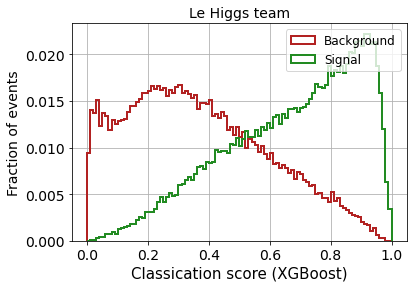

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.1088676586612785

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.417874418612158

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.536002806332451

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.5740662847237346

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



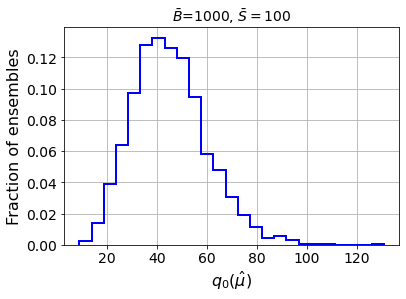

muhat mean:  1.0694960212201592
median q_muhat_KDE:  43.90761256174619
Z_KDE:  6.626281956100736
Z_KDE mu=1:  6.626786021290232
Z_WP:  5.161684948309201

 -------------------------------- 

Reading data from 40.0 ...
Classification score:


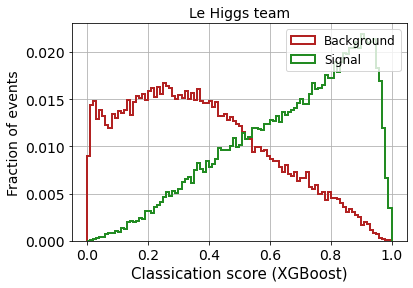

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.179075226812386

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.464780279048634

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.523826163469896

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.543466069302323

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



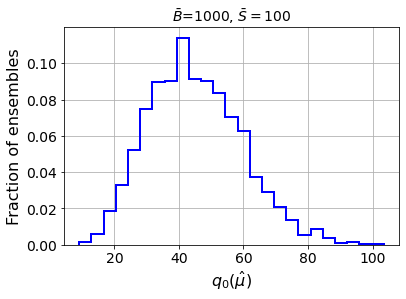

muhat mean:  1.0712466843501325
median q_muhat_KDE:  43.81167005700078
Z_KDE:  6.619038454111049
Z_KDE mu=1:  6.617872045126433
Z_WP:  5.143088991899716

 -------------------------------- 

Reading data from 41.0 ...
Classification score:


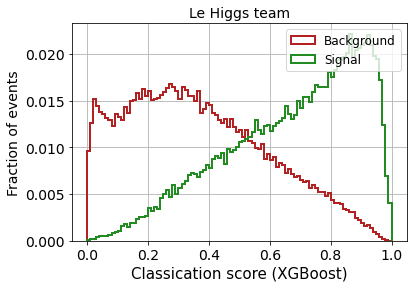

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.211625596174983

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.517040440531193

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.6216211507038345

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.5452560238656226

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



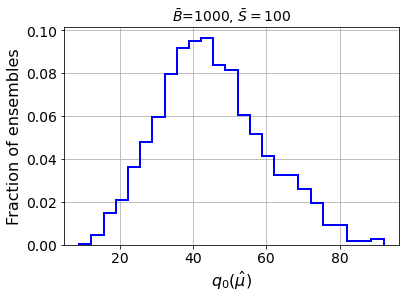

muhat mean:  1.0604244031830237
median q_muhat_KDE:  43.98295882558304
Z_KDE:  6.631964929459673
Z_KDE mu=1:  6.6339252836945395
Z_WP:  5.223890658041353

 -------------------------------- 

Reading data from 42.0 ...
Classification score:


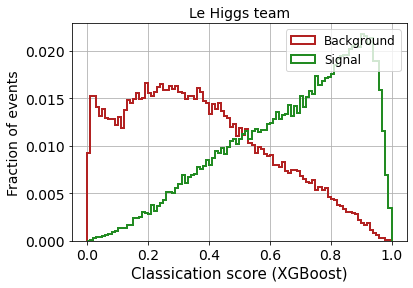

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.185221378760379

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.418973927712916

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.49436274671374

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.529302801246219

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



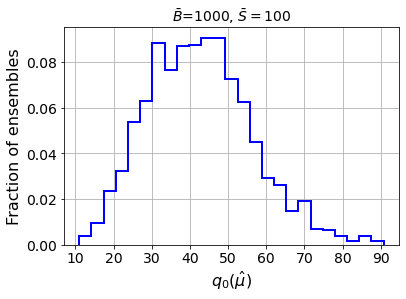

muhat mean:  1.0367639257294428
median q_muhat_KDE:  41.99657492633335
Z_KDE:  6.480476442849966
Z_KDE mu=1:  6.481697627782536
Z_WP:  5.1699044707046715

 -------------------------------- 

Reading data from 43.0 ...
Classification score:


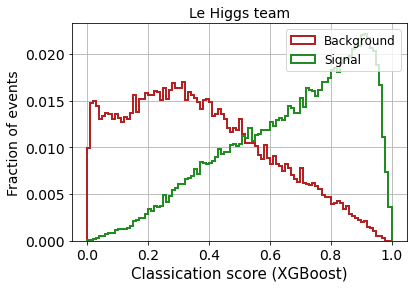

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.131868213948555

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.399030313699861

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.688370818477835

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.616360483162545

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



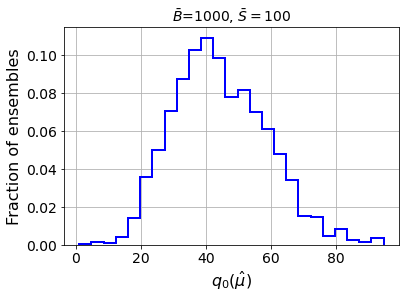

muhat mean:  1.0571352785145887
median q_muhat_KDE:  43.176994642259245
Z_KDE:  6.5709203801491345
Z_KDE mu=1:  6.573933584579653
Z_WP:  5.180841175022461

 -------------------------------- 

Reading data from 44.0 ...
Classification score:


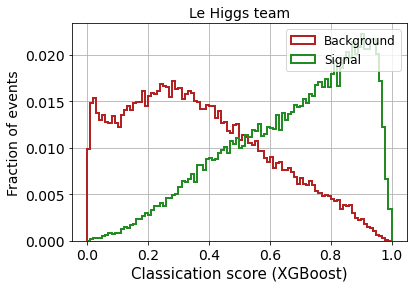

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.127709174496812

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.423330517628158

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.532508382110341

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.479722001724741

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



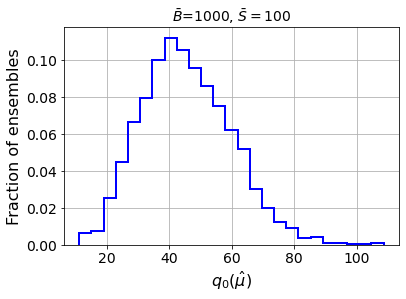

muhat mean:  1.0677984084880636
median q_muhat_KDE:  44.38245118633844
Z_KDE:  6.662015549842138
Z_KDE mu=1:  6.662015549842142
Z_WP:  5.181148548961396

 -------------------------------- 

Reading data from 45.0 ...
Classification score:


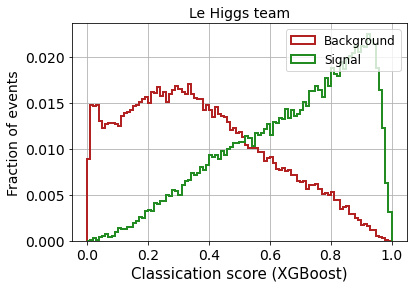

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.167880790060077

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.395166886372425

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.4944115316158175

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.453592805152517

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



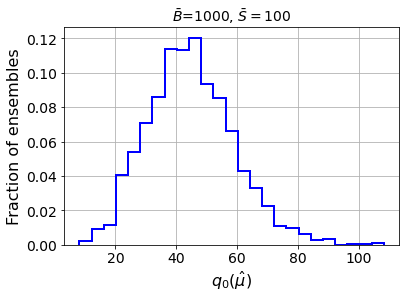

muhat mean:  1.063129973474801
median q_muhat_KDE:  44.141215040531534
Z_KDE:  6.643885537886059
Z_KDE mu=1:  6.642042830291739
Z_WP:  5.139631376600817

 -------------------------------- 

Reading data from 46.0 ...
Classification score:


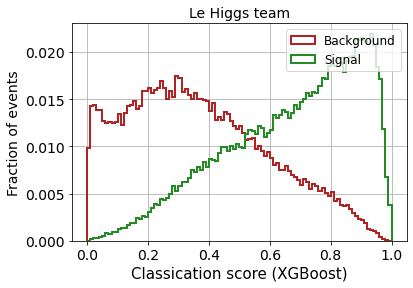

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.1262270690400005

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.413406545242495

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.443984897862923

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.381746426235265

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



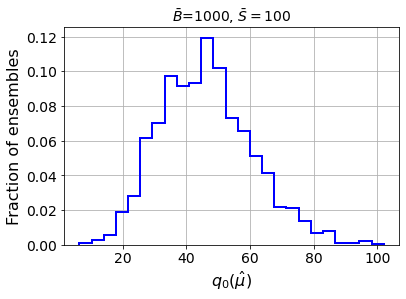

muhat mean:  1.0813793103448275
median q_muhat_KDE:  45.53176595565395
Z_KDE:  6.747723020075287
Z_KDE mu=1:  6.740779240198329
Z_WP:  5.152379396752094

 -------------------------------- 

Reading data from 47.0 ...
Classification score:


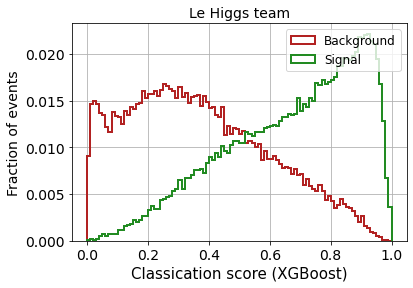

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.231599455626162

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.587758649798897

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.623561180374843

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.7105942348992835

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



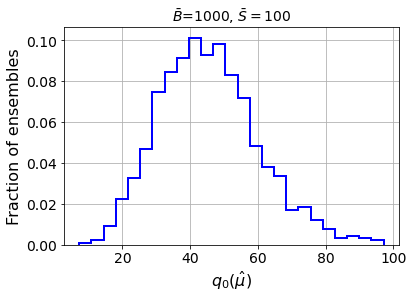

muhat mean:  1.0724668435013263
median q_muhat_KDE:  44.487295439575774
Z_KDE:  6.669879717024571
Z_KDE mu=1:  6.673812606131084
Z_WP:  5.173519803765976

 -------------------------------- 

Reading data from 48.0 ...
Classification score:


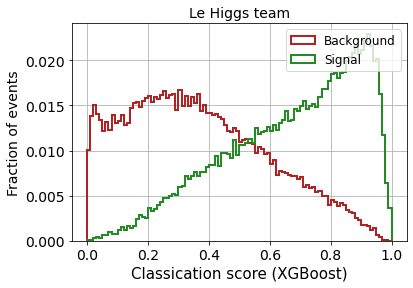

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.162772367671128

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.46881014800288

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.502283435769424

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.588737473151568

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



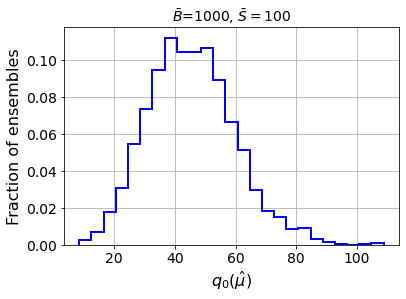

muhat mean:  1.0717241379310343
median q_muhat_KDE:  44.79616478031136
Z_KDE:  6.692993708372312
Z_KDE mu=1:  6.692855405874729
Z_WP:  5.1777917119622545

 -------------------------------- 

Reading data from 49.0 ...
Classification score:


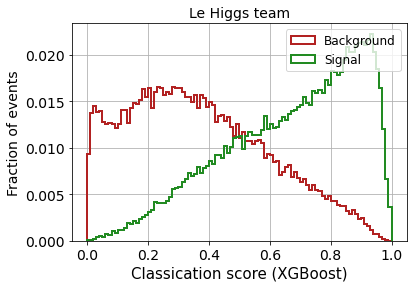

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 10 bins:  6.138046288424316

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 25 bins:  6.442936556724656

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 50 bins:  6.553168473946203

 ----------------------------------------- 

BINNED CLASSIFIER OUTPUT
B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
Z_XG 100 bins:  6.573338807913331

 ----------------------------------------- 

Evaluating the full test dataset with KDE (may take long...)
done


B_expected:  1000
S_expected:  100
S/$\sqrt{B}$:  3.1622776601683795
n_ensembles (initial):  2000

 If  220  =  158    then the proposed range has to be extended
n_ensembles (actual):  1885

 This may take long... 



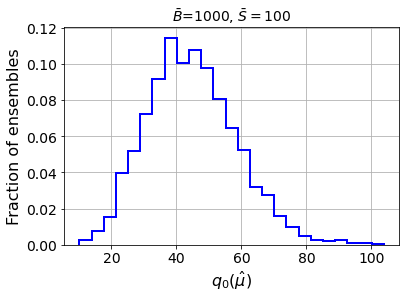

muhat mean:  1.0658355437665783
median q_muhat_KDE:  44.07889823744162
Z_KDE:  6.63919409547888
Z_KDE mu=1:  6.640470324444673
Z_WP:  5.189746357237323

 -------------------------------- 



In [48]:
# requested number of ensembles
n_ensembles = 2000

# number of expected background events per ensemble
B_expected = 1000

# S_expected:
S_expected = 100

# SOME USEFUL DERIVATED PARAMETERS (maybe not used?):

# ratio S_expected/B_expected (signal ratio)
SB_ratio = 0.1

# S/\sqrt{B}
SsqrtB = S_expected / (B_expected)**0.5

npool = 100_000

store_Z_bins_XG_10bins  = []
store_Z_bins_XG_25bins  = []
store_Z_bins_XG_50bins  = []
store_Z_bins_XG_100bins = []
store_Z_MLL_KDE         = []
store_Z_MLL_KDE_mu0     = []
store_Z_WP              = []
store_WP                = []
store_muhat_mean_MLL_KDE = []

q_muhat_dist_lista  = []
muhat_dist_lista    = []
q_muhat0_dist_lista = []

store_Z_MLL_KDE_10         = []
store_Z_MLL_KDE_mu0_10     = []
store_Z_WP_10              = []
store_WP_10                = []
store_muhat_mean_MLL_KDE_10 = []

q_muhat_dist_lista_10  = []
muhat_dist_lista_10    = []
q_muhat0_dist_lista_10 = []

bins10  = True
bins25  = True
bins50  = True
bins100 = True
mllkde  = True

for te in range(50):
    i_ini = 1_000_000 + te * npool
    testset = read_data(i_ini, npool)
    X_gauss_test = testset[:,1:]
    Y_gauss_test = testset[:,0]
 
    #y_pred_xg = classifier.predict_proba(testset[:,1:]).T[1] # For non-smooth
    # for smooth
    for i in range(len(classifiers)):
        if i == 0 : 
            y_pred_xg = classifiers[i].predict_proba(testset[:,1:]).T[1]
        else: 
            y_pred_xg = y_pred_xg + classifiers[i].predict_proba(testset[:,1:]).T[1]

    y_pred_xg = y_pred_xg / len(classifiers)
    #y_pred_xg = y_pred_10 # If smooth for the main testset
    #y_pred_xg = y_pred_aux0 # If non-smooth for the main testset
    
    pred_XG_SM = []
    pred_XG_NP = []

    for i in range(len(Y_gauss_test)):
        if Y_gauss_test[i] == 0:
            pred_XG_SM.append(y_pred_xg[i])
        else:
            pred_XG_NP.append(y_pred_xg[i])


    print('Classification score:')

    weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
    nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

    weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
    nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Classication score (XGBoost)",fontsize=15)
    plt.ylabel("Fraction of events",fontsize=14)
    plt.grid()
    plt.legend(fontsize=12)
    plt.title('Le Higgs team', fontsize=14)
    plt.show()


    # CHECKEAR QUE TENGAS #

    # X_gauss_train = trainset[:,1:]
    # Y_gauss_train = trainset[:,0]

    # X_gauss_val = valset[:,1:]
    # Y_gauss_val = valset[:,0]

    # X_gauss_test = testset[:,1:]
    # Y_gauss_test = testset[:,0]

    # y_pred_xg = y_pred

    ##################################################
    # CLASSIFIER OUTPUT BINNED POISON LOG-LIKELIHOOD #
    ##################################################

    # 10 BINS

    print('BINNED CLASSIFIER OUTPUT')
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)

    if bins10:
        # Les't find the number of possible ensembles
        N_ensembles_back = len(pred_XG_SM) / B_expected
        N_ensembles_sig = len(pred_XG_NP) / S_expected



        #Let's find out the expected number of B and S events in each bin:

        # bin the parameter space of all background events
        hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(10), range = [[0,1]])

        # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

        # find the minimum
        hist_back_noceros = []
        for i in range(len(hist_back)):
            if hist_back[i]!=0:
                hist_back_noceros.append(hist_back[i])

        min_back = min(hist_back_noceros)

        # replace the zeros
        for i in range(len(hist_back)):
            if hist_back[i]==0:
                hist_back[i] = min_back

        # now divide by the number of possible ensembles
        back_prom = hist_back/N_ensembles_back



        # same for signal
        hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(10), range = [[0,1]])
        sig_prom = hist_sig/N_ensembles_sig



        # then the signif Z^binned-Asimov:
        # EXCLUSION:
        #Z_bins_XG_10bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

        # DISCOVERY:
        Z_bins_XG_10bins = ( 2* sum( ( (sig_prom + back_prom) * np.log( 1 + (sig_prom/back_prom) ) ) - sig_prom ) )**0.5

        store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)

        print('Z_XG 10 bins: ', Z_bins_XG_10bins)
        print('\n ----------------------------------------- \n')




    ##############################

    # 25 BINS
    if bins25:
        print('BINNED CLASSIFIER OUTPUT')
        print('B_expected: ', B_expected)
        print('S_expected: ', S_expected)
        print(r'S/$\sqrt{B}$: ', SsqrtB)


        # Les't find the number of possible ensembles
        N_ensembles_back = len(pred_XG_SM) / B_expected
        N_ensembles_sig = len(pred_XG_NP) / S_expected



        #Let's find out the expected number of B and S events in each bin:

        # bin the parameter space of all background events
        hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(25), range = [[0,1]])

        # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

        # find the minimum
        hist_back_noceros = []
        for i in range(len(hist_back)):
            if hist_back[i]!=0:
                hist_back_noceros.append(hist_back[i])

        min_back = min(hist_back_noceros)

        # replace the zeros
        for i in range(len(hist_back)):
            if hist_back[i]==0:
                hist_back[i] = min_back

        # now divide by the number of possible ensembles
        back_prom = hist_back/N_ensembles_back



        # same for signal
        hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(25), range = [[0,1]])
        sig_prom = hist_sig/N_ensembles_sig



        # then the signif Z^binned-Asimov:
        # EXCLUSION:
        #Z_bins_XG_25bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

        # DISCOVERY:
        Z_bins_XG_25bins = ( 2* sum( ( (sig_prom + back_prom) * np.log( 1 + (sig_prom/back_prom) ) ) - sig_prom ) )**0.5

        store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)

        print('Z_XG 25 bins: ', Z_bins_XG_25bins)
        print('\n ----------------------------------------- \n')




    ##############################

    # 50 BINS
    if bins50:
        print('BINNED CLASSIFIER OUTPUT')
        print('B_expected: ', B_expected)
        print('S_expected: ', S_expected)
        print(r'S/$\sqrt{B}$: ', SsqrtB)


        # Les't find the number of possible ensembles
        N_ensembles_back = len(pred_XG_SM) / B_expected
        N_ensembles_sig = len(pred_XG_NP) / S_expected



        #Let's find out the expected number of B and S events in each bin:

        # bin the parameter space of all background events
        hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(50), range = [[0,1]])

        # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

        # find the minimum
        hist_back_noceros = []
        for i in range(len(hist_back)):
            if hist_back[i]!=0:
                hist_back_noceros.append(hist_back[i])

        min_back = min(hist_back_noceros)

        # replace the zeros
        for i in range(len(hist_back)):
            if hist_back[i]==0:
                hist_back[i] = min_back

        # now divide by the number of possible ensembles
        back_prom = hist_back/N_ensembles_back



        # same for signal
        hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(50), range = [[0,1]])
        sig_prom = hist_sig/N_ensembles_sig



        # then the signif Z^binned-Asimov:
        # EXCLUSION:
        #Z_bins_XG_50bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

        # DISCOVERY:
        Z_bins_XG_50bins = ( 2* sum( ( (sig_prom + back_prom) * np.log( 1 + (sig_prom/back_prom) ) ) - sig_prom ) )**0.5

        store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)

        print('Z_XG 50 bins: ', Z_bins_XG_50bins)
        print('\n ----------------------------------------- \n')




    ##############################

    # 100 BINS
    if bins100:
        print('BINNED CLASSIFIER OUTPUT')
        print('B_expected: ', B_expected)
        print('S_expected: ', S_expected)
        print(r'S/$\sqrt{B}$: ', SsqrtB)


        # Les't find the number of possible ensembles
        N_ensembles_back = len(pred_XG_SM) / B_expected
        N_ensembles_sig = len(pred_XG_NP) / S_expected



        #Let's find out the expected number of B and S events in each bin:

        # bin the parameter space of all background events
        hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(100), range = [[0,1]])

        # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

        # find the minimum
        hist_back_noceros = []
        for i in range(len(hist_back)):
            if hist_back[i]!=0:
                hist_back_noceros.append(hist_back[i])

        min_back = min(hist_back_noceros)

        # replace the zeros
        for i in range(len(hist_back)):
            if hist_back[i]==0:
                hist_back[i] = min_back

        # now divide by the number of possible ensembles
        back_prom = hist_back/N_ensembles_back



        # same for signal
        hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(100), range = [[0,1]])
        sig_prom = hist_sig/N_ensembles_sig



        # then the signif Z^binned-Asimov:
        # EXCLUSION:
        #Z_bins_XG_100bins = ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5

        # DISCOVERY:
        Z_bins_XG_100bins = ( 2* sum( ( (sig_prom + back_prom) * np.log( 1 + (sig_prom/back_prom) ) ) - sig_prom ) )**0.5

        store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)

        print('Z_XG 100 bins: ', Z_bins_XG_100bins)
        print('\n ----------------------------------------- \n')
    
    #############
    # MLL + KDE #
    #############

####    bandwidth = np.logspace(-4.0, 0.05, 20)

####    kde = KernelDensity(kernel='epanechnikov')
####    grid = GridSearchCV(kde, {'bandwidth': bandwidth})
####    grid.fit(np.c_[pred_XG_SM[:20000]])
####    print('Background: ', grid.best_estimator_)

####    SM_bandwidth = grid.best_estimator_.bandwidth

####    kde = KernelDensity(kernel='epanechnikov')
####    grid = GridSearchCV(kde, {'bandwidth': bandwidth})
####    grid.fit(np.c_[pred_XG_NP[:20000]])
####    print('Signal: ', grid.best_estimator_)

####    NP_bandwidth = grid.best_estimator_.bandwidth

    # with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
    # notice: epanechnikov kernel
 ####   kde_bkg = KernelDensity(kernel='epanechnikov', bandwidth=SM_bandwidth).fit(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ])
####    kde_sig = KernelDensity(kernel='epanechnikov', bandwidth=NP_bandwidth).fit(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ])

    # range (~between 0 and 1)
####    min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
####    max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

####    s_vals = np.linspace(min_val,max_val,1000)

    # evaluate the densities for each value of s (~bins)
####    dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
####    dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

    # Normalize to 1
    # Area
####    factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
####    factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

    # normalize
####    dens_bkg = dens_bkg / factor_aux_SM
####    dens_sig = dens_sig / factor_aux_NP
    # FOR EXCLUSION:
    # we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

    # FOR DISCOVERY:
    # we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS
    if mllkde:
        print('Evaluating the full test dataset with KDE (may take long...)')

        KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
        KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

        # extra things needed for discovery:
        KDE_SM_pred_NP = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
        KDE_NP_pred_NP = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )


        # Normalize

        KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
        KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP

        #extra for discovery:
        KDE_SM_pred_NP = KDE_SM_pred_NP / factor_aux_SM
        KDE_NP_pred_NP = KDE_NP_pred_NP / factor_aux_NP

        print('done')



        # # Exclusion
        # indices = [i for i in range(len(KDE_NP_pred_SM))]

        #Discovery
        indices = [i for i in range(min(len(KDE_NP_pred_SM),len(KDE_NP_pred_NP)))]

        print('\n')
        print('B_expected: ', B_expected)
        print('S_expected: ', S_expected)
        print(r'S/$\sqrt{B}$: ', SsqrtB)
        print('n_ensembles (initial): ', n_ensembles)


        # to construct ensembles B and S events are taken from Poisson distributions
        mu = S_expected + B_expected


        # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

        # around the mean its populated so let's try (proposed range to be checked)
        list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
        to_check = len(list_events_per_ensembles)

        # I want at least one ensemble populated
        list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]

        # Remove from the list the elements without at least 1 ensemble possible
        for i in range(len(list_events_per_ensembles)):
            if list_nums_ensembles[i] > 1:
                list_events_per_ensembles = list_events_per_ensembles[i:]
                list_nums_ensembles = list_nums_ensembles[i:]
                break


        for i in range(len(list_events_per_ensembles)):
            if list_nums_ensembles[i] < 1:
                list_events_per_ensembles = list_events_per_ensembles[:i]
                list_nums_ensembles = list_nums_ensembles[:i]
                break

        print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

        print('n_ensembles (actual): ', sum(list_nums_ensembles))

        # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

        p_berno = S_expected/(S_expected+B_expected)

        list_S_per_ensembles = []
        list_B_per_ensembles = []

        for jj in range(len(list_events_per_ensembles)):
            #list_S_per_ensembles.append( S_expected )
            #list_B_per_ensembles.append( B_expected )
            list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
            list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

        ######
        # NOW I HAVE 4 LISTS:
        # list_events_per_ensembles     list with the number of events per ensemble (its a range)
        # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
        # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
        # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
        ######



        print('\n This may take long... \n')


        # NOW LETS APPLY THE METHOD

        muhat_selected_KDE_list = []
        q_muhat_KDE = []
        q_muhat_KDE_mu0 = []

        for bb in range(len(list_nums_ensembles)):

            for kk in range(list_nums_ensembles[bb]):

                # KDE
                ran_ind = np.random.choice(indices, list_B_per_ensembles[bb])

                KDE_SM_pred_SM_shuf = []
                KDE_NP_pred_SM_shuf = []

                for i in ran_ind:
                    KDE_SM_pred_SM_shuf.append(KDE_SM_pred_SM[i])
                    KDE_NP_pred_SM_shuf.append(KDE_NP_pred_SM[i])

                KDE_SM_pred_SM_shuf  = np.array(KDE_SM_pred_SM_shuf)
                KDE_NP_pred_SM_shuf  = np.array(KDE_NP_pred_SM_shuf)

                ran_ind_S = np.random.choice(indices, list_S_per_ensembles[bb])

                KDE_SM_pred_NP_shuf = []
                KDE_NP_pred_NP_shuf = []

                for i in ran_ind_S:
                    KDE_SM_pred_NP_shuf.append(KDE_SM_pred_NP[i])
                    KDE_NP_pred_NP_shuf.append(KDE_NP_pred_NP[i])

                KDE_SM_pred_NP_shuf  = np.array(KDE_SM_pred_NP_shuf)
                KDE_NP_pred_NP_shuf  = np.array(KDE_NP_pred_NP_shuf)



        #         # For exclusion
        #         # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
        #         prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

        #         # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
        #         prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )


                # For discovery
                # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
                prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM_shuf ) + np.ndarray.tolist( KDE_SM_pred_NP_shuf )

                # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
                prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM_shuf ) + np.ndarray.tolist( KDE_NP_pred_NP_shuf )


                # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
                # WE NEED TO ESTIMATE mu_hat for this particular ensemble
                # we are going to obtain a mu_hat with a grid of values for this particular ensemble

                # EXCLUSION
        #         B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        #         sum_muhat_zero = sum ( [(x*1.) / ( (x * 0. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        #         sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        #         # grid, mu_hat is around 1
        #         muhat_test = np.arange(0., 1., 0.05).tolist()

        #         muhat_selected_KDE = 0.0

        #         if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

        #             for vv in range(len(muhat_test)):

        #                 mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        #                 if mu_hat_condition_equal_1 > 1:
        #                     muhat_selected_KDE = muhat_test[vv]
        #                     break

        #         elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

        #             for vv in range(len(muhat_test)):

        #                 mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        #                 if mu_hat_condition_equal_1 < 1:
        #                     muhat_selected_KDE = muhat_test[vv]
        #                     break


        #         muhat_selected_KDE_list.append(muhat_selected_KDE)


                # DISCOVERY:
                mu_hat_condition_equal_1 = []

                # grid, mu_hat is around 1
                muhat_test = np.arange(0.5, 2, 0.1).tolist()

                B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )


                muhat_selected_KDE = 1

                # from the grid, select the mu_hat such that the condition is equal to 1
                if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
                    for ll in range(len(mu_hat_condition_equal_1)):
                        if mu_hat_condition_equal_1[ll] -1 > 0:
                            muhat_selected_KDE = muhat_test[ll]
                            break


                if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
                    for ll in range(len(mu_hat_condition_equal_1)):
                        if mu_hat_condition_equal_1[ll] -1 < 0:
                            muhat_selected_KDE = muhat_test[ll]
                            break


                muhat_selected_KDE_list.append(muhat_selected_KDE)


                # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
                # and append it (we need the median over lots of ensembles)
                # EXCLUSION:
        #        q_muhat_KDE.append( 2 * ( ( (1.-muhat_selected_KDE) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (muhat_selected_KDE*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
        #        q_muhat_KDE_mu0.append( 2 * ( ( (1.-0.) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (0.*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

                # DISCOVERY:
                for it, nit in enumerate(prob_x_given_B):
                    if nit == 0: prob_x_given_B[it] = 0.001

                q_muhat_KDE.append( 2 * ( (-1.*muhat_selected_KDE * S_expected) + sum( [np.log( 1 + ( (muhat_selected_KDE*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
                q_muhat_KDE_mu0.append( 2 * ( (-1.*1. * S_expected) + sum( [np.log( 1 + ( (1.*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # Histogram of q_muhats

        weights = np.ones_like(q_muhat_KDE)/float(len(q_muhat_KDE))
        nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_KDE, 25, weights=weights, histtype='step', color='blue', linewidth=2)
        #plt.xlim(0,1)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
        plt.ylabel("Fraction of ensembles",fontsize=16)
        plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
        plt.grid()
        #plt.legend(fontsize=14)
        plt.show()


        # Finally calculate muhat_mean and Z_gaussian

        # Remove nan if any
        q_muhat_KDE_mu0 = [x for x in q_muhat_KDE_mu0 if x == x]
        aux = np.asarray(q_muhat_KDE_mu0)
        aux[np.where(aux < 0)[0]] = 0
        q_muhat_KDE_mu0 = list(aux)
        q_muhat0_dist_lista.append(q_muhat_KDE_mu0)

        q_muhat_KDE_median_mu0 = np.median(q_muhat_KDE_mu0)

        Z_KDE_mu0 = abs(q_muhat_KDE_median_mu0)**0.5
        store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)


        # Finally calculate muhat_mean and Z_gaussian
        muhat_mean_MLL_KDE = np.mean(muhat_selected_KDE_list)
        muhat_dist_lista.append(muhat_selected_KDE_list)
        store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)

        # Remove nan if any
        q_muhat_KDE = [x for x in q_muhat_KDE if x == x]
        aux = np.asarray(q_muhat_KDE)
        aux[np.where(aux < 0)[0]] = 0
        q_muhat_KDE = list(aux)
        q_muhat_dist_lista.append(q_muhat_KDE)

        q_muhat_KDE_median = np.median(q_muhat_KDE)

        Z_KDE = abs(q_muhat_KDE_median)**0.5
        store_Z_MLL_KDE.append(Z_KDE)

        #######
        #  WP
        ######
        working_point = np.quantile(np.asarray(pred_XG_SM), 0.9)
        aux_SM = len(np.where(np.asarray(pred_XG_SM) > working_point)[0]) * B_expected / len(pred_XG_SM)
        aux_NP = len(np.where(np.asarray(pred_XG_NP) > working_point)[0]) * S_expected / len(pred_XG_NP)

        Z_WP = aux_NP / np.sqrt(aux_SM)
        store_Z_WP.append(Z_WP)
        store_WP.append(working_point)

        print('muhat mean: ', muhat_mean_MLL_KDE)
        print('median q_muhat_KDE: ', q_muhat_KDE_median)
        print('Z_KDE: ', Z_KDE)
        print('Z_KDE mu=1: ', Z_KDE_mu0)
        print('Z_WP: ', Z_WP)

        print('\n -------------------------------- \n')
    
    #playsound('/home/martinrios/Downloads/mario.mp3')

Text(0.5, 0, 'muhat')

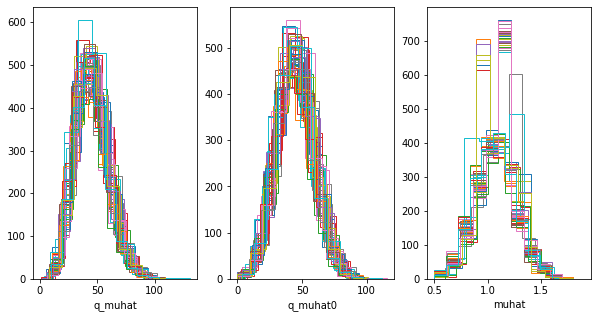

In [49]:
fig, ax = plt.subplots(1,3, figsize = (10,5))

for i, dist in enumerate(q_muhat_dist_lista):
    #print(np.sqrt(np.median(dist)))
    ax[0].hist(dist, histtype='step')
    ax[1].hist(q_muhat0_dist_lista[i], histtype='step')
    ax[2].hist(muhat_dist_lista[i], histtype='step')    
    
ax[0].set_xlabel('q_muhat')
ax[1].set_xlabel('q_muhat0')
ax[2].set_xlabel('muhat')
#plt.savefig('../graph/HIGGS_Zdiscovery_B1000_S100_distros.pdf')

Text(0, 0.5, 'Z')

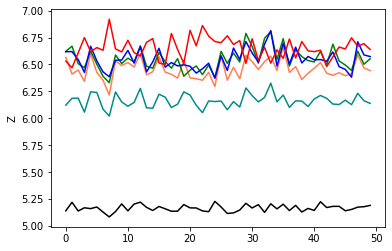

In [50]:
plt.plot(store_Z_bins_XG_10bins, color = 'darkcyan', label = '10Bins')
plt.plot(store_Z_bins_XG_25bins, color = 'coral', label = '25Bins')
plt.plot(store_Z_bins_XG_50bins, color = 'green', label = '50Bins')    
plt.plot(store_Z_bins_XG_100bins, color = 'blue', label = '100Bins')
plt.plot(store_Z_MLL_KDE, color = 'red', label = 'MLL')
plt.plot(store_Z_MLL_KDE_10, color = 'magenta', label = '10 ML', linestyle = '--')
plt.plot(store_Z_WP, color = 'black', label = 'WP')
#plt.legend()
plt.ylabel('Z')
#plt.savefig('../graph/HIGGS_Zdiscovery_B1000_S100.pdf')

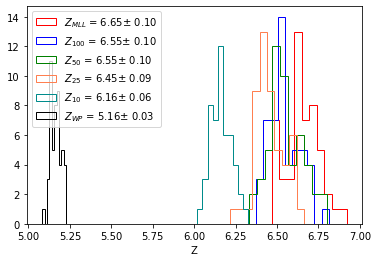

In [51]:
plt.hist(store_Z_MLL_KDE, color = 'red', histtype = 'step', 
         label = r'$Z_{MLL}$ = ' + '{:.2f}'.format(np.mean(store_Z_MLL_KDE)) +'$\pm$ ' + '{:.2f}'.format(np.std(store_Z_MLL_KDE)) )
plt.hist(store_Z_bins_XG_100bins, color = 'blue', histtype = 'step', 
         label = r'$Z_{100}$ = ' + '{:.2f}'.format(np.mean(store_Z_bins_XG_100bins)) +'$\pm$ ' + '{:.2f}'.format(np.std(store_Z_bins_XG_100bins)) )
plt.hist(store_Z_bins_XG_50bins, color = 'green', histtype = 'step', 
         label = r'$Z_{50}$ = ' + '{:.2f}'.format(np.mean(store_Z_bins_XG_50bins)) +'$\pm$ ' + '{:.2f}'.format(np.std(store_Z_bins_XG_50bins)) )
plt.hist(store_Z_bins_XG_25bins, color = 'coral', histtype = 'step', 
         label = r'$Z_{25}$ = ' + '{:.2f}'.format(np.mean(store_Z_bins_XG_25bins)) +'$\pm$ ' + '{:.2f}'.format(np.std(store_Z_bins_XG_25bins)) )
plt.hist(store_Z_bins_XG_10bins, color = 'darkcyan', histtype = 'step', 
         label = r'$Z_{10}$ = ' + '{:.2f}'.format(np.mean(store_Z_bins_XG_10bins)) +'$\pm$ ' + '{:.2f}'.format(np.std(store_Z_bins_XG_10bins)) )
plt.hist(store_Z_WP, color = 'black', histtype = 'step', 
         label = r'$Z_{WP}$ = ' + '{:.2f}'.format(np.mean(store_Z_WP)) +'$\pm$ ' + '{:.2f}'.format(np.std(store_Z_WP)) )
plt.legend()
plt.xlabel('Z')
plt.savefig('../graph/HIGGS_Zdiscovery_B1000_S100_distrosZ.pdf')

In [52]:
print(r'$Z_{10}$ = ', np.mean(store_Z_bins_XG_10bins), '$\pm$ ', np.std(store_Z_bins_XG_10bins))
print(r'$Z_{25}$ = ', np.mean(store_Z_bins_XG_25bins), '$\pm$ ', np.std(store_Z_bins_XG_25bins))
print(r'$Z_{50}$ = ', np.mean(store_Z_bins_XG_50bins), '$\pm$ ', np.std(store_Z_bins_XG_50bins))
print(r'$Z_{100}$ = ', np.mean(store_Z_bins_XG_100bins), '$\pm$ ', np.std(store_Z_bins_XG_100bins))
print(r'$Z_{MLL}$ = ', np.mean(store_Z_MLL_KDE), '$\pm$ ', np.std(store_Z_MLL_KDE))
print(r'$Z_{WP}$ = ', np.mean(store_Z_WP), '$\pm$ ', np.std(store_Z_WP))

$Z_{10}$ =  6.161521850347708 $\pm$  0.06250022816887303
$Z_{25}$ =  6.454354013722966 $\pm$  0.08921093553167865
$Z_{50}$ =  6.548827079897307 $\pm$  0.10284642874129951
$Z_{100}$ =  6.547267061640045 $\pm$  0.09618766600130872
$Z_{MLL}$ =  6.65205346076378 $\pm$  0.0986737974992477
$Z_{WP}$ =  5.164535271019979 $\pm$  0.03179294150753656
